In [1]:
from model_helpers import *

import cfgrib
import xarray as xr

import pandas as pd
import numpy as np

from pyPhenology import models, utils

from tqdm import trange, tqdm

import matplotlib.pyplot as plt

from warnings import warn
import warnings

warnings.filterwarnings('ignore')

high_cutoff_year = 2022
low_cutoff_year = 2010

In [2]:
def make_test_df(train_df):
    #print(train_df)
    species_sites = train_df['site_id'].unique()
        
    #print(species_sites)
    
    site_ripenesses = []

    for site in species_sites:
        site_df = train_df[train_df['site_id'] == site]

        site_ripenesses.append({
            'site_id': site,
            'doy': np.mean(site_df['doy'])
        })

    species_test_df = pd.DataFrame(site_ripenesses)
    species_test_df['year'] = high_cutoff_year
    
    return species_test_df

# More specific to our uses.
def train_ripeness_small(observations, predictors, test_observations, test_predictors, model_name = 'ThermalTime'):

    print("running model {m}".format(m=model_name))
    Model = utils.load_model(model_name)
    model = Model()
    model.fit(observations, predictors, optimizer_params='practical')
    
    print(model)
    
    print("making predictions for model {m}".format(m=model_name))        
    preds = model.predict(test_observations, test_predictors)

    if len(preds) == 0:
        print(test_observations)
        print(test_predictors)
    
    test_days = test_observations.doy.values
    print(test_days)
    print(preds)
   
    # Various error types
    model_mae = mae(test_days, preds)
    model_rmse = rmse(test_days, preds)
    median_error = np.median(np.abs(test_days - preds))

    print('model {m} got a MAE of {a}'.format(m=model_name,a=model_mae))
    print('model {m} got an RMSE of {a}'.format(m=model_name,a=model_rmse))
    print('model {m}\'s median error is: {a}'.format(m=model_name,a=median_error))

    print("Ripeness Day: {}".format(np.mean(preds)))
    
    ripeness_data = test_observations
    ripeness_data['ripeness_day'] = preds
    
    ripeness_dict = {
        'model_object': model,
        'MAE': model_mae,
        'RMSE': model_rmse,
        'Median Error': median_error,
        'prediction_df': ripeness_data,
    }
    
    return ripeness_dict

Idea for corrections: take the lower error between the base error and the year-transformed error.


Best Approach is:
- High time resolution, correcting for missing data by using averaged data from previous years.
- Add European Weather data.
- No southern hemisphere. 
- Corrected error (i.e. date wrapping). 

Best reporting statistic: what portion of results lie under X.
For example, 80% of results lie under 1 STD, 95% lie under 2 STD. 
Can make a "confidence score" from this – percentile error? Ex. This is less error than 90% of things.  

In [100]:
# Load in high-res weather data
print("loading weather data")
grib_data = cfgrib.open_datasets('../data/monthly_weather_data.grib')

core_data = grib_data[0]

print("Loading Plant Data")
formatted_plants = pd.read_csv("../data/model_training_data/all_plants_formatted.csv", index_col=0)

formatted_plants['rounded_lat'] = np.round(formatted_plants['latitude'], 1)
formatted_plants['rounded_lon'] = np.round(formatted_plants['lon_360'], 1)

#rounded_sites = formatted_plants[['site_id', 'rounded_lat', 'rounded_lon']].drop_duplicates()

site_x_vals = xr.DataArray(formatted_plants['rounded_lat'], dims=['site'])
site_y_vals = xr.DataArray(formatted_plants['rounded_lon'], dims=['site'])

print("filtering weather data")
full_weather_data = core_data.sel(latitude=site_x_vals, longitude=site_y_vals, method='nearest').to_dataframe().dropna().drop_duplicates()

print("formatting weather data")
formatted_weather = format_weather_data(full_weather_data)

formatted_weather['latitude'] = np.round(formatted_weather['latitude'], 1)
formatted_weather['longitude'] = np.round(formatted_weather['longitude'], 1)

print("adding site IDs to weather data")
#rounded_sites['coordstring'] = rounded_sites['rounded_lat'].astype(str) + rounded_sites['rounded_lon'].astype(str)
formatted_plants['coordstring'] = formatted_plants['rounded_lat'].astype(str) + formatted_plants['rounded_lon'].astype(str)

formatted_weather['coordstring'] = formatted_weather['latitude'].astype(str) + formatted_weather['longitude'].astype(str)

formatted_plants['site_id'] = formatted_plants['coordstring'].str.replace(".", "")
formatted_weather['site_id'] = formatted_weather['coordstring'].str.replace(".", "")

## Add Site ID to the weather data
#weather_with_sites = pd.merge(formatted_weather, formatted_plants[['coordstring', 'site_id']], on='coordstring')#.drop('coordstring', axis=1)
## Separate into training data and testing data

# filter out current year
print("separating weather data")
formatted_weather = formatted_weather[formatted_weather['year'] != 2023]

# 
print("converting to Celsius")
formatted_weather['temperature'] = formatted_weather['temperature'] - 272.15

#weather_training = weather_with_sites[weather_with_sites['year'] < high_cutoff_year]
#weather_test = weather_with_sites[weather_with_sites['year'] >= high_cutoff_year]

# final formatting steps for plants
print("formatting plant data")
species_list = formatted_plants['formatted_sci_name'].unique()
formatted_plants.drop('species', axis=1, inplace=True)

# correct for missing sites
weather_sites = formatted_weather['site_id'].unique()

print("filtering plant data")
filtered_plants = formatted_plants[(formatted_plants['site_id'].isin(weather_sites)) & 
                                   (formatted_plants['year'] != 2023) &
                                   (formatted_plants['latitude'] > 0) &
                                    (formatted_plants['doy'] >= 60)]

aggressive_filtered_plants = filtered_plants.query('doy <= 145 and doy >= 314')


loading weather data
Loading Plant Data
filtering weather data
formatting weather data
formatting date columns
correcting leap years
adding site IDs to weather data
separating weather data
converting to Celsius
formatting plant data
filtering plant data


In [101]:
formatted_plants

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,coordstring
0,4372806,43.680695,198.0,2020.0,Rubus,280.617281,516,Rubus,43.7,280.6,43.7280.6
1,4312796,43.115834,206.0,2020.0,Rubus,279.566474,516,Rubus,43.1,279.6,43.1279.6
2,4002769,39.978432,173.0,2020.0,Rubus,276.941349,516,Rubus,40.0,276.9,40.0276.9
3,4042801,40.431277,202.0,2020.0,Rubus,280.085982,516,Rubus,40.4,280.1,40.4280.1
4,4042801,40.431277,181.0,2020.0,Rubus,280.085982,516,Rubus,40.4,280.1,40.4280.1
...,...,...,...,...,...,...,...,...,...,...,...
148871,3612798,36.074535,335.0,2015.0,Pyrus,279.768090,516,Pyrus pyrifolia,36.1,279.8,36.1279.8
148872,3542808,35.432416,119.0,2023.0,Pyrus,280.781434,516,Pyrus pyrifolia,35.4,280.8,35.4280.8
148873,3792754,37.869680,233.0,2016.0,Pyrus,275.415025,516,Pyrus pyrifolia,37.9,275.4,37.9275.4
148874,4552372,45.512989,244.0,2021.0,Pyrus,237.154095,516,Pyrus pyrifolia,45.5,237.2,45.5237.2


In [102]:
formatted_weather

,temperature,year,doy,latitude,longitude,coordstring,site_id
0,-5.445190,2010,1,43.7,280.6,43.7280.6,4372806
1,-6.786987,2010,1,43.1,279.6,43.1279.6,4312796
2,-4.749878,2010,1,40.0,276.9,40.0276.9,4002769
3,-5.156128,2010,1,40.4,280.1,40.4280.1,4042801
4,-6.206909,2010,1,43.2,289.1,43.2289.1,4322891
...,...,...,...,...,...,...,...
538975,1.518219,2022,336,48.1,236.5,48.1236.5,4812365
538976,-0.026703,2022,336,50.5,16.9,50.516.9,505169
538977,5.483063,2022,336,48.5,356.1,48.5356.1,4853561
538978,1.860016,2022,336,47.2,237.6,47.2237.6,4722376


In [73]:
euro_data = load_euro_weather_data(euro_path, '../data/high_res_euro_stations.csv')

In [74]:
## Make site ID column of euro data from coordstring

print("constructing european site IDs")
euro_data['site_id'] = euro_data['coordstring'].str.replace(".", "")

# Make sure to drop duplicate sites/coordstrings?
print("filtering euro data")
filtered_euro = euro_data[euro_data['site_id'].isin(formatted_weather['site_id'].unique())]

# merge euro data with monthly 

constructing european site IDs
filtering euro data


In [75]:
euro_data

,station,year,doy,temperature,latitude,longitude,coordstring,site_id
0,2,2010,2,-12.4,60.4,15.4,60.415.4,604154
1,2,2010,3,-10.5,60.4,15.4,60.415.4,604154
2,2,2010,4,-11.1,60.4,15.4,60.415.4,604154
3,2,2010,5,-20.1,60.4,15.4,60.415.4,604154
4,2,2010,6,-25.5,60.4,15.4,60.415.4,604154
...,...,...,...,...,...,...,...,...
14926227,26319,2023,177,15.4,63.0,7.2,63.07.2,63072
14926228,26319,2023,178,14.4,63.0,7.2,63.07.2,63072
14926229,26319,2023,179,14.5,63.0,7.2,63.07.2,63072
14926230,26319,2023,180,13.0,63.0,7.2,63.07.2,63072


In [76]:
filtered_euro

,station,year,doy,temperature,latitude,longitude,coordstring,site_id
140857,44,2010,2,-0.7,50.0,8.4,50.08.4,50084
140858,44,2010,3,-1.1,50.0,8.4,50.08.4,50084
140859,44,2010,4,-4.2,50.0,8.4,50.08.4,50084
140860,44,2010,5,-8.3,50.0,8.4,50.08.4,50084
140861,44,2010,6,-7.2,50.0,8.4,50.08.4,50084
...,...,...,...,...,...,...,...,...
14506111,25247,2023,177,20.7,54.5,9.6,54.59.6,54596
14506112,25247,2023,178,17.5,54.5,9.6,54.59.6,54596
14506113,25247,2023,179,19.1,54.5,9.6,54.59.6,54596
14506114,25247,2023,180,19.1,54.5,9.6,54.59.6,54596


In [77]:
euro_sites = euro_data['site_id'].unique()

unmutual_sites = formatted_weather[~formatted_weather['site_id'].isin(euro_sites)]

In [88]:
merged_euro = pd.concat([unmutual_sites, euro_data]).drop('station', axis=1)

merged_euro = merged_euro[merged_euro['site_id'].isin(formatted_plants['site_id'])]

merged_euro = merged_euro[merged_euro['year'] != 2023]
merged_euro['temperature'] = np.round(merged_euro['temperature'], 1)

In [89]:
merged_euro

,temperature,year,doy,latitude,longitude,coordstring,site_id
0,-5.4,2010,1,43.7,280.6,43.7280.6,4372806
1,-6.8,2010,1,43.1,279.6,43.1279.6,4312796
2,-4.7,2010,1,40.0,276.9,40.0276.9,4002769
3,-5.2,2010,1,40.4,280.1,40.4280.1,4042801
4,-6.2,2010,1,43.2,289.1,43.2289.1,4322891
...,...,...,...,...,...,...,...
14505931,5.2,2022,361,54.5,9.6,54.59.6,54596
14505932,3.6,2022,362,54.5,9.6,54.59.6,54596
14505933,5.8,2022,363,54.5,9.6,54.59.6,54596
14505934,7.4,2022,364,54.5,9.6,54.59.6,54596


In [85]:
merged_euro['site_id'].nunique()

3455

In [86]:
formatted_weather['site_id'].nunique()

3455

In [87]:
unmutual_sites['site_id'].nunique()

3281

Problem is with the merge on mutual sites. 

In [95]:
def train_species_models(full_plant_data, full_weather_data):
    # Separate weather data into train and test
    weather_training = full_weather_data[full_weather_data['year'] < high_cutoff_year]
    weather_test = full_weather_data[full_weather_data['year'] >= high_cutoff_year]
    
    species_prediction_dict = {}
    species_list = full_plant_data['formatted_sci_name'].unique()
    print(species_list)

    for s in tqdm(species_list):
        print("\n\n", s)
        species_train_df = full_plant_data.query('formatted_sci_name == "{}" and year < {}'.format(s, high_cutoff_year))
        
        if len(species_train_df) <= 10:
            print("not enough training data")
            continue        

        species_test_df = full_plant_data.query('formatted_sci_name == "{}" and year >= {}'.format(s, high_cutoff_year))

        if len(species_test_df) == 0:
            print("No test data for {}".format(s))
            # make predictions and compare to the mean ripeness day at each site
            species_test_df = make_test_df(species_train_df)

        if len(species_test_df) == 0:
            print("No test data for {}".format(s))
            #print(species_test_df)
            
        filtered_weather_test = weather_test[weather_test['site_id'].isin(species_test_df['site_id'])]
        
        #print(species_train_df, weather_training)
        #print(species_test_df)
        #print(filtered_weather_test)
        print(np.sort(species_test_df['site_id'].unique()))
        print(np.sort(filtered_weather_test['site_id'].unique()))

        predictions = train_ripeness_small(species_train_df, weather_training,
                            species_test_df, weather_test)

        #break
        
        species_prediction_dict[s] = predictions
        
    # gets a list of all the prediction dataframes from the species model
    df_list = [i['prediction_df'] for i in species_prediction_dict.values()]

    full_prediction_df = pd.concat(df_list)

    full_prediction_df['abs_error'] = np.abs(full_prediction_df['doy'] - full_prediction_df['flowering_day'])
    
    print(score_model(full_prediction_df))
    
    return full_prediction_df


In [96]:
euro_observations = filtered_plants[filtered_plants['site_id'].isin(merged_euro['site_id'])]


In [103]:
normal_training_euro = train_species_models(euro_observations, formatted_weather)

['Rubus' 'Rubus occidentalis' 'Ficus' 'Ficus carica' 'Ficus citrifolia'
 'Ficus macrophylla' 'Ficus sycomorus' 'Olea europaea' 'Olea europea'
 'Olea' 'Morus rubra' 'Morus nigra' 'Morus' 'Morus alba' 'Morus macroura'
 'Morus australis' 'Amelanchier alnifolia' 'Amelanchier arborea'
 'Amelanchier canadensis' 'Amelanchier grandiflora' 'Amelanchier laevis'
 'Amelanchier utahensis' 'Amelanchier' 'Citrus' 'Citrus jambhiri'
 'Citrus limon' 'Rubus idaeus' 'Rubus ellipticus' 'Rubus hayata'
 'Rubus odoratus' 'Rubus phoenicolasius' 'Rubus rolfei' 'Citrus aurantium'
 'Citrus sinensis' 'Prunus americana' 'Prunus domestica' 'Prunus maritima'
 'Prunus nigra' 'Prunus cerasifera' 'Prunus' 'Prunus angustifolia'
 'Prunus cocomilia' 'Prunus salicina' 'Prunus subcordata'
 'Prunus mexicana' 'Prunus rivularis' 'Eriobotrya japonica'
 'Malus sieboldii' 'Malus' 'Malus pumila' 'Malus domestica'
 'Malus sylvestris' 'Malus coronaria' "Malus '" 'Malus sieversii'
 'Malus baccata' 'Malus ioensis' 'Malus hupehensis' 'M

  0%|                                                                                                                                                                              | 0/95 [00:00<?, ?it/s]



 Rubus
['320348' '3522702' '3742808' '3862697' '3872695' '3892655' '3982550'
 '4002770' '4022828' '4092786' '4202683' '4232749' '4232889' '4302743'
 '4302782' '4302784' '4302823' '4312824' '4352714' '4552374' '4823583'
 '5232462' '5343578' '5343579']
['320348' '3522702' '3742808' '3862697' '3872695' '3892655' '3982550'
 '4002770' '4022828' '4092786' '4202683' '4232749' '4232889' '4302743'
 '4302782' '4302784' '4302823' '4312824' '4352714' '4552374' '4823583'
 '5232462' '5343578' '5343579']
running model ThermalTime


  1%|█▋                                                                                                                                                                    | 1/95 [00:00<01:25,  1.10it/s]

making predictions for model ThermalTime
[183. 181. 190. 193. 165. 165. 184. 181. 178. 184. 246. 202. 288. 192.
 173. 214. 159. 191. 191. 196. 187. 214. 216. 136. 305. 305. 305. 274.
 191. 195.]
[183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183
 183 183 183 183 183 183 183 183 183 183 183 183]
model ThermalTime got a MAE of 31.533333333333335
model ThermalTime got an RMSE of 50.20557737941075
model ThermalTime's median error is: 12.5
Ripeness Day: 183.0


 Rubus occidentalis
['4152695' '4172746' '4202720' '4312782' '4322801']
['4152695' '4172746' '4202720' '4312782' '4322801']
running model ThermalTime


  2%|███▍                                                                                                                                                                  | 2/95 [00:03<02:42,  1.74s/it]

making predictions for model ThermalTime
[164. 189. 189. 189. 184. 189. 191. 191. 191. 187.]
[183 183 183 183 183 183 214 214 214 183]
model ThermalTime got a MAE of 11.7
model ThermalTime got an RMSE of 14.522396496446445
model ThermalTime's median error is: 6.0
Ripeness Day: 192.3


 Ficus
['3502750' '3662381' '3802387' '45258' '4552373' '4552374' '4573594'
 '4752377' '4873580' '4922369']
['3502750' '3662381' '3802387' '45258' '4552373' '4552374' '4573594'
 '4752377' '4873580' '4922369']
running model ThermalTime


  2%|███▍                                                                                                                                                                  | 2/95 [00:04<03:43,  2.40s/it]


KeyboardInterrupt: 

In [104]:
normal_training_euro = train_species_models(euro_observations, merged_euro)

['Rubus' 'Rubus occidentalis' 'Ficus' 'Ficus carica' 'Ficus citrifolia'
 'Ficus macrophylla' 'Ficus sycomorus' 'Olea europaea' 'Olea europea'
 'Olea' 'Morus rubra' 'Morus nigra' 'Morus' 'Morus alba' 'Morus macroura'
 'Morus australis' 'Amelanchier alnifolia' 'Amelanchier arborea'
 'Amelanchier canadensis' 'Amelanchier grandiflora' 'Amelanchier laevis'
 'Amelanchier utahensis' 'Amelanchier' 'Citrus' 'Citrus jambhiri'
 'Citrus limon' 'Rubus idaeus' 'Rubus ellipticus' 'Rubus hayata'
 'Rubus odoratus' 'Rubus phoenicolasius' 'Rubus rolfei' 'Citrus aurantium'
 'Citrus sinensis' 'Prunus americana' 'Prunus domestica' 'Prunus maritima'
 'Prunus nigra' 'Prunus cerasifera' 'Prunus' 'Prunus angustifolia'
 'Prunus cocomilia' 'Prunus salicina' 'Prunus subcordata'
 'Prunus mexicana' 'Prunus rivularis' 'Eriobotrya japonica'
 'Malus sieboldii' 'Malus' 'Malus pumila' 'Malus domestica'
 'Malus sylvestris' 'Malus coronaria' "Malus '" 'Malus sieversii'
 'Malus baccata' 'Malus ioensis' 'Malus hupehensis' 'M

  0%|                                                                                                                                                                              | 0/95 [00:00<?, ?it/s]



 Rubus
['320348' '3522702' '3742808' '3862697' '3872695' '3892655' '3982550'
 '4002770' '4022828' '4092786' '4202683' '4232749' '4232889' '4302743'
 '4302782' '4302784' '4302823' '4312824' '4352714' '4552374' '4823583'
 '5232462' '5343578' '5343579']
['320348' '3522702' '3742808' '3862697' '3872695' '3892655' '3982550'
 '4002770' '4022828' '4092786' '4202683' '4232749' '4232889' '4302743'
 '4302782' '4302784' '4302823' '4312824' '4352714' '4552374' '4823583'
 '5232462' '5343578' '5343579']
running model ThermalTime


  0%|                                                                                                                                                                              | 0/95 [00:06<?, ?it/s]

making predictions for model ThermalTime
        site_id   latitude    doy    year  genus     lon_360  phenophase  \
19      4202683  42.000443  183.0  2022.0  Rubus  268.349632         516   
20      4312824  43.123822  181.0  2022.0  Rubus  282.422069         516   
22      3522702  35.219765  190.0  2022.0  Rubus  270.150501         516   
23      4302743  43.026309  193.0  2022.0  Rubus  274.317216         516   
25      3742808  37.417095  165.0  2022.0  Rubus  280.809241         516   
26      3742808  37.403063  165.0  2022.0  Rubus  280.766240         516   
28      4302823  43.017546  184.0  2022.0  Rubus  282.252708         516   
29      4302823  43.017546  181.0  2022.0  Rubus  282.252708         516   
30      4232749  42.307718  178.0  2022.0  Rubus  274.887183         516   
31      4092786  40.863599  184.0  2022.0  Rubus  278.645318         516   
32      4232749  42.301902  246.0  2022.0  Rubus  274.869641         516   
33      4232889  42.322520  202.0  2022.0  Rubu

ValueError: operands could not be broadcast together with shapes (30,) (0,) 

In [105]:
formatted_weather

,temperature,year,doy,latitude,longitude,coordstring,site_id
0,-5.445190,2010,1,43.7,280.6,43.7280.6,4372806
1,-6.786987,2010,1,43.1,279.6,43.1279.6,4312796
2,-4.749878,2010,1,40.0,276.9,40.0276.9,4002769
3,-5.156128,2010,1,40.4,280.1,40.4280.1,4042801
4,-6.206909,2010,1,43.2,289.1,43.2289.1,4322891
...,...,...,...,...,...,...,...
538975,1.518219,2022,336,48.1,236.5,48.1236.5,4812365
538976,-0.026703,2022,336,50.5,16.9,50.516.9,505169
538977,5.483063,2022,336,48.5,356.1,48.5356.1,4853561
538978,1.860016,2022,336,47.2,237.6,47.2237.6,4722376


In [112]:
sum(np.sort(merged_euro['site_id'].unique()) == np.sort(formatted_weather['site_id'].unique()))

2747

In [116]:
merged_euro[merged_euro['site_id'].isin(formatted_weather['site_id'])]

,temperature,year,doy,latitude,longitude,coordstring,site_id
0,-5.4,2010,1,43.7,280.6,43.7280.6,4372806
1,-6.8,2010,1,43.1,279.6,43.1279.6,4312796
2,-4.7,2010,1,40.0,276.9,40.0276.9,4002769
3,-5.2,2010,1,40.4,280.1,40.4280.1,4042801
4,-6.2,2010,1,43.2,289.1,43.2289.1,4322891
...,...,...,...,...,...,...,...
14505931,5.2,2022,361,54.5,9.6,54.59.6,54596
14505932,3.6,2022,362,54.5,9.6,54.59.6,54596
14505933,5.8,2022,363,54.5,9.6,54.59.6,54596
14505934,7.4,2022,364,54.5,9.6,54.59.6,54596


In [117]:
merged_euro

,temperature,year,doy,latitude,longitude,coordstring,site_id
0,-5.4,2010,1,43.7,280.6,43.7280.6,4372806
1,-6.8,2010,1,43.1,279.6,43.1279.6,4312796
2,-4.7,2010,1,40.0,276.9,40.0276.9,4002769
3,-5.2,2010,1,40.4,280.1,40.4280.1,4042801
4,-6.2,2010,1,43.2,289.1,43.2289.1,4322891
...,...,...,...,...,...,...,...
14505931,5.2,2022,361,54.5,9.6,54.59.6,54596
14505932,3.6,2022,362,54.5,9.6,54.59.6,54596
14505933,5.8,2022,363,54.5,9.6,54.59.6,54596
14505934,7.4,2022,364,54.5,9.6,54.59.6,54596


In [118]:
merged_euro['site_id'].nunique()

3455

In [119]:
formatted_weather['site_id'].nunique()

3455

In [138]:
## Don't run this, produces nothing

for s in tqdm(merged_euro['site_id'].unique()):
    site_df = merged_euro.query('site_id == {}'.format(s))
    
    for y in site_df['year'].unique():
        site_df_y = site_df.query('year == {}'.format(y))
        
        if len(site_df_y) != 365 or len(site_df_y) != 366 or len(site_df_y) != 12:
            print(s, y, len(site_df_y))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3455/3455 [04:25<00:00, 13.03it/s]


In [139]:
for s in tqdm(merged_euro['site_id'].unique()):
    site_df = merged_euro.query('site_id == {}'.format(s))
    
    site_df_y = site_df.query('year == 2022'.format(y))
        
    if len(site_df_y) != 365 or len(site_df_y) != 366 or len(site_df_y) != 12:
        print(s, y, len(site_df_y))

  0%|                                                                                                                                                                    | 2/3455 [00:00<04:27, 12.91it/s]

4372806 2022 0
4312796 2022 0
4002769 2022 0


  0%|▎                                                                                                                                                                   | 6/3455 [00:00<04:17, 13.37it/s]

4042801 2022 0
4322891 2022 0
4112861 2022 0


  0%|▍                                                                                                                                                                   | 8/3455 [00:00<04:17, 13.39it/s]

4242887 2022 0
3242782 2022 0
3882818 2022 0


  0%|▌                                                                                                                                                                  | 12/3455 [00:00<04:29, 12.79it/s]

4703587 2022 0
4052801 2022 0
4032798 2022 0


  0%|▋                                                                                                                                                                  | 14/3455 [00:01<04:28, 12.82it/s]

4212683 2022 0
4342795 2022 0
4202683 2022 0


  1%|▊                                                                                                                                                                  | 18/3455 [00:01<04:19, 13.24it/s]

4312824 2022 0
3522702 2022 0
4302743 2022 0


  1%|▉                                                                                                                                                                  | 20/3455 [00:01<04:18, 13.30it/s]

4122786 2022 0
3742808 2022 0
4342796 2022 0


  1%|█▏                                                                                                                                                                 | 24/3455 [00:01<04:15, 13.43it/s]

4302823 2022 0
4232749 2022 0
4092786 2022 0


  1%|█▏                                                                                                                                                                 | 26/3455 [00:01<04:15, 13.41it/s]

4232889 2022 0
320348 2022 0
4472668 2022 0


  1%|█▍                                                                                                                                                                 | 30/3455 [00:02<04:13, 13.49it/s]

4472669 2022 0
4182724 2022 0
4192720 2022 0


  1%|█▌                                                                                                                                                                 | 32/3455 [00:02<04:14, 13.46it/s]

4232721 2022 0
4312704 2022 0
4472667 2022 0


  1%|█▋                                                                                                                                                                 | 36/3455 [00:02<04:12, 13.55it/s]

3732381 2022 0
4412660 2022 0
4152694 2022 0


  1%|█▊                                                                                                                                                                 | 38/3455 [00:02<04:13, 13.47it/s]

4082821 2022 0
4342703 2022 0
4182787 2022 0


  1%|█▉                                                                                                                                                                 | 42/3455 [00:03<04:13, 13.49it/s]

3232698 2022 0
4272757 2022 0
3972741 2022 0


  1%|██                                                                                                                                                                 | 44/3455 [00:03<04:13, 13.46it/s]

3692664 2022 0
4492667 2022 0
3982742 2022 0


  1%|██▎                                                                                                                                                                | 48/3455 [00:03<04:13, 13.46it/s]

3982743 2022 0
4352714 2022 0
4552659 2022 0


  1%|██▎                                                                                                                                                                | 50/3455 [00:03<04:12, 13.46it/s]

4292832 2022 0
3922735 2022 0
3902824 2022 0


  2%|██▌                                                                                                                                                                | 54/3455 [00:04<04:13, 13.44it/s]

4312706 2022 0
4212682 2022 0
4272863 2022 0


  2%|██▋                                                                                                                                                                | 56/3455 [00:04<04:12, 13.45it/s]

4302787 2022 0
4482667 2022 0
3982736 2022 0


  2%|██▊                                                                                                                                                                | 60/3455 [00:04<04:10, 13.53it/s]

4302722 2022 0
4462715 2022 0
4252891 2022 0


  2%|██▉                                                                                                                                                                | 62/3455 [00:04<04:12, 13.46it/s]

4152730 2022 0
4262890 2022 0
4362877 2022 0


  2%|███                                                                                                                                                                | 66/3455 [00:04<04:11, 13.47it/s]

4232888 2022 0
4012770 2022 0
4042769 2022 0


  2%|███▏                                                                                                                                                               | 68/3455 [00:05<04:11, 13.46it/s]

4302744 2022 0
4272861 2022 0
3612658 2022 0


  2%|███▍                                                                                                                                                               | 72/3455 [00:05<04:12, 13.41it/s]

4152695 2022 0
4202720 2022 0
4312782 2022 0


  2%|███▍                                                                                                                                                               | 74/3455 [00:05<04:11, 13.45it/s]

4322801 2022 0
4172746 2022 0
4012771 2022 0


  2%|███▋                                                                                                                                                               | 78/3455 [00:05<04:08, 13.57it/s]

4012769 2022 0
4132742 2022 0
4202835 2022 0


  2%|███▊                                                                                                                                                               | 80/3455 [00:05<04:09, 13.51it/s]

4312744 2022 0
4272755 2022 0
4172741 2022 0


  2%|███▉                                                                                                                                                               | 84/3455 [00:06<04:09, 13.50it/s]

4142783 2022 0
4232762 2022 0
4082822 2022 0


  2%|████                                                                                                                                                               | 86/3455 [00:06<04:09, 13.49it/s]

4142782 2022 0
4362895 2022 0
4392811 2022 0


  3%|████▏                                                                                                                                                              | 90/3455 [00:06<04:08, 13.56it/s]

4152725 2022 0
4063568 2022 0
421191 2022 0


  3%|████▎                                                                                                                                                              | 92/3455 [00:06<04:08, 13.53it/s]

424193 2022 0
3802815 2022 0
3422414 2022 0


  3%|████▌                                                                                                                                                              | 96/3455 [00:07<04:06, 13.61it/s]

3742379 2022 0
3352480 2022 0
3392420 2022 0


  3%|████▌                                                                                                                                                              | 98/3455 [00:07<04:07, 13.56it/s]

4552374 2022 0
3422416 2022 0
3862385 2022 0


  3%|████▊                                                                                                                                                             | 102/3455 [00:07<04:07, 13.57it/s]

3832373 2022 0
4772377 2022 0
3062637 2022 0


  3%|████▉                                                                                                                                                             | 104/3455 [00:07<04:07, 13.54it/s]

4752377 2022 0
3802387 2022 0
-4281475 2022 0


  3%|█████                                                                                                                                                             | 108/3455 [00:08<04:06, 13.57it/s]

-3681443 2022 0
-3501386 2022 0
3032623 2022 0


  3%|█████▏                                                                                                                                                            | 110/3455 [00:08<04:07, 13.50it/s]

3512700 2022 0
3402416 2022 0
52202 2022 0


  3%|█████▎                                                                                                                                                            | 114/3455 [00:08<04:07, 13.51it/s]

43844 2022 0
4542373 2022 0
4562374 2022 0


  3%|█████▍                                                                                                                                                            | 116/3455 [00:08<04:06, 13.52it/s]

4493593 2022 0
3752381 2022 0
-3491386 2022 0


  3%|█████▋                                                                                                                                                            | 120/3455 [00:08<04:07, 13.48it/s]

4552373 2022 0
-3781449 2022 0
4063514 2022 0


  4%|█████▋                                                                                                                                                            | 122/3455 [00:09<04:07, 13.44it/s]

43639 2022 0
5143574 2022 0
48725 2022 0


  4%|█████▉                                                                                                                                                            | 126/3455 [00:09<04:05, 13.55it/s]

48724 2022 0
3832742 2022 0
43739 2022 0


  4%|██████                                                                                                                                                            | 128/3455 [00:09<04:06, 13.48it/s]

3762826 2022 0
3852383 2022 0
5133577 2022 0


  4%|██████▏                                                                                                                                                           | 132/3455 [00:09<04:07, 13.44it/s]

3862386 2022 0
-3531492 2022 0
-3781450 2022 0


  4%|██████▎                                                                                                                                                           | 134/3455 [00:09<04:07, 13.41it/s]

-3571473 2022 0
2982646 2022 0
4732375 2022 0


  4%|██████▍                                                                                                                                                           | 138/3455 [00:10<04:06, 13.47it/s]

52201 2022 0
3002699 2022 0
43670 2022 0


  4%|██████▌                                                                                                                                                           | 140/3455 [00:10<04:05, 13.48it/s]

4483595 2022 0
45849 2022 0
4002848 2022 0


  4%|██████▊                                                                                                                                                           | 144/3455 [00:10<04:03, 13.57it/s]

3532393 2022 0
317349 2022 0
42630 2022 0


  4%|██████▊                                                                                                                                                           | 146/3455 [00:10<04:04, 13.51it/s]

-4041756 2022 0
318352 2022 0
43845 2022 0


  4%|███████                                                                                                                                                           | 150/3455 [00:11<04:03, 13.58it/s]

43950 2022 0
4882375 2022 0
3892830 2022 0


  4%|███████▏                                                                                                                                                          | 152/3455 [00:11<04:07, 13.37it/s]

3552791 2022 0
3722832 2022 0
3612447 2022 0


  5%|███████▎                                                                                                                                                          | 156/3455 [00:11<04:09, 13.22it/s]

3022622 2022 0
3422417 2022 0
4063513 2022 0


  5%|███████▍                                                                                                                                                          | 158/3455 [00:11<04:08, 13.29it/s]

3972382 2022 0
5173578 2022 0
43315 2022 0


  5%|███████▌                                                                                                                                                          | 162/3455 [00:12<04:04, 13.48it/s]

43415 2022 0
-3191159 2022 0
398158 2022 0


  5%|███████▋                                                                                                                                                          | 164/3455 [00:12<04:03, 13.52it/s]

3932834 2022 0
3742381 2022 0
4462367 2022 0


  5%|███████▉                                                                                                                                                          | 168/3455 [00:12<04:03, 13.51it/s]

3842386 2022 0
4573594 2022 0
4242367 2022 0


  5%|███████▉                                                                                                                                                          | 170/3455 [00:12<04:05, 13.39it/s]

4242366 2022 0
4723584 2022 0
49106 2022 0


  5%|████████▏                                                                                                                                                         | 174/3455 [00:12<04:13, 12.96it/s]

3562774 2022 0
-3521491 2022 0
43614 2022 0


  5%|████████▎                                                                                                                                                         | 176/3455 [00:13<04:11, 13.06it/s]

-3771450 2022 0
4922369 2022 0
4873580 2022 0


  5%|████████▍                                                                                                                                                         | 180/3455 [00:13<04:05, 13.33it/s]

3502750 2022 0
45258 2022 0
3662381 2022 0


  5%|████████▌                                                                                                                                                         | 182/3455 [00:13<04:06, 13.30it/s]

-2623018 2022 0
2972777 2022 0
4562373 2022 0


  5%|████████▋                                                                                                                                                         | 186/3455 [00:13<04:02, 13.49it/s]

3272428 2022 0
3412416 2022 0
3402420 2022 0


  5%|████████▊                                                                                                                                                         | 188/3455 [00:13<04:03, 13.44it/s]

1932609 2022 0
2972647 2022 0
51311 2022 0


  6%|█████████                                                                                                                                                         | 192/3455 [00:14<04:01, 13.52it/s]

47587 2022 0
3512793 2022 0
4932369 2022 0


  6%|█████████                                                                                                                                                         | 194/3455 [00:14<04:01, 13.49it/s]

-3342894 2022 0
4463590 2022 0
50631 2022 0


  6%|█████████▎                                                                                                                                                        | 198/3455 [00:14<04:01, 13.51it/s]

3792377 2022 0
-2731530 2022 0
3842380 2022 0


  6%|█████████▍                                                                                                                                                        | 200/3455 [00:14<04:00, 13.51it/s]

43919 2022 0
48723 2022 0
-3191158 2022 0


  6%|█████████▌                                                                                                                                                        | 204/3455 [00:15<04:00, 13.51it/s]

3752825 2022 0
3392419 2022 0
45257 2022 0


  6%|█████████▋                                                                                                                                                        | 206/3455 [00:15<04:00, 13.52it/s]

3472772 2022 0
321348 2022 0
3522792 2022 0


  6%|█████████▊                                                                                                                                                        | 210/3455 [00:15<03:59, 13.53it/s]

47485 2022 0
-3791452 2022 0
4402369 2022 0


  6%|█████████▉                                                                                                                                                        | 212/3455 [00:15<04:00, 13.50it/s]

3752826 2022 0
4653582 2022 0
3322724 2022 0


  6%|██████████▏                                                                                                                                                       | 216/3455 [00:16<04:00, 13.48it/s]

3912830 2022 0
4702372 2022 0
3602812 2022 0


  6%|██████████▏                                                                                                                                                       | 218/3455 [00:16<04:00, 13.43it/s]

3762825 2022 0
3342481 2022 0
3712383 2022 0


  6%|██████████▍                                                                                                                                                       | 222/3455 [00:16<03:59, 13.48it/s]

4552372 2022 0
2631278 2022 0
42729 2022 0


  6%|██████████▌                                                                                                                                                       | 224/3455 [00:16<04:00, 13.44it/s]

-3291517 2022 0
3412421 2022 0
43516 2022 0


  7%|██████████▋                                                                                                                                                       | 228/3455 [00:16<04:05, 13.14it/s]

3222490 2022 0
3802379 2022 0
3412419 2022 0


  7%|██████████▊                                                                                                                                                       | 230/3455 [00:17<04:03, 13.22it/s]

3412418 2022 0
3752377 2022 0
434110 2022 0


  7%|██████████▉                                                                                                                                                       | 234/3455 [00:17<04:00, 13.39it/s]

3372426 2022 0
41418 2022 0
41821 2022 0


  7%|███████████                                                                                                                                                       | 236/3455 [00:17<04:00, 13.38it/s]

41110 2022 0
42130 2022 0
41619 2022 0


  7%|███████████▎                                                                                                                                                      | 240/3455 [00:17<03:59, 13.41it/s]

41420 2022 0
41522 2022 0
42210 2022 0


  7%|███████████▎                                                                                                                                                      | 242/3455 [00:18<03:59, 13.40it/s]

41209 2022 0
41307 2022 0
41705 2022 0


  7%|███████████▌                                                                                                                                                      | 246/3455 [00:18<03:59, 13.40it/s]

42015 2022 0
41511 2022 0
41722 2022 0


  7%|███████████▋                                                                                                                                                      | 248/3455 [00:18<03:58, 13.44it/s]

3903561 2022 0
428180 2022 0
369102 2022 0


  7%|███████████▊                                                                                                                                                      | 252/3455 [00:18<03:57, 13.47it/s]

3662383 2022 0
-3601470 2022 0
-3211161 2022 0


  7%|███████████▉                                                                                                                                                      | 254/3455 [00:18<03:58, 13.45it/s]

3742380 2022 0
3462399 2022 0
-4141471 2022 0


  7%|████████████                                                                                                                                                      | 258/3455 [00:19<03:57, 13.45it/s]

-3791451 2022 0
3002698 2022 0
381240 2022 0


  8%|████████████▏                                                                                                                                                     | 260/3455 [00:19<03:56, 13.48it/s]

-3761447 2022 0
-3391512 2022 0
-3201158 2022 0


  8%|████████████▍                                                                                                                                                     | 264/3455 [00:19<03:56, 13.49it/s]

4062376 2022 0
3852382 2022 0
3832380 2022 0


  8%|████████████▍                                                                                                                                                     | 266/3455 [00:19<03:57, 13.45it/s]

3222491 2022 0
3422418 2022 0
-3291516 2022 0


  8%|████████████▋                                                                                                                                                     | 270/3455 [00:20<03:55, 13.53it/s]

3672402 2022 0
-3691747 2022 0
-3781451 2022 0


  8%|████████████▊                                                                                                                                                     | 272/3455 [00:20<03:55, 13.53it/s]

320350 2022 0
3852373 2022 0
-3771451 2022 0


  8%|████████████▉                                                                                                                                                     | 276/3455 [00:20<03:55, 13.52it/s]

3792379 2022 0
-3511433 2022 0
3732380 2022 0


  8%|█████████████                                                                                                                                                     | 278/3455 [00:20<03:55, 13.51it/s]

-3291518 2022 0
3642386 2022 0
-3201159 2022 0


  8%|█████████████▏                                                                                                                                                    | 282/3455 [00:20<03:53, 13.56it/s]

3002700 2022 0
4122641 2022 0
3702837 2022 0


  8%|█████████████▎                                                                                                                                                    | 284/3455 [00:21<03:54, 13.52it/s]

3482776 2022 0
3212789 2022 0
2972644 2022 0


  8%|█████████████▌                                                                                                                                                    | 288/3455 [00:21<03:52, 13.64it/s]

2972643 2022 0
-3431509 2022 0
-3391510 2022 0


  8%|█████████████▌                                                                                                                                                    | 290/3455 [00:21<03:53, 13.57it/s]

-3391511 2022 0
4813586 2022 0
-3441509 2022 0


  9%|█████████████▊                                                                                                                                                    | 294/3455 [00:21<03:53, 13.53it/s]

-3211158 2022 0
-2033197 2022 0
4302705 2022 0


  9%|█████████████▉                                                                                                                                                    | 296/3455 [00:22<03:54, 13.49it/s]

5143577 2022 0
4152723 2022 0
5153599 2022 0


  9%|██████████████                                                                                                                                                    | 300/3455 [00:22<03:53, 13.53it/s]

4232769 2022 0
4142860 2022 0
4332800 2022 0


  9%|██████████████▏                                                                                                                                                   | 302/3455 [00:22<03:53, 13.52it/s]

4222764 2022 0
4372803 2022 0
4562864 2022 0


  9%|██████████████▎                                                                                                                                                   | 306/3455 [00:22<03:51, 13.61it/s]

4242888 2022 0
4502669 2022 0
4202723 2022 0


  9%|██████████████▍                                                                                                                                                   | 308/3455 [00:22<03:51, 13.60it/s]

518195 2022 0
4492669 2022 0
4322824 2022 0


  9%|██████████████▋                                                                                                                                                   | 312/3455 [00:23<03:50, 13.62it/s]

4312738 2022 0
3622640 2022 0
4502667 2022 0


  9%|██████████████▋                                                                                                                                                   | 314/3455 [00:23<03:53, 13.47it/s]

4132871 2022 0
3952826 2022 0
4242889 2022 0


  9%|██████████████▉                                                                                                                                                   | 318/3455 [00:23<03:53, 13.46it/s]

4202684 2022 0
4242778 2022 0
4062857 2022 0


  9%|███████████████                                                                                                                                                   | 320/3455 [00:23<03:53, 13.45it/s]

4192723 2022 0
3862698 2022 0
3662652 2022 0


  9%|███████████████▏                                                                                                                                                  | 324/3455 [00:24<03:51, 13.50it/s]

4192722 2022 0
4262770 2022 0
4292716 2022 0


  9%|███████████████▎                                                                                                                                                  | 326/3455 [00:24<03:51, 13.49it/s]

3912824 2022 0
4232770 2022 0
4072860 2022 0


 10%|███████████████▍                                                                                                                                                  | 330/3455 [00:24<03:51, 13.50it/s]

4412665 2022 0
4242765 2022 0
4342797 2022 0


 10%|███████████████▌                                                                                                                                                  | 332/3455 [00:24<03:53, 13.40it/s]

4202722 2022 0
4502666 2022 0
4542843 2022 0


 10%|███████████████▊                                                                                                                                                  | 336/3455 [00:24<03:51, 13.45it/s]

3892655 2022 0
3632659 2022 0
4502668 2022 0


 10%|███████████████▊                                                                                                                                                  | 338/3455 [00:25<03:52, 13.42it/s]

4062860 2022 0
3482777 2022 0
3592626 2022 0


 10%|████████████████                                                                                                                                                  | 342/3455 [00:25<03:50, 13.53it/s]

4232882 2022 0
4022828 2022 0
4122640 2022 0


 10%|████████████████▏                                                                                                                                                 | 344/3455 [00:25<03:53, 13.32it/s]

4082601 2022 0
4222768 2022 0
4232763 2022 0


 10%|████████████████▎                                                                                                                                                 | 348/3455 [00:25<03:53, 13.32it/s]

4292771 2022 0
4222763 2022 0
3852811 2022 0


 10%|████████████████▍                                                                                                                                                 | 350/3455 [00:26<03:52, 13.38it/s]

4152782 2022 0
3832554 2022 0
4172684 2022 0


 10%|████████████████▌                                                                                                                                                 | 354/3455 [00:26<03:50, 13.43it/s]

4002770 2022 0
4102776 2022 0
454119 2022 0


 10%|████████████████▋                                                                                                                                                 | 356/3455 [00:26<03:52, 13.36it/s]

3932822 2022 0
3872697 2022 0
3762824 2022 0


 10%|████████████████▉                                                                                                                                                 | 360/3455 [00:26<03:51, 13.37it/s]

4022674 2022 0
3882695 2022 0
3822743 2022 0


 10%|████████████████▉                                                                                                                                                 | 362/3455 [00:26<03:52, 13.32it/s]

3832825 2022 0
4042800 2022 0
3512699 2022 0


 11%|█████████████████▏                                                                                                                                                | 366/3455 [00:27<03:50, 13.42it/s]

3642658 2022 0
3922829 2022 0
3602811 2022 0


 11%|█████████████████▎                                                                                                                                                | 368/3455 [00:27<03:50, 13.42it/s]

3902830 2022 0
3802755 2022 0
3632601 2022 0


 11%|█████████████████▍                                                                                                                                                | 372/3455 [00:27<03:51, 13.34it/s]

4012718 2022 0
3902652 2022 0
3552624 2022 0


 11%|█████████████████▌                                                                                                                                                | 374/3455 [00:27<03:55, 13.06it/s]

2942614 2022 0
3822742 2022 0
3892654 2022 0


 11%|█████████████████▋                                                                                                                                                | 378/3455 [00:28<03:51, 13.29it/s]

3582814 2022 0
3582813 2022 0
3042757 2022 0


 11%|█████████████████▊                                                                                                                                                | 380/3455 [00:28<03:51, 13.30it/s]

3712464 2022 0
3282430 2022 0
3282429 2022 0


 11%|██████████████████                                                                                                                                                | 384/3455 [00:28<03:48, 13.43it/s]

3612802 2022 0
319348 2022 0
3312633 2022 0


 11%|██████████████████                                                                                                                                                | 386/3455 [00:28<03:47, 13.46it/s]

329132 2022 0
-2721530 2022 0
-4321469 2022 0


 11%|██████████████████▎                                                                                                                                               | 390/3455 [00:29<03:45, 13.56it/s]

3712667 2022 0
-3331491 2022 0
-3181158 2022 0


 11%|██████████████████▍                                                                                                                                               | 392/3455 [00:29<03:46, 13.54it/s]

50844 2022 0
4212885 2022 0
4062549 2022 0


 11%|██████████████████▌                                                                                                                                               | 396/3455 [00:29<03:45, 13.56it/s]

4332801 2022 0
4152859 2022 0
-3531491 2022 0


 12%|██████████████████▋                                                                                                                                               | 398/3455 [00:29<03:46, 13.53it/s]

4352795 2022 0
4262765 2022 0
4302720 2022 0


 12%|██████████████████▊                                                                                                                                               | 402/3455 [00:29<03:45, 13.53it/s]

4042841 2022 0
4292743 2022 0
4082603 2022 0


 12%|██████████████████▉                                                                                                                                               | 404/3455 [00:30<03:45, 13.51it/s]

4292744 2022 0
511170 2022 0
4332802 2022 0


 12%|███████████████████▏                                                                                                                                              | 408/3455 [00:30<03:45, 13.52it/s]

4192724 2022 0
4302719 2022 0
4152783 2022 0


 12%|███████████████████▏                                                                                                                                              | 410/3455 [00:30<03:45, 13.53it/s]

3612732 2022 0
4042731 2022 0
4172885 2022 0


 12%|███████████████████▍                                                                                                                                              | 414/3455 [00:30<03:46, 13.42it/s]

4072481 2022 0
3912829 2022 0
4382805 2022 0


 12%|███████████████████▌                                                                                                                                              | 416/3455 [00:30<03:46, 13.39it/s]

4102861 2022 0
4172719 2022 0
4172764 2022 0


 12%|███████████████████▋                                                                                                                                              | 420/3455 [00:31<03:44, 13.51it/s]

4372807 2022 0
3992770 2022 0
4112786 2022 0


 12%|███████████████████▊                                                                                                                                              | 422/3455 [00:31<03:45, 13.47it/s]

3682837 2022 0
4002850 2022 0
4222888 2022 0


 12%|███████████████████▉                                                                                                                                              | 426/3455 [00:31<03:44, 13.51it/s]

4312720 2022 0
4082481 2022 0
4172723 2022 0


 12%|████████████████████                                                                                                                                              | 428/3455 [00:31<03:44, 13.50it/s]

4102478 2022 0
4002851 2022 0
3892829 2022 0


 13%|████████████████████▎                                                                                                                                             | 432/3455 [00:32<03:43, 13.53it/s]

4092852 2022 0
4032483 2022 0
4082482 2022 0


 13%|████████████████████▎                                                                                                                                             | 434/3455 [00:32<03:44, 13.47it/s]

3912832 2022 0
3552625 2022 0
43513 2022 0


 13%|████████████████████▌                                                                                                                                             | 438/3455 [00:32<03:43, 13.49it/s]

3852372 2022 0
4072704 2022 0
3682839 2022 0


 13%|████████████████████▋                                                                                                                                             | 440/3455 [00:32<03:44, 13.46it/s]

3692837 2022 0
3902648 2022 0
3992850 2022 0


 13%|████████████████████▊                                                                                                                                             | 444/3455 [00:33<03:42, 13.54it/s]

3682838 2022 0
357513 2022 0
3372756 2022 0


 13%|████████████████████▉                                                                                                                                             | 446/3455 [00:33<03:43, 13.47it/s]

3582736 2022 0
3372757 2022 0
3682402 2022 0


 13%|█████████████████████                                                                                                                                             | 450/3455 [00:33<03:42, 13.48it/s]

3282801 2022 0
2782773 2022 0
2802773 2022 0


 13%|█████████████████████▏                                                                                                                                            | 452/3455 [00:33<03:43, 13.45it/s]

-4291473 2022 0
4782378 2022 0
3772383 2022 0


 13%|█████████████████████▍                                                                                                                                            | 456/3455 [00:33<03:42, 13.49it/s]

-258283 2022 0
-3142958 2022 0
-3181160 2022 0


 13%|█████████████████████▍                                                                                                                                            | 458/3455 [00:34<03:42, 13.46it/s]

-3461508 2022 0
-3381512 2022 0
-2661531 2022 0


 13%|█████████████████████▋                                                                                                                                            | 462/3455 [00:34<03:39, 13.62it/s]

43646 2022 0
-2353133 2022 0
5193597 2022 0


 13%|█████████████████████▊                                                                                                                                            | 464/3455 [00:34<03:40, 13.56it/s]

4292787 2022 0
4262755 2022 0
4012717 2022 0


 14%|█████████████████████▉                                                                                                                                            | 468/3455 [00:34<03:41, 13.49it/s]

4172899 2022 0
4002547 2022 0
4172710 2022 0


 14%|██████████████████████                                                                                                                                            | 470/3455 [00:34<03:41, 13.47it/s]

4172709 2022 0
4202713 2022 0
4552375 2022 0


 14%|██████████████████████▏                                                                                                                                           | 474/3455 [00:35<03:40, 13.51it/s]

4012836 2022 0
4552864 2022 0
4312705 2022 0


 14%|██████████████████████▎                                                                                                                                           | 476/3455 [00:35<03:40, 13.51it/s]

466156 2022 0
4162663 2022 0
4262874 2022 0


 14%|██████████████████████▌                                                                                                                                           | 480/3455 [00:35<03:40, 13.51it/s]

4262768 2022 0
4282863 2022 0
4162873 2022 0


 14%|██████████████████████▌                                                                                                                                           | 482/3455 [00:35<03:40, 13.48it/s]

3882829 2022 0
3892699 2022 0
4762377 2022 0


 14%|██████████████████████▊                                                                                                                                           | 486/3455 [00:36<03:39, 13.53it/s]

4272864 2022 0
3952385 2022 0
3832743 2022 0


 14%|██████████████████████▉                                                                                                                                           | 488/3455 [00:36<03:40, 13.47it/s]

4042482 2022 0
4252890 2022 0
3932833 2022 0


 14%|███████████████████████                                                                                                                                           | 492/3455 [00:36<03:38, 13.59it/s]

3632758 2022 0
3352732 2022 0
3912755 2022 0


 14%|███████████████████████▏                                                                                                                                          | 494/3455 [00:36<03:38, 13.55it/s]

3522626 2022 0
3622641 2022 0
3902829 2022 0


 14%|███████████████████████▎                                                                                                                                          | 498/3455 [00:37<03:37, 13.59it/s]

3912658 2022 0
3782378 2022 0
3862697 2022 0


 14%|███████████████████████▍                                                                                                                                          | 500/3455 [00:37<03:38, 13.54it/s]

3602761 2022 0
3972381 2022 0
2982643 2022 0


 15%|███████████████████████▋                                                                                                                                          | 504/3455 [00:37<03:36, 13.62it/s]

3392766 2022 0
3382757 2022 0
3382756 2022 0


 15%|███████████████████████▋                                                                                                                                          | 506/3455 [00:37<03:37, 13.55it/s]

3042623 2022 0
2992699 2022 0
2972646 2022 0


 15%|███████████████████████▉                                                                                                                                          | 510/3455 [00:37<03:36, 13.59it/s]

-2751530 2022 0
-262280 2022 0
-3401511 2022 0


 15%|████████████████████████                                                                                                                                          | 512/3455 [00:38<03:36, 13.57it/s]

-262281 2022 0
43715 2022 0
4673581 2022 0


 15%|████████████████████████▏                                                                                                                                         | 516/3455 [00:38<03:37, 13.54it/s]

4272868 2022 0
4352798 2022 0
3972736 2022 0


 15%|████████████████████████▎                                                                                                                                         | 518/3455 [00:38<03:37, 13.48it/s]

3522625 2022 0
4062481 2022 0
4212717 2022 0


 15%|████████████████████████▍                                                                                                                                         | 522/3455 [00:38<03:36, 13.53it/s]

4232887 2022 0
4052800 2022 0
3872389 2022 0


 15%|████████████████████████▌                                                                                                                                         | 524/3455 [00:38<03:37, 13.48it/s]

3892652 2022 0
4112712 2022 0
3912835 2022 0


 15%|████████████████████████▊                                                                                                                                         | 528/3455 [00:39<03:35, 13.59it/s]

4583591 2022 0
4012845 2022 0
4202860 2022 0


 15%|████████████████████████▊                                                                                                                                         | 530/3455 [00:39<03:35, 13.55it/s]

475190 2022 0
3892677 2022 0
3902676 2022 0


 15%|█████████████████████████                                                                                                                                         | 534/3455 [00:39<03:36, 13.51it/s]

3902677 2022 0
4082633 2022 0
3872829 2022 0


 16%|█████████████████████████▏                                                                                                                                        | 536/3455 [00:39<03:37, 13.43it/s]

458132 2022 0
3992848 2022 0
4483594 2022 0


 16%|█████████████████████████▎                                                                                                                                        | 540/3455 [00:40<03:35, 13.50it/s]

3532683 2022 0
4012846 2022 0
3812741 2022 0


 16%|█████████████████████████▍                                                                                                                                        | 542/3455 [00:40<03:36, 13.48it/s]

3572814 2022 0
3262764 2022 0
2742774 2022 0


 16%|█████████████████████████▌                                                                                                                                        | 546/3455 [00:40<03:35, 13.50it/s]

3002648 2022 0
2982645 2022 0
4562863 2022 0


 16%|█████████████████████████▋                                                                                                                                        | 548/3455 [00:40<03:35, 13.49it/s]

-3443036 2022 0
-3381507 2022 0
5163599 2022 0


 16%|█████████████████████████▉                                                                                                                                        | 552/3455 [00:41<03:38, 13.28it/s]

-2761528 2022 0
4813584 2022 0
48821 2022 0


 16%|█████████████████████████▉                                                                                                                                        | 554/3455 [00:41<03:36, 13.37it/s]

4172737 2022 0
4232710 2022 0
4092872 2022 0


 16%|██████████████████████████▏                                                                                                                                       | 558/3455 [00:41<03:37, 13.29it/s]

3852697 2022 0
4172722 2022 0
45749 2022 0


 16%|██████████████████████████▎                                                                                                                                       | 560/3455 [00:41<03:36, 13.35it/s]

4232720 2022 0
4272754 2022 0
4312825 2022 0


 16%|██████████████████████████▍                                                                                                                                       | 564/3455 [00:41<03:35, 13.42it/s]

4222744 2022 0
4182718 2022 0
4232862 2022 0


 16%|██████████████████████████▌                                                                                                                                       | 566/3455 [00:42<03:35, 13.43it/s]

4102862 2022 0
4142871 2022 0
4132640 2022 0


 16%|██████████████████████████▋                                                                                                                                       | 570/3455 [00:42<03:33, 13.50it/s]

50843 2022 0
4162763 2022 0
4312707 2022 0


 17%|██████████████████████████▊                                                                                                                                       | 572/3455 [00:42<03:33, 13.53it/s]

3882655 2022 0
3952753 2022 0
522210 2022 0


 17%|███████████████████████████                                                                                                                                       | 576/3455 [00:42<03:33, 13.51it/s]

4112866 2022 0
4082861 2022 0
4162662 2022 0


 17%|███████████████████████████                                                                                                                                       | 578/3455 [00:42<03:32, 13.51it/s]

46350 2022 0
4092859 2022 0
523209 2022 0


 17%|███████████████████████████▎                                                                                                                                      | 582/3455 [00:43<03:32, 13.55it/s]

4622408 2022 0
4632407 2022 0
3452475 2022 0


 17%|███████████████████████████▍                                                                                                                                      | 584/3455 [00:43<03:32, 13.51it/s]

4082859 2022 0
4022378 2022 0
3992744 2022 0


 17%|███████████████████████████▌                                                                                                                                      | 588/3455 [00:43<03:32, 13.50it/s]

3772825 2022 0
3812815 2022 0
3832744 2022 0


 17%|███████████████████████████▋                                                                                                                                      | 590/3455 [00:43<03:32, 13.47it/s]

3592809 2022 0
3902828 2022 0
2962693 2022 0


 17%|███████████████████████████▊                                                                                                                                      | 594/3455 [00:44<03:31, 13.53it/s]

2621277 2022 0
2862787 2022 0
-3352894 2022 0


 17%|███████████████████████████▉                                                                                                                                      | 596/3455 [00:44<03:31, 13.49it/s]

-3342895 2022 0
48432 2022 0
46565 2022 0


 17%|████████████████████████████▏                                                                                                                                     | 600/3455 [00:44<03:30, 13.58it/s]

3742378 2022 0
4172786 2022 0
4282738 2022 0


 17%|████████████████████████████▏                                                                                                                                     | 602/3455 [00:44<03:30, 13.54it/s]

4192721 2022 0
4082664 2022 0
4072861 2022 0


 18%|████████████████████████████▍                                                                                                                                     | 606/3455 [00:45<03:31, 13.44it/s]

4082862 2022 0
4032860 2022 0
43615 2022 0


 18%|████████████████████████████▌                                                                                                                                     | 608/3455 [00:45<03:32, 13.41it/s]

43937 2022 0
4492666 2022 0
4022845 2022 0


 18%|████████████████████████████▋                                                                                                                                     | 612/3455 [00:45<03:29, 13.58it/s]

4092861 2022 0
45748 2022 0
4032841 2022 0


 18%|████████████████████████████▊                                                                                                                                     | 614/3455 [00:45<03:29, 13.55it/s]

3892624 2022 0
4002771 2022 0
3992849 2022 0


 18%|████████████████████████████▉                                                                                                                                     | 618/3455 [00:45<03:30, 13.49it/s]

3732801 2022 0
407229 2022 0
3412424 2022 0


 18%|█████████████████████████████                                                                                                                                     | 620/3455 [00:46<03:30, 13.47it/s]

3022623 2022 0
-3332937 2022 0
4062703 2022 0


 18%|█████████████████████████████▎                                                                                                                                    | 624/3455 [00:46<03:28, 13.58it/s]

4072703 2022 0
-2371339 2022 0
-2731529 2022 0


 18%|█████████████████████████████▎                                                                                                                                    | 626/3455 [00:46<03:28, 13.54it/s]

-2741529 2022 0
48505 2022 0
4252763 2022 0


 18%|█████████████████████████████▌                                                                                                                                    | 630/3455 [00:46<03:28, 13.53it/s]

5153598 2022 0
4813583 2022 0
4222717 2022 0


 18%|█████████████████████████████▋                                                                                                                                    | 632/3455 [00:46<03:29, 13.49it/s]

4382809 2022 0
4042553 2022 0
4222720 2022 0


 18%|█████████████████████████████▊                                                                                                                                    | 636/3455 [00:47<03:27, 13.58it/s]

4032801 2022 0
4242769 2022 0
3972740 2022 0


 18%|█████████████████████████████▉                                                                                                                                    | 638/3455 [00:47<03:27, 13.57it/s]

3052757 2022 0
4052377 2022 0
4222721 2022 0


 19%|██████████████████████████████                                                                                                                                    | 642/3455 [00:47<03:27, 13.54it/s]

501200 2022 0
4052853 2022 0
4122646 2022 0


 19%|██████████████████████████████▏                                                                                                                                   | 644/3455 [00:47<03:27, 13.52it/s]

4062861 2022 0
4202663 2022 0
4202664 2022 0


 19%|██████████████████████████████▍                                                                                                                                   | 648/3455 [00:48<03:31, 13.29it/s]

3842775 2022 0
4182886 2022 0
4162685 2022 0


 19%|██████████████████████████████▍                                                                                                                                   | 650/3455 [00:48<03:31, 13.29it/s]

3892828 2022 0
3902754 2022 0
4112750 2022 0


 19%|██████████████████████████████▋                                                                                                                                   | 654/3455 [00:48<03:27, 13.49it/s]

4002858 2022 0
4112865 2022 0
4422660 2022 0


 19%|██████████████████████████████▊                                                                                                                                   | 656/3455 [00:48<03:27, 13.50it/s]

4242766 2022 0
4062695 2022 0
4262761 2022 0


 19%|██████████████████████████████▉                                                                                                                                   | 660/3455 [00:49<03:26, 13.55it/s]

4312763 2022 0
4182717 2022 0
3902647 2022 0


 19%|███████████████████████████████                                                                                                                                   | 662/3455 [00:49<03:26, 13.51it/s]

4172739 2022 0
4302788 2022 0
4162684 2022 0


 19%|███████████████████████████████▏                                                                                                                                  | 666/3455 [00:49<03:24, 13.66it/s]

4002548 2022 0
4082870 2022 0
4002549 2022 0


 19%|███████████████████████████████▎                                                                                                                                  | 668/3455 [00:49<03:25, 13.58it/s]

3812755 2022 0
4362702 2022 0
3852695 2022 0


 19%|███████████████████████████████▌                                                                                                                                  | 672/3455 [00:49<03:25, 13.54it/s]

4132789 2022 0
3982549 2022 0
4622407 2022 0


 20%|███████████████████████████████▌                                                                                                                                  | 674/3455 [00:50<03:26, 13.48it/s]

3622733 2022 0
3282622 2022 0
3162629 2022 0


 20%|███████████████████████████████▊                                                                                                                                  | 678/3455 [00:50<03:26, 13.47it/s]

2802776 2022 0
3672403 2022 0
286771 2022 0


 20%|███████████████████████████████▉                                                                                                                                  | 680/3455 [00:50<03:26, 13.43it/s]

-2861535 2022 0
4552426 2022 0
4462668 2022 0


 20%|████████████████████████████████                                                                                                                                  | 684/3455 [00:50<03:27, 13.34it/s]

4302838 2022 0
4562430 2022 0
4512451 2022 0


 20%|████████████████████████████████▏                                                                                                                                 | 686/3455 [00:50<03:27, 13.33it/s]

6492121 2022 0
4732678 2022 0
4852460 2022 0


 20%|████████████████████████████████▎                                                                                                                                 | 690/3455 [00:51<03:27, 13.33it/s]

4192719 2022 0
4262648 2022 0
4752665 2022 0


 20%|████████████████████████████████▍                                                                                                                                 | 692/3455 [00:51<03:27, 13.32it/s]

4372493 2022 0
4712666 2022 0
3992739 2022 0


 20%|████████████████████████████████▋                                                                                                                                 | 696/3455 [00:51<03:27, 13.31it/s]

4562369 2022 0
4352493 2022 0
4312893 2022 0


 20%|████████████████████████████████▋                                                                                                                                 | 698/3455 [00:51<03:26, 13.33it/s]

4112738 2022 0
4002739 2022 0
4492674 2022 0


 20%|████████████████████████████████▉                                                                                                                                 | 702/3455 [00:52<03:25, 13.40it/s]

3622783 2022 0
3782801 2022 0
3982738 2022 0


 20%|█████████████████████████████████                                                                                                                                 | 704/3455 [00:52<03:25, 13.38it/s]

4062845 2022 0
3082716 2022 0
3962736 2022 0


 20%|█████████████████████████████████▏                                                                                                                                | 708/3455 [00:52<03:25, 13.37it/s]

4022771 2022 0
4432914 2022 0
3992738 2022 0


 21%|█████████████████████████████████▎                                                                                                                                | 710/3455 [00:52<03:25, 13.34it/s]

4542668 2022 0
3782825 2022 0
4062843 2022 0


 21%|█████████████████████████████████▍                                                                                                                                | 714/3455 [00:53<03:26, 13.28it/s]

4012858 2022 0
4042852 2022 0
4072864 2022 0


 21%|█████████████████████████████████▌                                                                                                                                | 716/3455 [00:53<03:25, 13.30it/s]

4232873 2022 0
4132737 2022 0
3842818 2022 0


 21%|█████████████████████████████████▊                                                                                                                                | 720/3455 [00:53<03:25, 13.32it/s]

4232864 2022 0
3562769 2022 0
3562766 2022 0


 21%|█████████████████████████████████▊                                                                                                                                | 722/3455 [00:53<03:25, 13.33it/s]

4172738 2022 0
3872824 2022 0
3912806 2022 0


 21%|██████████████████████████████████                                                                                                                                | 726/3455 [00:53<03:24, 13.32it/s]

3902806 2022 0
4362436 2022 0
4172480 2022 0


 21%|██████████████████████████████████▏                                                                                                                               | 728/3455 [00:54<03:24, 13.30it/s]

47486 2022 0
4122861 2022 0
3922734 2022 0


 21%|██████████████████████████████████▎                                                                                                                               | 732/3455 [00:54<03:22, 13.46it/s]

4262862 2022 0
4182719 2022 0
4322826 2022 0


 21%|██████████████████████████████████▍                                                                                                                               | 734/3455 [00:54<03:21, 13.50it/s]

4492668 2022 0
4302706 2022 0
4422835 2022 0


 21%|██████████████████████████████████▌                                                                                                                               | 738/3455 [00:54<03:21, 13.51it/s]

3962551 2022 0
4252835 2022 0
3912754 2022 0


 21%|██████████████████████████████████▋                                                                                                                               | 740/3455 [00:54<03:21, 13.49it/s]

4532842 2022 0
4082860 2022 0
3902656 2022 0


 22%|██████████████████████████████████▉                                                                                                                               | 744/3455 [00:55<03:20, 13.51it/s]

3772708 2022 0
3912831 2022 0
3892831 2022 0


 22%|██████████████████████████████████▉                                                                                                                               | 746/3455 [00:55<03:20, 13.51it/s]

3802754 2022 0
3602658 2022 0
46679 2022 0


 22%|███████████████████████████████████▏                                                                                                                              | 750/3455 [00:55<03:21, 13.41it/s]

4212719 2022 0
4362806 2022 0
4202719 2022 0


 22%|███████████████████████████████████▎                                                                                                                              | 752/3455 [00:55<03:21, 13.38it/s]

4352794 2022 0
3972551 2022 0
4772426 2022 0


 22%|███████████████████████████████████▍                                                                                                                              | 756/3455 [00:56<03:19, 13.53it/s]

49372 2022 0
4212832 2022 0
4272756 2022 0


 22%|███████████████████████████████████▌                                                                                                                              | 758/3455 [00:56<03:19, 13.52it/s]

4242835 2022 0
4172718 2022 0
45848 2022 0


 22%|███████████████████████████████████▋                                                                                                                              | 762/3455 [00:56<03:19, 13.48it/s]

4272862 2022 0
4772376 2022 0
4292811 2022 0


 22%|███████████████████████████████████▊                                                                                                                              | 764/3455 [00:56<03:19, 13.47it/s]

4292834 2022 0
4322800 2022 0
3782376 2022 0


 22%|████████████████████████████████████                                                                                                                              | 768/3455 [00:57<03:18, 13.52it/s]

4072862 2022 0
3992824 2022 0
4352712 2022 0


 22%|████████████████████████████████████                                                                                                                              | 770/3455 [00:57<03:18, 13.52it/s]

3972549 2022 0
3912735 2022 0
4322802 2022 0


 22%|████████████████████████████████████▎                                                                                                                             | 774/3455 [00:57<03:16, 13.61it/s]

4592864 2022 0
4152785 2022 0
4202712 2022 0


 22%|████████████████████████████████████▍                                                                                                                             | 776/3455 [00:57<03:17, 13.57it/s]

4322720 2022 0
3312429 2022 0
3732382 2022 0


 23%|████████████████████████████████████▌                                                                                                                             | 780/3455 [00:57<03:23, 13.16it/s]

3772382 2022 0
3432415 2022 0
3432407 2022 0


 23%|████████████████████████████████████▋                                                                                                                             | 782/3455 [00:58<03:22, 13.20it/s]

3802377 2022 0
-3691748 2022 0
3762377 2022 0


 23%|████████████████████████████████████▊                                                                                                                             | 786/3455 [00:58<03:20, 13.33it/s]

-3211160 2022 0
2992787 2022 0
3702380 2022 0


 23%|████████████████████████████████████▉                                                                                                                             | 788/3455 [00:58<03:20, 13.32it/s]

3402421 2022 0
3762376 2022 0
3792375 2022 0


 23%|█████████████████████████████████████▏                                                                                                                            | 792/3455 [00:58<03:18, 13.43it/s]

-3471508 2022 0
3392416 2022 0
-3291513 2022 0


 23%|█████████████████████████████████████▏                                                                                                                            | 794/3455 [00:58<03:18, 13.41it/s]

-3591501 2022 0
3952384 2022 0
3452415 2022 0


 23%|█████████████████████████████████████▍                                                                                                                            | 798/3455 [00:59<03:16, 13.51it/s]

3862388 2022 0
3692403 2022 0
3422415 2022 0


 23%|█████████████████████████████████████▌                                                                                                                            | 800/3455 [00:59<03:16, 13.53it/s]

3392421 2022 0
3512394 2022 0
3382417 2022 0


 23%|█████████████████████████████████████▋                                                                                                                            | 804/3455 [00:59<03:15, 13.55it/s]

4023516 2022 0
3302800 2022 0
-3781448 2022 0


 23%|█████████████████████████████████████▊                                                                                                                            | 806/3455 [00:59<03:15, 13.52it/s]

-3111509 2022 0
-3781408 2022 0
3732395 2022 0


 23%|█████████████████████████████████████▉                                                                                                                            | 810/3455 [01:00<03:15, 13.52it/s]

3202789 2022 0
3682401 2022 0
3722380 2022 0


 24%|██████████████████████████████████████                                                                                                                            | 812/3455 [01:00<03:15, 13.51it/s]

3722381 2022 0
3032622 2022 0
-3371509 2022 0


 24%|██████████████████████████████████████▎                                                                                                                           | 816/3455 [01:00<03:15, 13.50it/s]

411235 2022 0
3412417 2022 0
2972645 2022 0


 24%|██████████████████████████████████████▎                                                                                                                           | 818/3455 [01:00<03:15, 13.48it/s]

-3811451 2022 0
1472688 2022 0
3382421 2022 0


 24%|██████████████████████████████████████▌                                                                                                                           | 822/3455 [01:01<03:18, 13.25it/s]

3863599 2022 0
3772389 2022 0
3412422 2022 0


 24%|██████████████████████████████████████▋                                                                                                                           | 824/3455 [01:01<03:17, 13.32it/s]

3392418 2022 0
-3761438 2022 0
3382419 2022 0


 24%|██████████████████████████████████████▊                                                                                                                           | 828/3455 [01:01<03:14, 13.50it/s]

3382418 2022 0
-3211159 2022 0
3702379 2022 0


 24%|██████████████████████████████████████▉                                                                                                                           | 830/3455 [01:01<03:14, 13.47it/s]

3382431 2022 0
-3721753 2022 0
4062856 2022 0


 24%|███████████████████████████████████████                                                                                                                           | 834/3455 [01:01<03:14, 13.48it/s]

-339185 2022 0
3462395 2022 0
3402419 2022 0


 24%|███████████████████████████████████████▏                                                                                                                          | 836/3455 [01:02<03:14, 13.45it/s]

3402423 2022 0
3412428 2022 0
3402428 2022 0


 24%|███████████████████████████████████████▍                                                                                                                          | 840/3455 [01:02<03:13, 13.55it/s]

417127 2022 0
-3791755 2022 0
-1931468 2022 0


 24%|███████████████████████████████████████▍                                                                                                                          | 842/3455 [01:02<03:13, 13.52it/s]

-3171158 2022 0
-3231161 2022 0
3862383 2022 0


 24%|███████████████████████████████████████▋                                                                                                                          | 846/3455 [01:02<03:12, 13.53it/s]

3792376 2022 0
3752375 2022 0
3372437 2022 0


 25%|███████████████████████████████████████▊                                                                                                                          | 848/3455 [01:03<03:12, 13.52it/s]

3822379 2022 0
3302429 2022 0
3712380 2022 0


 25%|███████████████████████████████████████▉                                                                                                                          | 852/3455 [01:03<03:12, 13.53it/s]

3412420 2022 0
5972085 2022 0
6472031 2022 0


 25%|████████████████████████████████████████                                                                                                                          | 854/3455 [01:03<03:12, 13.51it/s]

4452753 2022 0
4682632 2022 0
4092481 2022 0


 25%|████████████████████████████████████████▏                                                                                                                         | 858/3455 [01:03<03:12, 13.51it/s]

4823583 2022 0
3982550 2022 0
4742372 2022 0


 25%|████████████████████████████████████████▎                                                                                                                         | 860/3455 [01:03<03:12, 13.48it/s]

50132 2022 0
4002484 2022 0
5293563 2022 0


 25%|████████████████████████████████████████▌                                                                                                                         | 864/3455 [01:04<03:10, 13.58it/s]

4603000 2022 0
5343579 2022 0
4272890 2022 0


 25%|████████████████████████████████████████▌                                                                                                                         | 866/3455 [01:04<03:10, 13.56it/s]

4442914 2022 0
5733578 2022 0
4562841 2022 0


 25%|████████████████████████████████████████▊                                                                                                                         | 870/3455 [01:04<03:10, 13.60it/s]

5363576 2022 0
5243581 2022 0
5343580 2022 0


 25%|████████████████████████████████████████▉                                                                                                                         | 872/3455 [01:04<03:10, 13.56it/s]

4362438 2022 0
4212723 2022 0
5023549 2022 0


 25%|█████████████████████████████████████████                                                                                                                         | 876/3455 [01:05<03:09, 13.59it/s]

4112785 2022 0
6492122 2022 0
3912530 2022 0


 25%|█████████████████████████████████████████▏                                                                                                                        | 878/3455 [01:05<03:10, 13.52it/s]

4302782 2022 0
5232462 2022 0
5613561 2022 0


 26%|█████████████████████████████████████████▎                                                                                                                        | 882/3455 [01:05<03:09, 13.56it/s]

4542374 2022 0
4082871 2022 0
5593568 2022 0


 26%|█████████████████████████████████████████▍                                                                                                                        | 884/3455 [01:05<03:10, 13.52it/s]

5173577 2022 0
4162664 2022 0
5623568 2022 0


 26%|█████████████████████████████████████████▋                                                                                                                        | 888/3455 [01:05<03:08, 13.59it/s]

5773565 2022 0
51137 2022 0
3522683 2022 0


 26%|█████████████████████████████████████████▋                                                                                                                        | 890/3455 [01:06<03:09, 13.54it/s]

3962535 2022 0
4112864 2022 0
49116 2022 0


 26%|█████████████████████████████████████████▉                                                                                                                        | 894/3455 [01:06<03:08, 13.58it/s]

4292862 2022 0
4452888 2022 0
52450 2022 0


 26%|██████████████████████████████████████████                                                                                                                        | 896/3455 [01:06<03:08, 13.55it/s]

3872695 2022 0
5343578 2022 0
4302784 2022 0


 26%|██████████████████████████████████████████▏                                                                                                                       | 900/3455 [01:06<03:08, 13.54it/s]

4492670 2022 0
4162716 2022 0
3972550 2022 0


 26%|██████████████████████████████████████████▎                                                                                                                       | 902/3455 [01:06<03:09, 13.50it/s]

4132869 2022 0
48415 2022 0
44639 2022 0


 26%|██████████████████████████████████████████▍                                                                                                                       | 906/3455 [01:07<03:08, 13.53it/s]

4362802 2022 0
4352801 2022 0
4612417 2022 0


 26%|██████████████████████████████████████████▌                                                                                                                       | 908/3455 [01:07<03:08, 13.53it/s]

5593570 2022 0
5362465 2022 0
4352492 2022 0


 26%|██████████████████████████████████████████▊                                                                                                                       | 912/3455 [01:07<03:09, 13.40it/s]

45629 2022 0
4532374 2022 0
4612998 2022 0


 26%|██████████████████████████████████████████▊                                                                                                                       | 914/3455 [01:07<03:09, 13.40it/s]

4312823 2022 0
4682687 2022 0
4312826 2022 0


 27%|███████████████████████████████████████████                                                                                                                       | 918/3455 [01:08<03:08, 13.48it/s]

3912827 2022 0
3882551 2022 0
3762757 2022 0


 27%|███████████████████████████████████████████▏                                                                                                                      | 920/3455 [01:08<03:09, 13.41it/s]

4012849 2022 0
4162872 2022 0
3852817 2022 0


 27%|███████████████████████████████████████████▎                                                                                                                      | 924/3455 [01:08<03:07, 13.50it/s]

4182872 2022 0
4402840 2022 0
3982842 2022 0


 27%|███████████████████████████████████████████▍                                                                                                                      | 926/3455 [01:08<03:07, 13.50it/s]

4422861 2022 0
4412863 2022 0
3912828 2022 0


 27%|███████████████████████████████████████████▌                                                                                                                      | 930/3455 [01:09<03:06, 13.56it/s]

3952833 2022 0
4132860 2022 0
3922827 2022 0


 27%|███████████████████████████████████████████▋                                                                                                                      | 932/3455 [01:09<03:06, 13.52it/s]

4632361 2022 0
4072857 2022 0
4082856 2022 0


 27%|███████████████████████████████████████████▉                                                                                                                      | 936/3455 [01:09<03:06, 13.54it/s]

4002852 2022 0
4142879 2022 0
4022846 2022 0


 27%|███████████████████████████████████████████▉                                                                                                                      | 938/3455 [01:09<03:06, 13.49it/s]

4022847 2022 0
4112862 2022 0
4112857 2022 0


 27%|████████████████████████████████████████████▏                                                                                                                     | 942/3455 [01:09<03:05, 13.52it/s]

4082867 2022 0
3962825 2022 0
4172861 2022 0


 27%|████████████████████████████████████████████▎                                                                                                                     | 944/3455 [01:10<03:06, 13.49it/s]

4522372 2022 0
42031 2022 0
41524 2022 0


 27%|████████████████████████████████████████████▍                                                                                                                     | 948/3455 [01:10<03:05, 13.50it/s]

2962779 2022 0
3372420 2022 0
3442409 2022 0


 27%|████████████████████████████████████████████▌                                                                                                                     | 950/3455 [01:10<03:05, 13.49it/s]

-3121511 2022 0
3392425 2022 0
3772379 2022 0


 28%|████████████████████████████████████████████▋                                                                                                                     | 954/3455 [01:10<03:07, 13.33it/s]

3412425 2022 0
2862776 2022 0
3352476 2022 0


 28%|████████████████████████████████████████████▊                                                                                                                     | 956/3455 [01:11<03:06, 13.38it/s]

3442408 2022 0
2792775 2022 0
321349 2022 0


 28%|█████████████████████████████████████████████                                                                                                                     | 960/3455 [01:11<03:05, 13.42it/s]

3342482 2022 0
419125 2022 0
3422419 2022 0


 28%|█████████████████████████████████████████████                                                                                                                     | 962/3455 [01:11<03:05, 13.44it/s]

-2453083 2022 0
3372422 2022 0
3802375 2022 0


 28%|█████████████████████████████████████████████▎                                                                                                                    | 966/3455 [01:11<03:04, 13.50it/s]

2972642 2022 0
3862371 2022 0
3342476 2022 0


 28%|█████████████████████████████████████████████▍                                                                                                                    | 968/3455 [01:11<03:05, 13.44it/s]

3402426 2022 0
3342483 2022 0
43159 2022 0


 28%|█████████████████████████████████████████████▌                                                                                                                    | 972/3455 [01:12<03:03, 13.54it/s]

3882370 2022 0
3723564 2022 0
3743540 2022 0


 28%|█████████████████████████████████████████████▋                                                                                                                    | 974/3455 [01:12<03:03, 13.54it/s]

3432408 2022 0
3883509 2022 0
3412426 2022 0


 28%|█████████████████████████████████████████████▊                                                                                                                    | 978/3455 [01:12<03:03, 13.52it/s]

3772390 2022 0
3352423 2022 0
3462396 2022 0


 28%|█████████████████████████████████████████████▉                                                                                                                    | 980/3455 [01:12<03:03, 13.48it/s]

365305 2022 0
39627 2022 0
-3511386 2022 0


 28%|██████████████████████████████████████████████▏                                                                                                                   | 984/3455 [01:13<03:02, 13.53it/s]

3362423 2022 0
3693566 2022 0
3422410 2022 0


 29%|██████████████████████████████████████████████▏                                                                                                                   | 986/3455 [01:13<03:02, 13.54it/s]

-2051646 2022 0
3402418 2022 0
3722382 2022 0


 29%|██████████████████████████████████████████████▍                                                                                                                   | 990/3455 [01:13<03:02, 13.50it/s]

3693565 2022 0
3042688 2022 0
43161 2022 0


 29%|██████████████████████████████████████████████▌                                                                                                                   | 992/3455 [01:13<03:02, 13.50it/s]

4912380 2022 0
3962549 2022 0
4812672 2022 0


 29%|██████████████████████████████████████████████▋                                                                                                                   | 996/3455 [01:13<03:01, 13.52it/s]

3482482 2022 0
3602815 2022 0
4402637 2022 0


 29%|██████████████████████████████████████████████▊                                                                                                                   | 998/3455 [01:14<03:01, 13.51it/s]

3512534 2022 0
478132 2022 0
480152 2022 0


 29%|██████████████████████████████████████████████▋                                                                                                                  | 1002/3455 [01:14<03:01, 13.53it/s]

468136 2022 0
478165 2022 0
467137 2022 0


 29%|██████████████████████████████████████████████▊                                                                                                                  | 1004/3455 [01:14<03:01, 13.48it/s]

468135 2022 0
478153 2022 0
483146 2022 0


 29%|██████████████████████████████████████████████▉                                                                                                                  | 1008/3455 [01:14<03:01, 13.49it/s]

483134 2022 0
466132 2022 0
467144 2022 0


 29%|███████████████████████████████████████████████                                                                                                                  | 1010/3455 [01:14<03:00, 13.52it/s]

486164 2022 0
471157 2022 0
485166 2022 0


 29%|███████████████████████████████████████████████▎                                                                                                                 | 1014/3455 [01:15<03:00, 13.49it/s]

467151 2022 0
471137 2022 0
467153 2022 0


 29%|███████████████████████████████████████████████▎                                                                                                                 | 1016/3455 [01:15<03:01, 13.47it/s]

474162 2022 0
467138 2022 0
484143 2022 0


 30%|███████████████████████████████████████████████▌                                                                                                                 | 1020/3455 [01:15<02:59, 13.58it/s]

474136 2022 0
470144 2022 0
474124 2022 0


 30%|███████████████████████████████████████████████▌                                                                                                                 | 1022/3455 [01:15<02:59, 13.53it/s]

484149 2022 0
488156 2022 0
468144 2022 0


 30%|███████████████████████████████████████████████▊                                                                                                                 | 1026/3455 [01:16<02:58, 13.64it/s]

478149 2022 0
472126 2022 0
471139 2022 0


 30%|███████████████████████████████████████████████▉                                                                                                                 | 1028/3455 [01:16<02:58, 13.58it/s]

488155 2022 0
490150 2022 0
480156 2022 0


 30%|████████████████████████████████████████████████                                                                                                                 | 1032/3455 [01:16<02:58, 13.54it/s]

476127 2022 0
481144 2022 0
483167 2022 0


 30%|████████████████████████████████████████████████▏                                                                                                                | 1034/3455 [01:16<02:59, 13.51it/s]

475139 2022 0
478130 2022 0
479132 2022 0


 30%|████████████████████████████████████████████████▎                                                                                                                | 1038/3455 [01:17<02:58, 13.52it/s]

480159 2022 0
466138 2022 0
469152 2022 0


 30%|████████████████████████████████████████████████▍                                                                                                                | 1040/3455 [01:17<02:58, 13.52it/s]

474128 2022 0
479141 2022 0
473117 2022 0


 30%|████████████████████████████████████████████████▋                                                                                                                | 1044/3455 [01:17<02:58, 13.53it/s]

471144 2022 0
476122 2022 0
439184 2022 0


 30%|████████████████████████████████████████████████▋                                                                                                                | 1046/3455 [01:17<02:58, 13.52it/s]

433178 2022 0
445187 2022 0
484181 2022 0


 30%|████████████████████████████████████████████████▉                                                                                                                | 1050/3455 [01:17<02:58, 13.47it/s]

486181 2022 0
484176 2022 0
490203 2022 0


 30%|█████████████████████████████████████████████████                                                                                                                | 1052/3455 [01:18<02:58, 13.43it/s]

487178 2022 0
483194 2022 0
488222 2022 0


 31%|█████████████████████████████████████████████████▏                                                                                                               | 1056/3455 [01:18<02:58, 13.46it/s]

489200 2022 0
479174 2022 0
482186 2022 0


 31%|█████████████████████████████████████████████████▎                                                                                                               | 1058/3455 [01:18<02:58, 13.44it/s]

487203 2022 0
488198 2022 0
484192 2022 0


 31%|█████████████████████████████████████████████████▍                                                                                                               | 1062/3455 [01:18<02:57, 13.45it/s]

480173 2022 0
483173 2022 0
485183 2022 0


 31%|█████████████████████████████████████████████████▌                                                                                                               | 1064/3455 [01:18<02:57, 13.44it/s]

478185 2022 0
490183 2022 0
486201 2022 0


 31%|█████████████████████████████████████████████████▊                                                                                                               | 1068/3455 [01:19<02:56, 13.52it/s]

484217 2022 0
487205 2022 0
486188 2022 0


 31%|█████████████████████████████████████████████████▊                                                                                                               | 1070/3455 [01:19<02:56, 13.52it/s]

486183 2022 0
481190 2022 0
485188 2022 0


 31%|██████████████████████████████████████████████████                                                                                                               | 1074/3455 [01:19<02:55, 13.54it/s]

487200 2022 0
486189 2022 0
484218 2022 0


 31%|██████████████████████████████████████████████████▏                                                                                                              | 1076/3455 [01:19<02:56, 13.49it/s]

486216 2022 0
489218 2022 0
486204 2022 0


 31%|██████████████████████████████████████████████████▎                                                                                                              | 1080/3455 [01:20<02:55, 13.57it/s]

487216 2022 0
486215 2022 0
491215 2022 0


 31%|██████████████████████████████████████████████████▍                                                                                                              | 1082/3455 [01:20<02:55, 13.51it/s]

487209 2022 0
491207 2022 0
482200 2022 0


 31%|██████████████████████████████████████████████████▌                                                                                                              | 1086/3455 [01:20<02:55, 13.51it/s]

489189 2022 0
492204 2022 0
488179 2022 0


 31%|██████████████████████████████████████████████████▋                                                                                                              | 1088/3455 [01:20<02:55, 13.50it/s]

487195 2022 0
488195 2022 0
493188 2022 0


 32%|██████████████████████████████████████████████████▉                                                                                                              | 1092/3455 [01:21<02:56, 13.37it/s]

486172 2022 0
484197 2022 0
483184 2022 0


 32%|██████████████████████████████████████████████████▉                                                                                                              | 1094/3455 [01:21<02:56, 13.41it/s]

489212 2022 0
487214 2022 0
487170 2022 0


 32%|███████████████████████████████████████████████████▏                                                                                                             | 1098/3455 [01:21<02:54, 13.52it/s]

490202 2022 0
487218 2022 0
488211 2022 0


 32%|███████████████████████████████████████████████████▎                                                                                                             | 1100/3455 [01:21<02:53, 13.55it/s]

490210 2022 0
486190 2022 0
487177 2022 0


 32%|███████████████████████████████████████████████████▍                                                                                                             | 1104/3455 [01:21<02:53, 13.58it/s]

490182 2022 0
488189 2022 0
492193 2022 0


 32%|███████████████████████████████████████████████████▌                                                                                                             | 1106/3455 [01:22<02:54, 13.49it/s]

491182 2022 0
483178 2022 0
486202 2022 0


 32%|███████████████████████████████████████████████████▋                                                                                                             | 1110/3455 [01:22<02:53, 13.51it/s]

491208 2022 0
482182 2022 0
488185 2022 0


 32%|███████████████████████████████████████████████████▊                                                                                                             | 1112/3455 [01:22<02:53, 13.52it/s]

490195 2022 0
495194 2022 0
474153 2022 0


 32%|████████████████████████████████████████████████████                                                                                                             | 1116/3455 [01:22<02:52, 13.55it/s]

477162 2022 0
466135 2022 0
471155 2022 0


 32%|████████████████████████████████████████████████████                                                                                                             | 1118/3455 [01:22<02:52, 13.53it/s]

481137 2022 0
448159 2022 0
440174 2022 0


 32%|████████████████████████████████████████████████████▎                                                                                                            | 1122/3455 [01:23<02:52, 13.56it/s]

456172 2022 0
453153 2022 0
445154 2022 0


 33%|████████████████████████████████████████████████████▍                                                                                                            | 1124/3455 [01:23<02:53, 13.47it/s]

452141 2022 0
428195 2022 0
428190 2022 0


 33%|████████████████████████████████████████████████████▌                                                                                                            | 1128/3455 [01:23<02:52, 13.48it/s]

424189 2022 0
486168 2022 0
481153 2022 0


 33%|████████████████████████████████████████████████████▋                                                                                                            | 1130/3455 [01:23<02:52, 13.47it/s]

47198 2022 0
482156 2022 0
473109 2022 0


 33%|████████████████████████████████████████████████████▊                                                                                                            | 1134/3455 [01:24<02:51, 13.56it/s]

469145 2022 0
473116 2022 0
479131 2022 0


 33%|████████████████████████████████████████████████████▉                                                                                                            | 1136/3455 [01:24<02:51, 13.54it/s]

4232371 2022 0
4842378 2022 0
4092359 2022 0


 33%|█████████████████████████████████████████████████████                                                                                                            | 1140/3455 [01:24<02:51, 13.52it/s]

4022716 2022 0
3992551 2022 0
3992550 2022 0


 33%|█████████████████████████████████████████████████████▏                                                                                                           | 1142/3455 [01:24<02:51, 13.45it/s]

3892551 2022 0
3312632 2022 0
3842373 2022 0


 33%|█████████████████████████████████████████████████████▍                                                                                                           | 1146/3455 [01:25<02:50, 13.52it/s]

3502396 2022 0
4112481 2022 0
4402676 2022 0


 33%|█████████████████████████████████████████████████████▍                                                                                                           | 1148/3455 [01:25<02:51, 13.48it/s]

4393595 2022 0
3722667 2022 0
4022483 2022 0


 33%|█████████████████████████████████████████████████████▋                                                                                                           | 1152/3455 [01:25<02:50, 13.53it/s]

4282892 2022 0
51909 2022 0
3802374 2022 0


 33%|█████████████████████████████████████████████████████▊                                                                                                           | 1154/3455 [01:25<02:51, 13.43it/s]

4932372 2022 0
-3831461 2022 0
-3821461 2022 0


 34%|█████████████████████████████████████████████████████▉                                                                                                           | 1158/3455 [01:25<02:51, 13.38it/s]

484142 2022 0
4852383 2022 0
4022484 2022 0


 34%|██████████████████████████████████████████████████████                                                                                                           | 1160/3455 [01:26<02:51, 13.40it/s]

4532841 2022 0
4552371 2022 0
-3541491 2022 0


 34%|██████████████████████████████████████████████████████▏                                                                                                          | 1164/3455 [01:26<02:50, 13.44it/s]

-3341496 2022 0
-3521492 2022 0
-3661495 2022 0


 34%|██████████████████████████████████████████████████████▎                                                                                                          | 1166/3455 [01:26<02:50, 13.44it/s]

4442373 2022 0
5203592 2022 0
5093587 2022 0


 34%|██████████████████████████████████████████████████████▌                                                                                                          | 1170/3455 [01:26<02:48, 13.53it/s]

-3811428 2022 0
-3791418 2022 0
-3791424 2022 0


 34%|██████████████████████████████████████████████████████▌                                                                                                          | 1172/3455 [01:26<02:48, 13.51it/s]

4752376 2022 0
5263584 2022 0
4772379 2022 0


 34%|██████████████████████████████████████████████████████▊                                                                                                          | 1176/3455 [01:27<02:48, 13.50it/s]

5323571 2022 0
5403589 2022 0
3942529 2022 0


 34%|██████████████████████████████████████████████████████▉                                                                                                          | 1178/3455 [01:27<02:48, 13.49it/s]

4022549 2022 0
5273580 2022 0
-4281473 2022 0


 34%|███████████████████████████████████████████████████████                                                                                                          | 1182/3455 [01:27<02:49, 13.43it/s]

-3831465 2022 0
-4271473 2022 0
4172482 2022 0


 34%|███████████████████████████████████████████████████████▏                                                                                                         | 1184/3455 [01:27<02:52, 13.16it/s]

-3771420 2022 0
4542372 2022 0
-3491489 2022 0


 34%|███████████████████████████████████████████████████████▎                                                                                                         | 1188/3455 [01:28<02:49, 13.34it/s]

-3771449 2022 0
-4151472 2022 0
-4141472 2022 0


 34%|███████████████████████████████████████████████████████▍                                                                                                         | 1190/3455 [01:28<02:49, 13.33it/s]

5093586 2022 0
51500 2022 0
5203597 2022 0


 35%|███████████████████████████████████████████████████████▋                                                                                                         | 1194/3455 [01:28<02:48, 13.42it/s]

5633566 2022 0
5143599 2022 0
3522533 2022 0


 35%|███████████████████████████████████████████████████████▋                                                                                                         | 1196/3455 [01:28<02:48, 13.44it/s]

-3681442 2022 0
3502810 2022 0
2882777 2022 0


 35%|███████████████████████████████████████████████████████▉                                                                                                         | 1200/3455 [01:29<02:46, 13.53it/s]

3022784 2022 0
2962777 2022 0
3032625 2022 0


 35%|████████████████████████████████████████████████████████                                                                                                         | 1202/3455 [01:29<02:46, 13.52it/s]

3402635 2022 0
4772374 2022 0
47773 2022 0


 35%|████████████████████████████████████████████████████████▏                                                                                                        | 1206/3455 [01:29<02:46, 13.52it/s]

5303588 2022 0
5153575 2022 0
52315 2022 0


 35%|████████████████████████████████████████████████████████▎                                                                                                        | 1208/3455 [01:29<02:46, 13.50it/s]

5273581 2022 0
5333573 2022 0
5153574 2022 0


 35%|████████████████████████████████████████████████████████▍                                                                                                        | 1212/3455 [01:29<02:46, 13.51it/s]

5373573 2022 0
4813582 2022 0
49161 2022 0


 35%|████████████████████████████████████████████████████████▌                                                                                                        | 1214/3455 [01:30<02:46, 13.46it/s]

5183587 2022 0
510157 2022 0
5153597 2022 0


 35%|████████████████████████████████████████████████████████▊                                                                                                        | 1218/3455 [01:30<02:46, 13.43it/s]

499223 2022 0
549239 2022 0
5113587 2022 0


 35%|████████████████████████████████████████████████████████▊                                                                                                        | 1220/3455 [01:30<02:46, 13.42it/s]

47407 2022 0
525134 2022 0
5593557 2022 0


 35%|█████████████████████████████████████████████████████████                                                                                                        | 1224/3455 [01:30<02:46, 13.42it/s]

519155 2022 0
48823 2022 0
500200 2022 0


 35%|█████████████████████████████████████████████████████████▏                                                                                                       | 1226/3455 [01:31<02:45, 13.44it/s]

5593566 2022 0
4672428 2022 0
3822374 2022 0


 36%|█████████████████████████████████████████████████████████▎                                                                                                       | 1230/3455 [01:31<02:44, 13.51it/s]

432279 2022 0
513124 2022 0
4572489 2022 0


 36%|█████████████████████████████████████████████████████████▍                                                                                                       | 1232/3455 [01:31<02:44, 13.50it/s]

3832374 2022 0
43714 2022 0
43772 2022 0


 36%|█████████████████████████████████████████████████████████▌                                                                                                       | 1236/3455 [01:31<02:44, 13.52it/s]

514128 2022 0
4762379 2022 0
48922 2022 0


 36%|█████████████████████████████████████████████████████████▋                                                                                                       | 1238/3455 [01:31<02:45, 13.39it/s]

483109 2022 0
516190 2022 0
4672370 2022 0


 36%|█████████████████████████████████████████████████████████▉                                                                                                       | 1242/3455 [01:32<02:44, 13.48it/s]

516165 2022 0
49923 2022 0
5093588 2022 0


 36%|█████████████████████████████████████████████████████████▉                                                                                                       | 1244/3455 [01:32<02:44, 13.48it/s]

4672430 2022 0
4572373 2022 0
47677 2022 0


 36%|██████████████████████████████████████████████████████████▏                                                                                                      | 1248/3455 [01:32<02:43, 13.48it/s]

4412369 2022 0
3832387 2022 0
4922360 2022 0


 36%|██████████████████████████████████████████████████████████▏                                                                                                      | 1250/3455 [01:32<02:44, 13.42it/s]

2832777 2022 0
3032645 2022 0
3292633 2022 0


 36%|██████████████████████████████████████████████████████████▍                                                                                                      | 1254/3455 [01:33<02:43, 13.43it/s]

3292628 2022 0
43122 2022 0
514159 2022 0


 36%|██████████████████████████████████████████████████████████▌                                                                                                      | 1256/3455 [01:33<02:43, 13.41it/s]

47260 2022 0
4753594 2022 0
518117 2022 0


 36%|██████████████████████████████████████████████████████████▋                                                                                                      | 1260/3455 [01:33<02:42, 13.48it/s]

4922374 2022 0
544186 2022 0
49270 2022 0


 37%|██████████████████████████████████████████████████████████▊                                                                                                      | 1262/3455 [01:33<02:43, 13.43it/s]

4723585 2022 0
517195 2022 0
-4161472 2022 0


 37%|██████████████████████████████████████████████████████████▉                                                                                                      | 1266/3455 [01:33<02:43, 13.38it/s]

522211 2022 0
484100 2022 0
5203593 2022 0


 37%|███████████████████████████████████████████████████████████                                                                                                      | 1268/3455 [01:34<02:43, 13.41it/s]

52113 2022 0
543187 2022 0
522209 2022 0


 37%|███████████████████████████████████████████████████████████▎                                                                                                     | 1272/3455 [01:34<02:41, 13.50it/s]

49043 2022 0
523211 2022 0
48924 2022 0


 37%|███████████████████████████████████████████████████████████▎                                                                                                     | 1274/3455 [01:34<02:41, 13.48it/s]

532167 2022 0
406230 2022 0
48920 2022 0


 37%|███████████████████████████████████████████████████████████▌                                                                                                     | 1278/3455 [01:34<02:41, 13.47it/s]

524169 2022 0
476212 2022 0
50630 2022 0


 37%|███████████████████████████████████████████████████████████▋                                                                                                     | 1280/3455 [01:35<02:42, 13.37it/s]

501145 2022 0
3902831 2022 0
4392438 2022 0


 37%|███████████████████████████████████████████████████████████▊                                                                                                     | 1284/3455 [01:35<02:42, 13.35it/s]

3792378 2022 0
4482744 2022 0
3542409 2022 0


 37%|███████████████████████████████████████████████████████████▉                                                                                                     | 1286/3455 [01:35<02:42, 13.33it/s]

3772386 2022 0
3872371 2022 0
49021 2022 0


 37%|████████████████████████████████████████████████████████████                                                                                                     | 1290/3455 [01:35<02:42, 13.30it/s]

4073516 2022 0
52802 2022 0
-3831433 2022 0
3752378 2022 0


 37%|████████████████████████████████████████████████████████████▎                                                                                                    | 1294/3455 [01:36<02:43, 13.20it/s]

-3561492 2022 0
-3521490 2022 0
-3511490 2022 0


 38%|████████████████████████████████████████████████████████████▍                                                                                                    | 1296/3455 [01:36<02:45, 13.01it/s]

4852366 2022 0
47431 2022 0
43612 2022 0


 38%|████████████████████████████████████████████████████████████▌                                                                                                    | 1300/3455 [01:36<02:44, 13.06it/s]

3572541 2022 0
570236 2022 0
4042483 2022 0


 38%|████████████████████████████████████████████████████████████▋                                                                                                    | 1302/3455 [01:36<02:44, 13.06it/s]

50756 2022 0
3832377 2022 0
5183577 2022 0


 38%|████████████████████████████████████████████████████████████▊                                                                                                    | 1306/3455 [01:37<02:43, 13.14it/s]

5323560 2022 0
3992547 2022 0
5263559 2022 0


 38%|████████████████████████████████████████████████████████████▉                                                                                                    | 1308/3455 [01:37<02:43, 13.12it/s]

3962550 2022 0
4222373 2022 0
51592 2022 0


 38%|█████████████████████████████████████████████████████████████▏                                                                                                   | 1312/3455 [01:37<02:43, 13.13it/s]

4302812 2022 0
3972548 2022 0
43461 2022 0


 38%|█████████████████████████████████████████████████████████████▏                                                                                                   | 1314/3455 [01:37<02:43, 13.12it/s]

43922 2022 0
50552 2022 0
49020 2022 0


 38%|█████████████████████████████████████████████████████████████▍                                                                                                   | 1318/3455 [01:37<02:42, 13.18it/s]

5763564 2022 0
4362437 2022 0
52300 2022 0


 38%|█████████████████████████████████████████████████████████████▌                                                                                                   | 1320/3455 [01:38<02:41, 13.22it/s]

43918 2022 0
4743597 2022 0
4842363 2022 0


 38%|█████████████████████████████████████████████████████████████▋                                                                                                   | 1324/3455 [01:38<02:40, 13.28it/s]

4232370 2022 0
547253 2022 0
-4281476 2022 0


 38%|█████████████████████████████████████████████████████████████▊                                                                                                   | 1326/3455 [01:38<02:40, 13.30it/s]

-4141462 2022 0
4052550 2022 0
4463589 2022 0


 38%|█████████████████████████████████████████████████████████████▉                                                                                                   | 1330/3455 [01:38<02:38, 13.41it/s]

47408 2022 0
46712 2022 0
4382369 2022 0


 39%|██████████████████████████████████████████████████████████████                                                                                                   | 1332/3455 [01:38<02:38, 13.42it/s]

4122639 2022 0
4222382 2022 0
4532419 2022 0


 39%|██████████████████████████████████████████████████████████████▎                                                                                                  | 1336/3455 [01:39<02:37, 13.45it/s]

-4031756 2022 0
45733 2022 0
46348 2022 0


 39%|██████████████████████████████████████████████████████████████▎                                                                                                  | 1338/3455 [01:39<02:37, 13.48it/s]

4992406 2022 0
5283576 2022 0
3892552 2022 0


 39%|██████████████████████████████████████████████████████████████▌                                                                                                  | 1342/3455 [01:39<02:35, 13.57it/s]

3772381 2022 0
5193593 2022 0
3492598 2022 0


 39%|██████████████████████████████████████████████████████████████▋                                                                                                  | 1344/3455 [01:39<02:35, 13.54it/s]

2852785 2022 0
2982650 2022 0
3052758 2022 0


 39%|██████████████████████████████████████████████████████████████▊                                                                                                  | 1348/3455 [01:40<02:35, 13.55it/s]

3883507 2022 0
1932608 2022 0
44949 2022 0


 39%|██████████████████████████████████████████████████████████████▉                                                                                                  | 1350/3455 [01:40<02:35, 13.54it/s]

410290 2022 0
2822773 2022 0
2922778 2022 0


 39%|███████████████████████████████████████████████████████████████                                                                                                  | 1354/3455 [01:40<02:35, 13.54it/s]

2972776 2022 0
2802774 2022 0
2862788 2022 0


 39%|███████████████████████████████████████████████████████████████▏                                                                                                 | 1356/3455 [01:40<02:36, 13.45it/s]

2862786 2022 0
3072718 2022 0
3042727 2022 0


 39%|███████████████████████████████████████████████████████████████▎                                                                                                 | 1360/3455 [01:41<02:34, 13.53it/s]

-3381511 2022 0
-3501179 2022 0
-3541492 2022 0


 39%|███████████████████████████████████████████████████████████████▍                                                                                                 | 1362/3455 [01:41<02:34, 13.51it/s]

2872786 2022 0
3272429 2022 0
2962776 2022 0


 40%|███████████████████████████████████████████████████████████████▋                                                                                                 | 1366/3455 [01:41<02:34, 13.56it/s]

3852386 2022 0
3571397 2022 0
2792773 2022 0


 40%|███████████████████████████████████████████████████████████████▋                                                                                                 | 1368/3455 [01:41<02:33, 13.55it/s]

-3531386 2022 0
3282800 2022 0
2852786 2022 0


 40%|███████████████████████████████████████████████████████████████▉                                                                                                 | 1372/3455 [01:41<02:38, 13.17it/s]

2802772 2022 0
3012648 2022 0
3062718 2022 0


 40%|████████████████████████████████████████████████████████████████                                                                                                 | 1374/3455 [01:42<02:37, 13.22it/s]

3412423 2022 0
3532394 2022 0
2952615 2022 0


 40%|████████████████████████████████████████████████████████████████▏                                                                                                | 1378/3455 [01:42<02:35, 13.38it/s]

48923 2022 0
2582597 2022 0
3422412 2022 0


 40%|████████████████████████████████████████████████████████████████▎                                                                                                | 1380/3455 [01:42<02:35, 13.33it/s]

410226 2022 0
3392417 2022 0
2802775 2022 0


 40%|████████████████████████████████████████████████████████████████▍                                                                                                | 1384/3455 [01:42<02:34, 13.37it/s]

2812775 2022 0
4062377 2022 0
3842375 2022 0


 40%|████████████████████████████████████████████████████████████████▌                                                                                                | 1386/3455 [01:42<02:34, 13.43it/s]

3902734 2022 0
4512720 2022 0
4332768 2022 0


 40%|████████████████████████████████████████████████████████████████▊                                                                                                | 1390/3455 [01:43<02:32, 13.52it/s]

4912376 2022 0
4902379 2022 0
4902374 2022 0


 40%|████████████████████████████████████████████████████████████████▊                                                                                                | 1392/3455 [01:43<02:33, 13.48it/s]

4512673 2022 0
4682679 2022 0
4692460 2022 0


 40%|█████████████████████████████████████████████████████████████████                                                                                                | 1396/3455 [01:43<02:33, 13.43it/s]

4242863 2022 0
4912377 2022 0
4912372 2022 0


 40%|█████████████████████████████████████████████████████████████████▏                                                                                               | 1398/3455 [01:43<02:33, 13.41it/s]

4432860 2022 0
4922381 2022 0
4912379 2022 0


 41%|█████████████████████████████████████████████████████████████████▎                                                                                               | 1402/3455 [01:44<02:32, 13.44it/s]

3732799 2022 0
4322815 2022 0
4532906 2022 0


 41%|█████████████████████████████████████████████████████████████████▍                                                                                               | 1404/3455 [01:44<02:32, 13.42it/s]

4242877 2022 0
4902376 2022 0
4092869 2022 0


 41%|█████████████████████████████████████████████████████████████████▌                                                                                               | 1408/3455 [01:44<02:32, 13.40it/s]

3732521 2022 0
4912378 2022 0
4902377 2022 0


 41%|█████████████████████████████████████████████████████████████████▋                                                                                               | 1410/3455 [01:44<02:32, 13.37it/s]

4922371 2022 0
4842374 2022 0
3512533 2022 0


 41%|█████████████████████████████████████████████████████████████████▉                                                                                               | 1414/3455 [01:45<02:31, 13.46it/s]

4332811 2022 0
4032390 2022 0
4442364 2022 0


 41%|█████████████████████████████████████████████████████████████████▉                                                                                               | 1416/3455 [01:45<02:31, 13.43it/s]

4252886 2022 0
4442917 2022 0
4912381 2022 0


 41%|██████████████████████████████████████████████████████████████████▏                                                                                              | 1420/3455 [01:45<02:31, 13.47it/s]

3812816 2022 0
3952551 2022 0
4232744 2022 0


 41%|██████████████████████████████████████████████████████████████████▎                                                                                              | 1422/3455 [01:45<02:31, 13.40it/s]

4752381 2022 0
4442716 2022 0
4662480 2022 0


 41%|██████████████████████████████████████████████████████████████████▍                                                                                              | 1426/3455 [01:45<02:31, 13.43it/s]

4912375 2022 0
4312811 2022 0
4172663 2022 0


 41%|██████████████████████████████████████████████████████████████████▌                                                                                              | 1428/3455 [01:46<02:31, 13.40it/s]

4402890 2022 0
4912374 2022 0
4062482 2022 0


 41%|██████████████████████████████████████████████████████████████████▋                                                                                              | 1432/3455 [01:46<02:30, 13.41it/s]

3902741 2022 0
4482368 2022 0
4572500 2022 0


 42%|██████████████████████████████████████████████████████████████████▊                                                                                              | 1434/3455 [01:46<02:30, 13.39it/s]

3552775 2022 0
3572540 2022 0
4292594 2022 0


 42%|███████████████████████████████████████████████████████████████████                                                                                              | 1438/3455 [01:46<02:30, 13.38it/s]

4502676 2022 0
4222716 2022 0
480131 2022 0


 42%|███████████████████████████████████████████████████████████████████                                                                                              | 1440/3455 [01:47<02:29, 13.47it/s]

472155 2022 0
478151 2022 0
482167 2022 0


 42%|███████████████████████████████████████████████████████████████████▎                                                                                             | 1444/3455 [01:47<02:28, 13.53it/s]

483156 2022 0
487161 2022 0
490102 2022 0


 42%|███████████████████████████████████████████████████████████████████▍                                                                                             | 1446/3455 [01:47<02:28, 13.53it/s]

48695 2022 0
49091 2022 0
484128 2022 0


 42%|███████████████████████████████████████████████████████████████████▌                                                                                             | 1450/3455 [01:47<02:29, 13.45it/s]

49685 2022 0
48580 2022 0
52073 2022 0


 42%|███████████████████████████████████████████████████████████████████▋                                                                                             | 1452/3455 [01:47<02:29, 13.43it/s]

49787 2022 0
50080 2022 0
48991 2022 0


 42%|███████████████████████████████████████████████████████████████████▊                                                                                             | 1456/3455 [01:48<02:28, 13.42it/s]

489126 2022 0
49587 2022 0
542100 2022 0


 42%|███████████████████████████████████████████████████████████████████▉                                                                                             | 1458/3455 [01:48<02:29, 13.39it/s]

488130 2022 0
488128 2022 0
50290 2022 0


 42%|████████████████████████████████████████████████████████████████████▏                                                                                            | 1462/3455 [01:48<02:28, 13.40it/s]

49388 2022 0
49087 2022 0
479120 2022 0


 42%|████████████████████████████████████████████████████████████████████▏                                                                                            | 1464/3455 [01:48<02:28, 13.42it/s]

488113 2022 0
486104 2022 0
51873 2022 0


 42%|████████████████████████████████████████████████████████████████████▍                                                                                            | 1468/3455 [01:49<02:27, 13.45it/s]

49293 2022 0
484103 2022 0
49094 2022 0


 43%|████████████████████████████████████████████████████████████████████▌                                                                                            | 1470/3455 [01:49<02:28, 13.34it/s]

47676 2022 0
488105 2022 0
522141 2022 0


 43%|████████████████████████████████████████████████████████████████████▋                                                                                            | 1474/3455 [01:49<02:27, 13.44it/s]

50583 2022 0
520101 2022 0
50189 2022 0


 43%|████████████████████████████████████████████████████████████████████▊                                                                                            | 1476/3455 [01:49<02:27, 13.43it/s]

500108 2022 0
497100 2022 0
52389 2022 0


 43%|████████████████████████████████████████████████████████████████████▉                                                                                            | 1480/3455 [01:49<02:26, 13.49it/s]

50588 2022 0
49191 2022 0
49598 2022 0


 43%|█████████████████████████████████████████████████████████████████████                                                                                            | 1482/3455 [01:50<02:26, 13.44it/s]

523104 2022 0
52388 2022 0
508100 2022 0


 43%|█████████████████████████████████████████████████████████████████████▏                                                                                           | 1486/3455 [01:50<02:25, 13.55it/s]

51494 2022 0
496102 2022 0
504104 2022 0


 43%|█████████████████████████████████████████████████████████████████████▎                                                                                           | 1488/3455 [01:50<02:26, 13.45it/s]

533139 2022 0
496118 2022 0
490112 2022 0


 43%|█████████████████████████████████████████████████████████████████████▌                                                                                           | 1492/3455 [01:50<02:26, 13.40it/s]

497102 2022 0
51492 2022 0
50264 2022 0


 43%|█████████████████████████████████████████████████████████████████████▌                                                                                           | 1494/3455 [01:51<02:27, 13.30it/s]

488135 2022 0
492114 2022 0
53385 2022 0


 43%|█████████████████████████████████████████████████████████████████████▊                                                                                           | 1498/3455 [01:51<02:27, 13.26it/s]

491129 2022 0
483119 2022 0
485118 2022 0


 43%|█████████████████████████████████████████████████████████████████████▉                                                                                           | 1500/3455 [01:51<02:27, 13.24it/s]

480121 2022 0
487120 2022 0
484124 2022 0


 44%|██████████████████████████████████████████████████████████████████████                                                                                           | 1504/3455 [01:51<02:26, 13.28it/s]

490115 2022 0
51099 2022 0
494105 2022 0


 44%|██████████████████████████████████████████████████████████████████████▏                                                                                          | 1506/3455 [01:51<02:26, 13.33it/s]

520143 2022 0
499113 2022 0
484114 2022 0


 44%|██████████████████████████████████████████████████████████████████████▎                                                                                          | 1510/3455 [01:52<02:25, 13.40it/s]

49988 2022 0
500110 2022 0
527102 2022 0


 44%|██████████████████████████████████████████████████████████████████████▍                                                                                          | 1512/3455 [01:52<02:25, 13.35it/s]

482107 2022 0
502104 2022 0
480102 2022 0


 44%|██████████████████████████████████████████████████████████████████████▋                                                                                          | 1516/3455 [01:52<02:25, 13.36it/s]

530140 2022 0
51599 2022 0
53399 2022 0


 44%|██████████████████████████████████████████████████████████████████████▋                                                                                          | 1518/3455 [01:52<02:25, 13.30it/s]

51094 2022 0
527142 2022 0
499110 2022 0


 44%|██████████████████████████████████████████████████████████████████████▉                                                                                          | 1522/3455 [01:53<02:25, 13.31it/s]

490110 2022 0
493108 2022 0
478120 2022 0


 44%|███████████████████████████████████████████████████████████████████████                                                                                          | 1524/3455 [01:53<02:25, 13.30it/s]

493128 2022 0
479110 2022 0
491125 2022 0


 44%|███████████████████████████████████████████████████████████████████████▏                                                                                         | 1528/3455 [01:53<02:24, 13.29it/s]

487102 2022 0
499119 2022 0
522110 2022 0


 44%|███████████████████████████████████████████████████████████████████████▎                                                                                         | 1530/3455 [01:53<02:24, 13.31it/s]

53282 2022 0
51484 2022 0
503119 2022 0


 44%|███████████████████████████████████████████████████████████████████████▍                                                                                         | 1534/3455 [01:54<02:23, 13.35it/s]

524130 2022 0
528130 2022 0
494127 2022 0


 44%|███████████████████████████████████████████████████████████████████████▌                                                                                         | 1536/3455 [01:54<02:23, 13.36it/s]

493119 2022 0
53279 2022 0
475103 2022 0


 45%|███████████████████████████████████████████████████████████████████████▊                                                                                         | 1540/3455 [01:54<02:21, 13.54it/s]

498120 2022 0
51290 2022 0
478109 2022 0


 45%|███████████████████████████████████████████████████████████████████████▊                                                                                         | 1542/3455 [01:54<02:21, 13.53it/s]

535105 2022 0
541108 2022 0
54492 2022 0


 45%|████████████████████████████████████████████████████████████████████████                                                                                         | 1546/3455 [01:54<02:20, 13.55it/s]

51498 2022 0
504108 2022 0
500112 2022 0


 45%|████████████████████████████████████████████████████████████████████████▏                                                                                        | 1548/3455 [01:55<02:20, 13.55it/s]

503105 2022 0
477114 2022 0
495117 2022 0


 45%|████████████████████████████████████████████████████████████████████████▎                                                                                        | 1552/3455 [01:55<02:19, 13.60it/s]

545111 2022 0
50694 2022 0
485101 2022 0


 45%|████████████████████████████████████████████████████████████████████████▍                                                                                        | 1554/3455 [01:55<02:19, 13.61it/s]

499124 2022 0
51998 2022 0
537132 2022 0


 45%|████████████████████████████████████████████████████████████████████████▌                                                                                        | 1558/3455 [01:55<02:21, 13.42it/s]

494114 2022 0
50981 2022 0
500121 2022 0


 45%|████████████████████████████████████████████████████████████████████████▋                                                                                        | 1560/3455 [01:55<02:20, 13.46it/s]

501116 2022 0
49973 2022 0
480109 2022 0


 45%|████████████████████████████████████████████████████████████████████████▉                                                                                        | 1564/3455 [01:56<02:19, 13.54it/s]

491127 2022 0
501119 2022 0
498116 2022 0


 45%|████████████████████████████████████████████████████████████████████████▉                                                                                        | 1566/3455 [01:56<02:19, 13.51it/s]

49199 2022 0
488138 2022 0
53888 2022 0


 45%|█████████████████████████████████████████████████████████████████████████▏                                                                                       | 1570/3455 [01:56<02:19, 13.52it/s]

49786 2022 0
514142 2022 0
49684 2022 0


 45%|█████████████████████████████████████████████████████████████████████████▎                                                                                       | 1572/3455 [01:56<02:19, 13.49it/s]

49485 2022 0
48882 2022 0
487108 2022 0


 46%|█████████████████████████████████████████████████████████████████████████▍                                                                                       | 1576/3455 [01:57<02:19, 13.48it/s]

49790 2022 0
525104 2022 0
52084 2022 0


 46%|█████████████████████████████████████████████████████████████████████████▌                                                                                       | 1578/3455 [01:57<02:19, 13.50it/s]

481105 2022 0
492103 2022 0
50787 2022 0


 46%|█████████████████████████████████████████████████████████████████████████▋                                                                                       | 1582/3455 [01:57<02:18, 13.50it/s]

50276 2022 0
486122 2022 0
486136 2022 0


 46%|█████████████████████████████████████████████████████████████████████████▊                                                                                       | 1584/3455 [01:57<02:18, 13.48it/s]

538122 2022 0
50293 2022 0
49184 2022 0


 46%|█████████████████████████████████████████████████████████████████████████▉                                                                                       | 1588/3455 [01:58<02:19, 13.39it/s]

530106 2022 0
486103 2022 0
530134 2022 0


 46%|██████████████████████████████████████████████████████████████████████████                                                                                       | 1590/3455 [01:58<02:19, 13.41it/s]

49890 2022 0
486100 2022 0
48482 2022 0


 46%|██████████████████████████████████████████████████████████████████████████▎                                                                                      | 1594/3455 [01:58<02:19, 13.29it/s]

496124 2022 0
51087 2022 0
502102 2022 0


 46%|██████████████████████████████████████████████████████████████████████████▎                                                                                      | 1596/3455 [01:58<02:19, 13.32it/s]

52693 2022 0
49497 2022 0
48698 2022 0


 46%|██████████████████████████████████████████████████████████████████████████▌                                                                                      | 1600/3455 [01:58<02:18, 13.44it/s]

49886 2022 0
50298 2022 0
477129 2022 0


 46%|██████████████████████████████████████████████████████████████████████████▋                                                                                      | 1602/3455 [01:59<02:17, 13.44it/s]

51395 2022 0
53083 2022 0
541134 2022 0


 46%|██████████████████████████████████████████████████████████████████████████▊                                                                                      | 1606/3455 [01:59<02:16, 13.57it/s]

476105 2022 0
487123 2022 0
494126 2022 0


 47%|██████████████████████████████████████████████████████████████████████████▉                                                                                      | 1608/3455 [01:59<02:16, 13.53it/s]

50593 2022 0
49276 2022 0
51666 2022 0


 47%|███████████████████████████████████████████████████████████████████████████                                                                                      | 1612/3455 [01:59<02:15, 13.55it/s]

48379 2022 0
52988 2022 0
50873 2022 0


 47%|███████████████████████████████████████████████████████████████████████████▏                                                                                     | 1614/3455 [01:59<02:16, 13.50it/s]

50968 2022 0
51297 2022 0
478126 2022 0


 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                     | 1618/3455 [02:00<02:16, 13.51it/s]

50895 2022 0
52785 2022 0
488133 2022 0


 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                     | 1620/3455 [02:00<02:15, 13.50it/s]

489132 2022 0
531101 2022 0
49796 2022 0


 47%|███████████████████████████████████████████████████████████████████████████▋                                                                                     | 1624/3455 [02:00<02:15, 13.55it/s]

48090 2022 0
503117 2022 0
48381 2022 0


 47%|███████████████████████████████████████████████████████████████████████████▊                                                                                     | 1626/3455 [02:00<02:17, 13.27it/s]

52691 2022 0
48883 2022 0
496112 2022 0


 47%|███████████████████████████████████████████████████████████████████████████▉                                                                                     | 1630/3455 [02:01<02:17, 13.24it/s]

536114 2022 0
49866 2022 0
53195 2022 0


 47%|████████████████████████████████████████████████████████████████████████████                                                                                     | 1632/3455 [02:01<02:17, 13.22it/s]

49578 2022 0
522142 2022 0
50286 2022 0


 47%|████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1636/3455 [02:01<02:16, 13.35it/s]

49576 2022 0
522101 2022 0
51784 2022 0


 47%|████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1638/3455 [02:01<02:16, 13.36it/s]

53787 2022 0
522106 2022 0
51567 2022 0


 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1642/3455 [02:02<02:14, 13.46it/s]

51792 2022 0
539103 2022 0
530141 2022 0


 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1644/3455 [02:02<02:15, 13.40it/s]

532108 2022 0
529104 2022 0
48397 2022 0


 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1648/3455 [02:02<02:13, 13.51it/s]

51978 2022 0
48688 2022 0
49476 2022 0


 48%|████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1650/3455 [02:02<02:15, 13.34it/s]

522107 2022 0
536107 2022 0
52199 2022 0


 48%|█████████████████████████████████████████████████████████████████████████████                                                                                    | 1654/3455 [02:02<02:13, 13.46it/s]

48989 2022 0
53595 2022 0
531106 2022 0


 48%|█████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1656/3455 [02:03<02:14, 13.35it/s]

480117 2022 0
53577 2022 0
52471 2022 0


 48%|█████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1660/3455 [02:03<02:13, 13.43it/s]

51178 2022 0
489116 2022 0
47887 2022 0


 48%|█████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1662/3455 [02:03<02:13, 13.41it/s]

51287 2022 0
516101 2022 0
478108 2022 0


 48%|█████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1666/3455 [02:03<02:13, 13.44it/s]

49188 2022 0
492128 2022 0
51693 2022 0


 48%|█████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1668/3455 [02:03<02:12, 13.48it/s]

50668 2022 0
48582 2022 0
518143 2022 0


 48%|█████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1672/3455 [02:04<02:12, 13.48it/s]

476107 2022 0
48492 2022 0
500103 2022 0


 48%|██████████████████████████████████████████████████████████████████████████████                                                                                   | 1674/3455 [02:04<02:12, 13.47it/s]

49985 2022 0
49474 2022 0
497119 2022 0


 49%|██████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1678/3455 [02:04<02:11, 13.55it/s]

50299 2022 0
492118 2022 0
52189 2022 0


 49%|██████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1680/3455 [02:04<02:11, 13.45it/s]

51763 2022 0
50081 2022 0
49096 2022 0


 49%|██████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1684/3455 [02:05<02:11, 13.48it/s]

51474 2022 0
54194 2022 0
52686 2022 0


 49%|██████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1686/3455 [02:05<02:11, 13.49it/s]

518101 2022 0
54690 2022 0
52997 2022 0


 49%|██████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1690/3455 [02:05<02:10, 13.51it/s]

537108 2022 0
53497 2022 0
51362 2022 0


 49%|██████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1692/3455 [02:05<02:11, 13.43it/s]

48085 2022 0
500107 2022 0
52080 2022 0


 49%|███████████████████████████████████████████████████████████████████████████████                                                                                  | 1696/3455 [02:06<02:10, 13.44it/s]

503118 2022 0
48686 2022 0
48483 2022 0


 49%|███████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1698/3455 [02:06<02:10, 13.42it/s]

53793 2022 0
53078 2022 0
50663 2022 0


 49%|███████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1702/3455 [02:06<02:09, 13.48it/s]

480126 2022 0
48298 2022 0
51662 2022 0


 49%|███████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1704/3455 [02:06<02:09, 13.48it/s]

47792 2022 0
51984 2022 0
52494 2022 0


 49%|███████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1708/3455 [02:06<02:09, 13.46it/s]

50480 2022 0
489120 2022 0
52892 2022 0


 49%|███████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1710/3455 [02:07<02:09, 13.44it/s]

50979 2022 0
531139 2022 0
47784 2022 0


 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1714/3455 [02:07<02:08, 13.52it/s]

51091 2022 0
48388 2022 0
51590 2022 0


 50%|███████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1716/3455 [02:07<02:08, 13.49it/s]

54791 2022 0
523108 2022 0
484122 2022 0


 50%|████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1720/3455 [02:07<02:08, 13.47it/s]

52688 2022 0
48885 2022 0
50083 2022 0


 50%|████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1722/3455 [02:07<02:08, 13.44it/s]

48176 2022 0
51882 2022 0
52380 2022 0


 50%|████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1726/3455 [02:08<02:09, 13.38it/s]

48681 2022 0
48886 2022 0
49080 2022 0


 50%|████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1728/3455 [02:08<02:08, 13.42it/s]

526123 2022 0
486116 2022 0
49899 2022 0


 50%|████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1732/3455 [02:08<02:08, 13.45it/s]

535106 2022 0
50698 2022 0
50888 2022 0


 50%|████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1734/3455 [02:08<02:07, 13.49it/s]

50683 2022 0
490119 2022 0
523130 2022 0


 50%|████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1738/3455 [02:09<02:06, 13.55it/s]

53799 2022 0
488132 2022 0
47878 2022 0


 50%|█████████████████████████████████████████████████████████████████████████████████                                                                                | 1740/3455 [02:09<02:06, 13.54it/s]

50196 2022 0
48584 2022 0
504116 2022 0


 50%|█████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1744/3455 [02:09<02:06, 13.57it/s]

51897 2022 0
49788 2022 0
48481 2022 0


 51%|█████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1746/3455 [02:09<02:06, 13.54it/s]

499100 2022 0
53695 2022 0
47988 2022 0


 51%|█████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1750/3455 [02:10<02:06, 13.50it/s]

505100 2022 0
478113 2022 0
48990 2022 0


 51%|█████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1752/3455 [02:10<02:06, 13.50it/s]

49569 2022 0
49480 2022 0
494103 2022 0


 51%|█████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1756/3455 [02:10<02:05, 13.51it/s]

495100 2022 0
49885 2022 0
48590 2022 0


 51%|█████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1758/3455 [02:10<02:05, 13.47it/s]

532141 2022 0
50994 2022 0
53180 2022 0


 51%|██████████████████████████████████████████████████████████████████████████████████                                                                               | 1762/3455 [02:10<02:06, 13.43it/s]

51896 2022 0
49279 2022 0
52973 2022 0


 51%|██████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1764/3455 [02:11<02:05, 13.42it/s]

48177 2022 0
47976 2022 0
512144 2022 0


 51%|██████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1768/3455 [02:11<02:05, 13.46it/s]

514126 2022 0
519117 2022 0
525120 2022 0


 51%|██████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1770/3455 [02:11<02:05, 13.45it/s]

504106 2022 0
509114 2022 0
510140 2022 0


 51%|██████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1774/3455 [02:11<02:05, 13.43it/s]

496106 2022 0
508104 2022 0
525141 2022 0


 51%|██████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1776/3455 [02:12<02:04, 13.45it/s]

513150 2022 0
510128 2022 0
513132 2022 0


 52%|██████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1780/3455 [02:12<02:03, 13.51it/s]

511123 2022 0
509130 2022 0
535136 2022 0


 52%|███████████████████████████████████████████████████████████████████████████████████                                                                              | 1782/3455 [02:12<02:04, 13.45it/s]

511131 2022 0
503112 2022 0
535127 2022 0


 52%|███████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1786/3455 [02:12<02:03, 13.52it/s]

511147 2022 0
502107 2022 0
49469 2022 0


 52%|███████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1788/3455 [02:12<02:03, 13.51it/s]

509126 2022 0
509124 2022 0
480120 2022 0


 52%|███████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1792/3455 [02:13<02:02, 13.55it/s]

513110 2022 0
505123 2022 0
524108 2022 0


 52%|███████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1794/3455 [02:13<02:02, 13.52it/s]

495114 2022 0
507130 2022 0
53794 2022 0


 52%|███████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1798/3455 [02:13<02:03, 13.44it/s]

508117 2022 0
539132 2022 0
52072 2022 0


 52%|███████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1800/3455 [02:13<02:03, 13.42it/s]

496122 2022 0
498112 2022 0
508140 2022 0


 52%|████████████████████████████████████████████████████████████████████████████████████                                                                             | 1804/3455 [02:14<02:02, 13.48it/s]

507126 2022 0
521118 2022 0
513100 2022 0


 52%|████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1806/3455 [02:14<02:03, 13.32it/s]

509112 2022 0
508108 2022 0
50277 2022 0


 52%|████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1810/3455 [02:14<02:02, 13.45it/s]

506116 2022 0
48092 2022 0
508138 2022 0


 52%|████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1812/3455 [02:14<02:02, 13.43it/s]

535140 2022 0
51299 2022 0
511113 2022 0


 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1816/3455 [02:14<02:01, 13.47it/s]

525146 2022 0
47895 2022 0
47679 2022 0


 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1818/3455 [02:15<02:01, 13.48it/s]

531126 2022 0
513108 2022 0
507128 2022 0


 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1822/3455 [02:15<02:03, 13.27it/s]

536138 2022 0
49976 2022 0
50267 2022 0


 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1824/3455 [02:15<02:02, 13.30it/s]

508122 2022 0
539128 2022 0
511128 2022 0


 53%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1828/3455 [02:15<02:00, 13.46it/s]

508101 2022 0
51778 2022 0
50883 2022 0


 53%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1830/3455 [02:16<02:01, 13.37it/s]

512114 2022 0
519128 2022 0
529118 2022 0


 53%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1834/3455 [02:16<02:00, 13.45it/s]

50070 2022 0
492100 2022 0
542127 2022 0


 53%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1836/3455 [02:16<02:00, 13.45it/s]

494124 2022 0
505108 2022 0
50082 2022 0


 53%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1840/3455 [02:16<01:59, 13.53it/s]

49182 2022 0
51776 2022 0
52089 2022 0


 53%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1842/3455 [02:16<01:59, 13.55it/s]

52580 2022 0
533119 2022 0
52288 2022 0


 53%|██████████████████████████████████████████████████████████████████████████████████████                                                                           | 1846/3455 [02:17<01:58, 13.55it/s]

502110 2022 0
52496 2022 0
51687 2022 0


 53%|██████████████████████████████████████████████████████████████████████████████████████                                                                           | 1848/3455 [02:17<01:58, 13.54it/s]

49664 2022 0
52792 2022 0
50898 2022 0


 54%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1852/3455 [02:17<01:58, 13.54it/s]

507108 2022 0
514105 2022 0
506111 2022 0


 54%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1854/3455 [02:17<01:58, 13.51it/s]

537103 2022 0
524115 2022 0
49673 2022 0


 54%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1858/3455 [02:18<01:58, 13.51it/s]

51296 2022 0
506100 2022 0
51486 2022 0


 54%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1860/3455 [02:18<01:58, 13.49it/s]

51692 2022 0
518103 2022 0
502111 2022 0


 54%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1864/3455 [02:18<01:57, 13.50it/s]

506126 2022 0
505128 2022 0
53678 2022 0


 54%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1866/3455 [02:18<01:58, 13.46it/s]

47996 2022 0
47879 2022 0
50073 2022 0


 54%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1870/3455 [02:18<01:57, 13.54it/s]

48790 2022 0
483108 2022 0
512118 2022 0


 54%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1872/3455 [02:19<01:57, 13.51it/s]

50279 2022 0
53382 2022 0
50768 2022 0


 54%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1876/3455 [02:19<01:56, 13.60it/s]

51076 2022 0
488101 2022 0
53095 2022 0


 54%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1878/3455 [02:19<01:56, 13.55it/s]

48793 2022 0
47876 2022 0
528142 2022 0


 54%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1882/3455 [02:19<01:56, 13.53it/s]

513126 2022 0
49868 2022 0
521112 2022 0


 55%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1884/3455 [02:20<01:56, 13.50it/s]

518132 2022 0
517130 2022 0
529134 2022 0


 55%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1888/3455 [02:20<01:55, 13.60it/s]

533142 2022 0
515117 2022 0
512111 2022 0


 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1890/3455 [02:20<01:55, 13.55it/s]

526138 2022 0
516121 2022 0
527118 2022 0


 55%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1894/3455 [02:20<01:55, 13.56it/s]

513143 2022 0
510130 2022 0
52477 2022 0


 55%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1896/3455 [02:20<01:55, 13.52it/s]

533122 2022 0
512138 2022 0
508115 2022 0


 55%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1900/3455 [02:21<01:54, 13.56it/s]

518126 2022 0
512110 2022 0
522120 2022 0


 55%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1902/3455 [02:21<01:54, 13.55it/s]

522113 2022 0
510107 2022 0
516102 2022 0


 55%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1906/3455 [02:21<01:54, 13.57it/s]

507124 2022 0
517113 2022 0
520146 2022 0


 55%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1908/3455 [02:21<01:54, 13.52it/s]

530127 2022 0
483131 2022 0
536111 2022 0


 55%|█████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1912/3455 [02:22<01:53, 13.54it/s]

517115 2022 0
528133 2022 0
509128 2022 0


 55%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1914/3455 [02:22<01:53, 13.56it/s]

50296 2022 0
538110 2022 0
541121 2022 0


 56%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1918/3455 [02:22<01:53, 13.57it/s]

510126 2022 0
511108 2022 0
514117 2022 0


 56%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1920/3455 [02:22<01:53, 13.52it/s]

511114 2022 0
514108 2022 0
510147 2022 0


 56%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1924/3455 [02:22<01:52, 13.56it/s]

514120 2022 0
510120 2022 0
538121 2022 0


 56%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1926/3455 [02:23<01:53, 13.44it/s]

508114 2022 0
517126 2022 0
508110 2022 0


 56%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1930/3455 [02:23<01:53, 13.48it/s]

50676 2022 0
512134 2022 0
524112 2022 0


 56%|██████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1932/3455 [02:23<01:53, 13.40it/s]

52183 2022 0
507122 2022 0
507109 2022 0


 56%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1936/3455 [02:23<01:52, 13.45it/s]

543124 2022 0
510124 2022 0
49889 2022 0


 56%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1938/3455 [02:24<01:52, 13.45it/s]

506130 2022 0
512103 2022 0
50497 2022 0


 56%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1942/3455 [02:24<01:52, 13.50it/s]

516129 2022 0
510137 2022 0
513131 2022 0


 56%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1944/3455 [02:24<01:52, 13.45it/s]

521116 2022 0
528112 2022 0
514127 2022 0


 56%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1948/3455 [02:24<01:51, 13.53it/s]

509121 2022 0
507113 2022 0
533127 2022 0


 56%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1950/3455 [02:24<01:51, 13.49it/s]

544135 2022 0
526119 2022 0
51374 2022 0


 57%|███████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1954/3455 [02:25<01:50, 13.54it/s]

51860 2022 0
479126 2022 0
534107 2022 0


 57%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1956/3455 [02:25<01:50, 13.53it/s]

523114 2022 0
541131 2022 0
491118 2022 0


 57%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1960/3455 [02:25<01:50, 13.55it/s]

516136 2022 0
512150 2022 0
508102 2022 0


 57%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1962/3455 [02:25<01:51, 13.45it/s]

490111 2022 0
511132 2022 0
486138 2022 0


 57%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1966/3455 [02:26<01:50, 13.48it/s]

509104 2022 0
516109 2022 0
521117 2022 0


 57%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1968/3455 [02:26<01:50, 13.41it/s]

508106 2022 0
512104 2022 0
50395 2022 0


 57%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1972/3455 [02:26<01:50, 13.44it/s]

49593 2022 0
51173 2022 0
500120 2022 0


 57%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1974/3455 [02:26<01:50, 13.38it/s]

48581 2022 0
52287 2022 0
49291 2022 0


 57%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1978/3455 [02:26<01:49, 13.47it/s]

518136 2022 0
48792 2022 0
49473 2022 0


 57%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1980/3455 [02:27<01:49, 13.49it/s]

48487 2022 0
508127 2022 0
51464 2022 0


 57%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1984/3455 [02:27<01:48, 13.61it/s]

50863 2022 0
51466 2022 0
504122 2022 0


 57%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1986/3455 [02:27<01:48, 13.58it/s]

54291 2022 0
50192 2022 0
510110 2022 0


 58%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1990/3455 [02:27<01:49, 13.44it/s]

477104 2022 0
518110 2022 0
49273 2022 0


 58%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1992/3455 [02:28<01:49, 13.30it/s]

49493 2022 0
496123 2022 0
50076 2022 0


 58%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1996/3455 [02:28<01:48, 13.47it/s]

48781 2022 0
529108 2022 0
542126 2022 0


 58%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1998/3455 [02:28<01:48, 13.46it/s]

49966 2022 0
49390 2022 0
541122 2022 0


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2002/3455 [02:28<01:47, 13.50it/s]

510114 2022 0
50862 2022 0
534131 2022 0


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2004/3455 [02:28<01:47, 13.50it/s]

48194 2022 0
54091 2022 0
50068 2022 0


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2008/3455 [02:29<01:46, 13.53it/s]

483118 2022 0
54694 2022 0
48295 2022 0


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2010/3455 [02:29<01:47, 13.44it/s]

50092 2022 0
527104 2022 0
52193 2022 0


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 2014/3455 [02:29<01:47, 13.42it/s]

52486 2022 0
529102 2022 0
51380 2022 0


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2016/3455 [02:29<01:47, 13.40it/s]

52590 2022 0
49376 2022 0
51068 2022 0


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2020/3455 [02:30<01:46, 13.47it/s]

53779 2022 0
51485 2022 0
47699 2022 0


 59%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2022/3455 [02:30<01:46, 13.45it/s]

51891 2022 0
51790 2022 0
517146 2022 0


 59%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2026/3455 [02:30<01:45, 13.50it/s]

51267 2022 0
477110 2022 0
510144 2022 0


 59%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2028/3455 [02:30<01:45, 13.49it/s]

526104 2022 0
530112 2022 0
51095 2022 0


 59%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2032/3455 [02:30<01:44, 13.55it/s]

486129 2022 0
541130 2022 0
487106 2022 0


 59%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2034/3455 [02:31<01:44, 13.55it/s]

476130 2022 0
48493 2022 0
50399 2022 0


 59%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2038/3455 [02:31<01:44, 13.59it/s]

50468 2022 0
492120 2022 0
50964 2022 0


 59%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2040/3455 [02:31<01:44, 13.54it/s]

489124 2022 0
50891 2022 0
512107 2022 0


 59%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2044/3455 [02:31<01:46, 13.23it/s]

51195 2022 0
513101 2022 0
511117 2022 0


 59%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2046/3455 [02:32<01:45, 13.30it/s]

528100 2022 0
487133 2022 0
50366 2022 0


 59%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2050/3455 [02:32<01:44, 13.49it/s]

516147 2022 0
47984 2022 0
524117 2022 0


 59%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2052/3455 [02:32<01:44, 13.47it/s]

486108 2022 0
50995 2022 0
478121 2022 0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2056/3455 [02:32<01:44, 13.41it/s]

52782 2022 0
534123 2022 0
52478 2022 0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2058/3455 [02:32<01:44, 13.37it/s]

514136 2022 0
53280 2022 0
50864 2022 0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2062/3455 [02:33<01:43, 13.40it/s]

50878 2022 0
50288 2022 0
519100 2022 0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2064/3455 [02:33<01:44, 13.30it/s]

520102 2022 0
52082 2022 0
52371 2022 0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2068/3455 [02:33<01:44, 13.27it/s]

533136 2022 0
524101 2022 0
53193 2022 0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2070/3455 [02:33<01:44, 13.26it/s]

48498 2022 0
530135 2022 0
526131 2022 0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2074/3455 [02:34<01:43, 13.40it/s]

49972 2022 0
489110 2022 0
51683 2022 0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2076/3455 [02:34<01:43, 13.28it/s]

51665 2022 0
52197 2022 0
488116 2022 0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2080/3455 [02:34<01:42, 13.42it/s]

53592 2022 0
49564 2022 0
50782 2022 0


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2082/3455 [02:34<01:42, 13.39it/s]

51084 2022 0
50678 2022 0
49468 2022 0


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2086/3455 [02:35<01:43, 13.23it/s]

49990 2022 0
53486 2022 0
49875 2022 0


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2088/3455 [02:35<01:43, 13.24it/s]

51670 2022 0
51564 2022 0
48893 2022 0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2092/3455 [02:35<01:43, 13.23it/s]

537100 2022 0
482128 2022 0
512101 2022 0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2094/3455 [02:35<01:43, 13.15it/s]

512100 2022 0
508129 2022 0
50780 2022 0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2098/3455 [02:35<01:42, 13.18it/s]

49678 2022 0
50688 2022 0
50886 2022 0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2100/3455 [02:36<01:47, 12.58it/s]

51967 2022 0
54698 2022 0
491126 2022 0


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2104/3455 [02:36<01:50, 12.27it/s]

521102 2022 0
504109 2022 0
543105 2022 0


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2106/3455 [02:36<01:50, 12.24it/s]

518102 2022 0
47791 2022 0
52674 2022 0


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2110/3455 [02:36<01:49, 12.30it/s]

542111 2022 0
509132 2022 0
53798 2022 0


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2112/3455 [02:37<01:50, 12.17it/s]

49496 2022 0
52875 2022 0
497113 2022 0


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2116/3455 [02:37<01:49, 12.28it/s]

541123 2022 0
49499 2022 0
50372 2022 0


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2118/3455 [02:37<01:48, 12.34it/s]

490122 2022 0
495108 2022 0
47893 2022 0


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2122/3455 [02:37<01:47, 12.36it/s]

481126 2022 0
474113 2022 0
53189 2022 0


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2124/3455 [02:38<01:46, 12.51it/s]

512133 2022 0
499116 2022 0
514103 2022 0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2128/3455 [02:38<01:43, 12.83it/s]

53491 2022 0
500114 2022 0
513112 2022 0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2130/3455 [02:38<01:44, 12.73it/s]

502103 2022 0
544132 2022 0
524109 2022 0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2134/3455 [02:38<01:42, 12.88it/s]

542108 2022 0
50178 2022 0
51082 2022 0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2136/3455 [02:38<01:41, 12.97it/s]

51787 2022 0
50374 2022 0
51677 2022 0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2140/3455 [02:39<01:40, 13.13it/s]

50885 2022 0
516111 2022 0
50664 2022 0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2142/3455 [02:39<01:40, 13.03it/s]

50982 2022 0
49382 2022 0
52294 2022 0


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2146/3455 [02:39<01:41, 12.85it/s]

507114 2022 0
526102 2022 0
53090 2022 0


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2148/3455 [02:39<01:42, 12.79it/s]

478117 2022 0
526113 2022 0
49280 2022 0


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2152/3455 [02:40<01:45, 12.37it/s]

49581 2022 0
481117 2022 0
511104 2022 0


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2154/3455 [02:40<01:44, 12.46it/s]

521125 2022 0
51093 2022 0
527114 2022 0


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2158/3455 [02:40<01:43, 12.52it/s]

513102 2022 0
50777 2022 0
50686 2022 0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2160/3455 [02:40<01:42, 12.66it/s]

516145 2022 0
54594 2022 0
540107 2022 0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2164/3455 [02:41<01:41, 12.77it/s]

479112 2022 0
49799 2022 0
518114 2022 0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2166/3455 [02:41<01:40, 12.79it/s]

506103 2022 0
514111 2022 0
53676 2022 0


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2170/3455 [02:41<01:40, 12.79it/s]

50774 2022 0
479121 2022 0
522105 2022 0


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2172/3455 [02:41<01:40, 12.72it/s]

49483 2022 0
497101 2022 0
534103 2022 0


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2176/3455 [02:42<01:41, 12.57it/s]

506107 2022 0
50893 2022 0
52076 2022 0


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2178/3455 [02:42<01:40, 12.67it/s]

48680 2022 0
540126 2022 0
53397 2022 0


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2182/3455 [02:42<01:39, 12.81it/s]

544127 2022 0
54895 2022 0
506119 2022 0


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2184/3455 [02:42<01:39, 12.75it/s]

512145 2022 0
488110 2022 0
50089 2022 0


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2188/3455 [02:43<01:39, 12.79it/s]

51476 2022 0
497122 2022 0
488103 2022 0


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2190/3455 [02:43<01:39, 12.76it/s]

543100 2022 0
534100 2022 0
49579 2022 0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2194/3455 [02:43<01:39, 12.71it/s]

489109 2022 0
538126 2022 0
52292 2022 0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2196/3455 [02:43<01:39, 12.65it/s]

48386 2022 0
49766 2022 0
530121 2022 0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2200/3455 [02:44<01:39, 12.57it/s]

539107 2022 0
510148 2022 0
50969 2022 0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2202/3455 [02:44<01:38, 12.72it/s]

49090 2022 0
500104 2022 0
538124 2022 0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2206/3455 [02:44<01:36, 12.96it/s]

47682 2022 0
500118 2022 0
517134 2022 0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2208/3455 [02:44<01:36, 12.86it/s]

519146 2022 0
52685 2022 0
48290 2022 0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2212/3455 [02:44<01:34, 13.15it/s]

497111 2022 0
49873 2022 0
54597 2022 0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2214/3455 [02:45<01:35, 13.00it/s]

479105 2022 0
50284 2022 0
535111 2022 0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2218/3455 [02:45<01:36, 12.87it/s]

50491 2022 0
516138 2022 0
52671 2022 0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2220/3455 [02:45<01:35, 12.94it/s]

49494 2022 0
511136 2022 0
492110 2022 0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2224/3455 [02:45<01:36, 12.78it/s]

528120 2022 0
498105 2022 0
47898 2022 0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2226/3455 [02:46<01:37, 12.64it/s]

51389 2022 0
48282 2022 0
526135 2022 0


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2230/3455 [02:46<01:36, 12.63it/s]

515100 2022 0
49586 2022 0
50672 2022 0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2232/3455 [02:46<01:35, 12.83it/s]

503108 2022 0
50071 2022 0
492105 2022 0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2236/3455 [02:46<01:35, 12.80it/s]

490107 2022 0
506104 2022 0
52177 2022 0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2238/3455 [02:46<01:34, 12.82it/s]

494116 2022 0
517140 2022 0
539102 2022 0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2242/3455 [02:47<01:33, 12.93it/s]

531119 2022 0
486125 2022 0
47778 2022 0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2244/3455 [02:47<01:33, 12.93it/s]

50587 2022 0
50469 2022 0
518122 2022 0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2248/3455 [02:47<01:34, 12.82it/s]

490105 2022 0
524138 2022 0
50976 2022 0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2250/3455 [02:47<01:34, 12.80it/s]

524127 2022 0
50570 2022 0
50392 2022 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2254/3455 [02:48<01:34, 12.71it/s]

530128 2022 0
482110 2022 0
529128 2022 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2256/3455 [02:48<01:34, 12.74it/s]

51072 2022 0
49083 2022 0
538112 2022 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2260/3455 [02:48<01:31, 13.04it/s]

53376 2022 0
52378 2022 0
539137 2022 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2262/3455 [02:48<01:31, 12.99it/s]

52595 2022 0
511139 2022 0
52587 2022 0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2266/3455 [02:49<01:31, 13.02it/s]

539129 2022 0
50383 2022 0
53488 2022 0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2268/3455 [02:49<01:32, 12.83it/s]

486135 2022 0
51867 2022 0
501103 2022 0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2272/3455 [02:49<01:31, 12.88it/s]

51999 2022 0
529136 2022 0
524106 2022 0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2274/3455 [02:49<01:32, 12.78it/s]

530138 2022 0
50475 2022 0
539138 2022 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2278/3455 [02:50<01:32, 12.78it/s]

53087 2022 0
50388 2022 0
486134 2022 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2280/3455 [02:50<01:33, 12.59it/s]

513122 2022 0
517120 2022 0
511130 2022 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2284/3455 [02:50<01:36, 12.13it/s]

504107 2022 0
50967 2022 0
494120 2022 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2286/3455 [02:50<01:35, 12.18it/s]

49295 2022 0
520139 2022 0
481100 2022 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2290/3455 [02:51<01:32, 12.62it/s]

524126 2022 0
50670 2022 0
536120 2022 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2292/3455 [02:51<01:31, 12.68it/s]

544136 2022 0
54299 2022 0
532102 2022 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2296/3455 [02:51<01:30, 12.79it/s]

492112 2022 0
510125 2022 0
48697 2022 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2298/3455 [02:51<01:30, 12.83it/s]

507116 2022 0
52778 2022 0
535120 2022 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2302/3455 [02:51<01:29, 12.92it/s]

49994 2022 0
492109 2022 0
487103 2022 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2304/3455 [02:52<01:29, 12.88it/s]

47885 2022 0
481115 2022 0
48895 2022 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2308/3455 [02:52<01:28, 12.92it/s]

52286 2022 0
52099 2022 0
52376 2022 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2310/3455 [02:52<01:28, 12.93it/s]

485131 2022 0
524114 2022 0
50860 2022 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2314/3455 [02:52<01:27, 13.06it/s]

48887 2022 0
512141 2022 0
49881 2022 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2316/3455 [02:53<01:28, 12.94it/s]

537110 2022 0
51271 2022 0
520117 2022 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2320/3455 [02:53<01:28, 12.86it/s]

527141 2022 0
511138 2022 0
50681 2022 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2322/3455 [02:53<01:29, 12.70it/s]

49397 2022 0
478104 2022 0
49978 2022 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2326/3455 [02:53<01:27, 12.86it/s]

50063 2022 0
511121 2022 0
49970 2022 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2328/3455 [02:54<01:28, 12.76it/s]

487135 2022 0
51269 2022 0
514137 2022 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2332/3455 [02:54<01:28, 12.75it/s]

51765 2022 0
504119 2022 0
51276 2022 0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2334/3455 [02:54<01:28, 12.67it/s]

529141 2022 0
520119 2022 0
50882 2022 0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2338/3455 [02:54<01:27, 12.76it/s]

53073 2022 0
531111 2022 0
483203 2022 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2340/3455 [02:54<01:28, 12.66it/s]

492219 2022 0
474151 2022 0
472148 2022 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2344/3455 [02:55<01:26, 12.86it/s]

52098 2022 0
49288 2022 0
50684 2022 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2346/3455 [02:55<01:26, 12.83it/s]

484133 2022 0
49274 2022 0
50767 2022 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2350/3455 [02:55<01:26, 12.82it/s]

485107 2022 0
48699 2022 0
484117 2022 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2352/3455 [02:55<01:26, 12.71it/s]

484109 2022 0
482101 2022 0
49590 2022 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2356/3455 [02:56<01:26, 12.77it/s]

52085 2022 0
48088 2022 0
49592 2022 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2358/3455 [02:56<01:24, 12.94it/s]

477103 2022 0
53679 2022 0
477102 2022 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2362/3455 [02:56<01:25, 12.73it/s]

50697 2022 0
50069 2022 0
48080 2022 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2364/3455 [02:56<01:25, 12.69it/s]

50478 2022 0
536104 2022 0
50283 2022 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2368/3455 [02:57<01:26, 12.63it/s]

51278 2022 0
498100 2022 0
49769 2022 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2370/3455 [02:57<01:25, 12.69it/s]

51863 2022 0
515136 2022 0
528106 2022 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2374/3455 [02:57<01:25, 12.67it/s]

53580 2022 0
52087 2022 0
50669 2022 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2376/3455 [02:57<01:27, 12.34it/s]

50662 2022 0
52181 2022 0
51190 2022 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2380/3455 [02:58<01:25, 12.50it/s]

474103 2022 0
54097 2022 0
537118 2022 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2382/3455 [02:58<01:25, 12.57it/s]

515129 2022 0
54488 2022 0
50786 2022 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2386/3455 [02:58<01:23, 12.84it/s]

53492 2022 0
541105 2022 0
53995 2022 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2388/3455 [02:58<01:23, 12.82it/s]

54495 2022 0
50385 2022 0
52993 2022 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2392/3455 [02:59<01:25, 12.48it/s]

515116 2022 0
532132 2022 0
520112 2022 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2394/3455 [02:59<01:24, 12.61it/s]

516110 2022 0
517107 2022 0
515146 2022 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2398/3455 [02:59<01:25, 12.31it/s]

516107 2022 0
51885 2022 0
505126 2022 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2400/3455 [02:59<01:24, 12.50it/s]

49891 2022 0
506127 2022 0
53675 2022 0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2404/3455 [03:00<01:23, 12.61it/s]

50464 2022 0
520135 2022 0
520107 2022 0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2406/3455 [03:00<01:22, 12.64it/s]

48289 2022 0
48589 2022 0
486111 2022 0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2410/3455 [03:00<01:23, 12.53it/s]

50790 2022 0
49895 2022 0
49782 2022 0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2412/3455 [03:00<01:24, 12.39it/s]

518104 2022 0
479127 2022 0
538102 2022 0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2416/3455 [03:01<01:26, 11.99it/s]

50367 2022 0
49278 2022 0
50961 2022 0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2418/3455 [03:01<01:24, 12.26it/s]

49770 2022 0
50890 2022 0
52397 2022 0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2422/3455 [03:01<01:24, 12.17it/s]

50973 2022 0
53998 2022 0
495107 2022 0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2424/3455 [03:01<01:25, 11.99it/s]

49876 2022 0
507120 2022 0
510138 2022 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2428/3455 [03:02<01:25, 12.05it/s]

53688 2022 0
51483 2022 0
49470 2022 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2430/3455 [03:02<01:24, 12.19it/s]

523107 2022 0
51988 2022 0
52285 2022 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2434/3455 [03:02<01:22, 12.35it/s]

51980 2022 0
48986 2022 0
52698 2022 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2436/3455 [03:02<01:22, 12.29it/s]

508121 2022 0
51762 2022 0
532122 2022 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2440/3455 [03:02<01:21, 12.41it/s]

50065 2022 0
51696 2022 0
547100 2022 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2442/3455 [03:03<01:20, 12.54it/s]

530130 2022 0
529124 2022 0
52395 2022 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2446/3455 [03:03<01:18, 12.79it/s]

51583 2022 0
49275 2022 0
538115 2022 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2448/3455 [03:03<01:18, 12.91it/s]

541118 2022 0
513128 2022 0
518107 2022 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2452/3455 [03:03<01:20, 12.50it/s]

54498 2022 0
53287 2022 0
537125 2022 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2454/3455 [03:04<01:20, 12.48it/s]

49791 2022 0
521129 2022 0
51268 2022 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2458/3455 [03:04<01:17, 12.85it/s]

504127 2022 0
520113 2022 0
50871 2022 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2460/3455 [03:04<01:17, 12.91it/s]

528138 2022 0
51681 2022 0
49784 2022 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2464/3455 [03:04<01:15, 13.06it/s]

51877 2022 0
49585 2022 0
538116 2022 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2466/3455 [03:04<01:16, 12.95it/s]

509107 2022 0
49565 2022 0
535102 2022 0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2470/3455 [03:05<01:17, 12.65it/s]

495111 2022 0
50562 2022 0
51088 2022 0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2472/3455 [03:05<01:17, 12.64it/s]

54297 2022 0
536133 2022 0
54890 2022 0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2476/3455 [03:05<01:16, 12.80it/s]

53373 2022 0
4113586 2022 0
470154 2022 0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2478/3455 [03:05<01:16, 12.84it/s]

42408 2022 0
42224 2022 0
42321 2022 0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2482/3455 [03:06<01:16, 12.68it/s]

42708 2022 0
4333580 2022 0
4843557 2022 0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2484/3455 [03:06<01:16, 12.66it/s]

5293588 2022 0
-3761439 2022 0
4582515 2022 0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2488/3455 [03:06<01:15, 12.75it/s]

4772378 2022 0
3902654 2022 0
3902653 2022 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2490/3455 [03:06<01:16, 12.62it/s]

4302721 2022 0
4552843 2022 0
3782381 2022 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2494/3455 [03:07<01:15, 12.79it/s]

4552844 2022 0
4502670 2022 0
4552845 2022 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2496/3455 [03:07<01:14, 12.90it/s]

4733577 2022 0
5212533 2022 0
5112459 2022 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2500/3455 [03:07<01:12, 13.19it/s]

5112458 2022 0
4542844 2022 0
5052553 2022 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2502/3455 [03:07<01:12, 13.19it/s]

4843588 2022 0
4772432 2022 0
5163598 2022 0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2506/3455 [03:08<01:10, 13.39it/s]

4292722 2022 0
5583555 2022 0
5583557 2022 0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2508/3455 [03:08<01:10, 13.37it/s]

3492482 2022 0
4242875 2022 0
48876 2022 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2512/3455 [03:08<01:10, 13.43it/s]

5493585 2022 0
4242884 2022 0
51144 2022 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2514/3455 [03:08<01:10, 13.40it/s]

5423596 2022 0
5483585 2022 0
3862827 2022 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2518/3455 [03:08<01:09, 13.47it/s]

512170 2022 0
4282891 2022 0
5153579 2022 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2520/3455 [03:09<01:09, 13.52it/s]

50449 2022 0
4332720 2022 0
3912654 2022 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2524/3455 [03:09<01:08, 13.56it/s]

4472865 2022 0
4322721 2022 0
511171 2022 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2526/3455 [03:09<01:08, 13.51it/s]

4252765 2022 0
4252766 2022 0
4242873 2022 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2530/3455 [03:09<01:08, 13.50it/s]

4292868 2022 0
4962351 2022 0
4232875 2022 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2532/3455 [03:10<01:08, 13.48it/s]

4442817 2022 0
4402387 2022 0
47351 2022 0


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2536/3455 [03:10<01:07, 13.55it/s]

4002702 2022 0
4602934 2022 0
3972552 2022 0


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2538/3455 [03:10<01:07, 13.50it/s]

5163583 2022 0
4162738 2022 0
5163582 2022 0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2542/3455 [03:10<01:07, 13.51it/s]

3892553 2022 0
5043559 2022 0
4052731 2022 0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2544/3455 [03:10<01:07, 13.47it/s]

4332830 2022 0
50329 2022 0
50327 2022 0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2548/3455 [03:11<01:06, 13.54it/s]

4893021 2022 0
4903021 2022 0
4903020 2022 0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2550/3455 [03:11<01:06, 13.53it/s]

4893020 2022 0
47048 2022 0
502190 2022 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2554/3455 [03:11<01:06, 13.46it/s]

4252762 2022 0
3302631 2022 0
4532362 2022 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2556/3455 [03:11<01:07, 13.41it/s]

-4052869 2022 0
4242874 2022 0
52402 2022 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2560/3455 [03:12<01:06, 13.45it/s]

4152868 2022 0
4842708 2022 0
4362804 2022 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2562/3455 [03:12<01:06, 13.45it/s]

5102460 2022 0
4262658 2022 0
5353586 2022 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2566/3455 [03:12<01:06, 13.43it/s]

4162863 2022 0
4572361 2022 0
48002 2022 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2568/3455 [03:12<01:06, 13.40it/s]

4002551 2022 0
3882692 2022 0
4012548 2022 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2572/3455 [03:12<01:05, 13.45it/s]

4242721 2022 0
4733576 2022 0
52401 2022 0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2574/3455 [03:13<01:06, 13.33it/s]

3522483 2022 0
3992549 2022 0
-3521493 2022 0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2578/3455 [03:13<01:05, 13.42it/s]

-3511493 2022 0
4342649 2022 0
4022550 2022 0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2580/3455 [03:13<01:05, 13.44it/s]

5323576 2022 0
4542842 2022 0
5343586 2022 0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2584/3455 [03:13<01:04, 13.41it/s]

5343585 2022 0
4212830 2022 0
4162724 2022 0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2586/3455 [03:14<01:04, 13.42it/s]

4052505 2022 0
5313576 2022 0
3952836 2022 0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2590/3455 [03:14<01:04, 13.50it/s]

3542626 2022 0
4322808 2022 0
4982629 2022 0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2592/3455 [03:14<01:04, 13.46it/s]

4152863 2022 0
4352797 2022 0
494119 2022 0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2596/3455 [03:14<01:03, 13.47it/s]

4312721 2022 0
52102 2022 0
4182871 2022 0


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2598/3455 [03:14<01:03, 13.41it/s]

4692373 2022 0
3922818 2022 0
3612641 2022 0


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2602/3455 [03:15<01:03, 13.49it/s]

4002833 2022 0
4863579 2022 0
5233599 2022 0


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2604/3455 [03:15<01:02, 13.54it/s]

5162400 2022 0
3842783 2022 0
4772427 2022 0


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2608/3455 [03:15<01:02, 13.56it/s]

4452762 2022 0
5073565 2022 0
5323578 2022 0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2610/3455 [03:15<01:02, 13.49it/s]

4222890 2022 0
4152784 2022 0
-3471497 2022 0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2614/3455 [03:16<01:01, 13.57it/s]

-4321471 2022 0
48761 2022 0
5383596 2022 0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2616/3455 [03:16<01:02, 13.53it/s]

4262721 2022 0
4252659 2022 0
4212650 2022 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2620/3455 [03:16<01:01, 13.57it/s]

4232748 2022 0
3882552 2022 0
5143567 2022 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2622/3455 [03:16<01:02, 13.28it/s]

3722796 2022 0
4522368 2022 0
5243560 2022 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2626/3455 [03:17<01:03, 13.14it/s]

4762378 2022 0
4562658 2022 0
3842845 2022 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2628/3455 [03:17<01:02, 13.26it/s]

4012768 2022 0
48551 2022 0
4123514 2022 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2632/3455 [03:17<01:02, 13.27it/s]

3522534 2022 0
4242737 2022 0
5183592 2022 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2634/3455 [03:17<01:03, 12.87it/s]

3542768 2022 0
4242770 2022 0
4542841 2022 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2638/3455 [03:17<01:04, 12.63it/s]

3512567 2022 0
5153568 2022 0
5583556 2022 0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2640/3455 [03:18<01:05, 12.40it/s]

3542767 2022 0
4282886 2022 0
5193596 2022 0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2644/3455 [03:18<01:02, 12.90it/s]

4752487 2022 0
3992823 2022 0
4292720 2022 0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2646/3455 [03:18<01:02, 13.01it/s]

3892653 2022 0
4112784 2022 0
52211 2022 0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2650/3455 [03:18<01:01, 13.12it/s]

4362897 2022 0
4192860 2022 0
518194 2022 0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2652/3455 [03:19<01:00, 13.25it/s]

3912756 2022 0
4323594 2022 0
4323595 2022 0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2656/3455 [03:19<01:00, 13.12it/s]

4333597 2022 0
3902657 2022 0
48929 2022 0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2658/3455 [03:19<01:01, 12.94it/s]

4242771 2022 0
47688 2022 0
3982551 2022 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2662/3455 [03:19<01:02, 12.71it/s]

4302811 2022 0
6482123 2022 0
5593556 2022 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2664/3455 [03:19<01:03, 12.50it/s]

51602 2022 0
4642874 2022 0
47187 2022 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2668/3455 [03:20<01:04, 12.25it/s]

5353570 2022 0
5503583 2022 0
3892698 2022 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2670/3455 [03:20<01:04, 12.21it/s]

4963584 2022 0
4252888 2022 0
5183598 2022 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2674/3455 [03:20<01:02, 12.48it/s]

4322706 2022 0
4972472 2022 0
5643566 2022 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2676/3455 [03:20<01:02, 12.48it/s]

45831 2022 0
4272766 2022 0
-3531494 2022 0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2680/3455 [03:21<01:02, 12.41it/s]

-4301471 2022 0
5043562 2022 0
3952402 2022 0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2682/3455 [03:21<01:02, 12.34it/s]

4172664 2022 0
4833584 2022 0
598176 2022 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2686/3455 [03:21<01:03, 12.14it/s]

5243588 2022 0
4773573 2022 0
4552861 2022 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2688/3455 [03:21<01:03, 12.14it/s]

4172787 2022 0
4162786 2022 0
3522791 2022 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2692/3455 [03:22<01:02, 12.24it/s]

4342705 2022 0
4263589 2022 0
-4121463 2022 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2694/3455 [03:22<01:02, 12.21it/s]

5173598 2022 0
3992548 2022 0
3952549 2022 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2698/3455 [03:22<01:01, 12.30it/s]

51207 2022 0
47588 2022 0
3872553 2022 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2700/3455 [03:22<01:01, 12.27it/s]

4412684 2022 0
4242692 2022 0
4172673 2022 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2704/3455 [03:23<01:00, 12.31it/s]

4412370 2022 0
4282750 2022 0
51591 2022 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2706/3455 [03:23<01:00, 12.35it/s]

4622969 2022 0
4432388 2022 0
46219 2022 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2710/3455 [03:23<00:59, 12.50it/s]

4842376 2022 0
4142781 2022 0
5343570 2022 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2712/3455 [03:23<00:58, 12.70it/s]

4792378 2022 0
4052549 2022 0
559242 2022 0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2716/3455 [03:24<00:57, 12.87it/s]

3822755 2022 0
3822754 2022 0
3812375 2022 0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2718/3455 [03:24<00:57, 12.90it/s]

50530 2022 0
4512372 2022 0
50431 2022 0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2722/3455 [03:24<00:56, 12.96it/s]

524142 2022 0
4632639 2022 0
5343571 2022 0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2724/3455 [03:24<00:56, 12.89it/s]

4252885 2022 0
5173561 2022 0
52111 2022 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2728/3455 [03:25<00:55, 13.00it/s]

3522484 2022 0
4132377 2022 0
4332745 2022 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2730/3455 [03:25<00:56, 12.94it/s]

5143597 2022 0
4573595 2022 0
3392614 2022 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2734/3455 [03:25<00:57, 12.54it/s]

557377 2022 0
4062801 2022 0
4382370 2022 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2736/3455 [03:25<00:57, 12.54it/s]

4322821 2022 0
4272695 2022 0
4702371 2022 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2740/3455 [03:26<00:56, 12.60it/s]

5193579 2022 0
4252889 2022 0
4552865 2022 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2742/3455 [03:26<00:56, 12.65it/s]

4182638 2022 0
5153576 2022 0
4532864 2022 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2746/3455 [03:26<00:57, 12.31it/s]

4793556 2022 0
4803559 2022 0
4343599 2022 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2748/3455 [03:26<00:56, 12.54it/s]

5353577 2022 0
5343577 2022 0
5353579 2022 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2752/3455 [03:27<00:56, 12.52it/s]

46061 2022 0
4272884 2022 0
4302839 2022 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2754/3455 [03:27<00:55, 12.55it/s]

4422716 2022 0
49143 2022 0
50146 2022 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2758/3455 [03:27<00:54, 12.70it/s]

5223584 2022 0
-4421698 2022 0
4312857 2022 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2760/3455 [03:27<00:54, 12.81it/s]

4362870 2022 0
4212664 2022 0
4492913 2022 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2764/3455 [03:27<00:54, 12.73it/s]

4883565 2022 0
4182723 2022 0
4402368 2022 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2766/3455 [03:28<00:53, 12.78it/s]

-4031757 2022 0
3942826 2022 0
3872387 2022 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2770/3455 [03:28<00:52, 12.93it/s]

4172869 2022 0
575244 2022 0
4342633 2022 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2772/3455 [03:28<00:52, 12.98it/s]

4802435 2022 0
-3701442 2022 0
3902826 2022 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2776/3455 [03:28<00:52, 12.99it/s]

512161 2022 0
3362581 2022 0
511169 2022 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2778/3455 [03:29<00:52, 12.91it/s]

4412889 2022 0
544171 2022 0
4492370 2022 0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2782/3455 [03:29<00:52, 12.84it/s]

4372438 2022 0
4762433 2022 0
4042858 2022 0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2784/3455 [03:29<00:52, 12.80it/s]

4712715 2022 0
50248 2022 0
-4271469 2022 0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2788/3455 [03:29<00:53, 12.43it/s]

2612799 2022 0
4212874 2022 0
523210 2022 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2790/3455 [03:29<00:52, 12.60it/s]

3772711 2022 0
3772710 2022 0
3882697 2022 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2794/3455 [03:30<00:52, 12.67it/s]

4212807 2022 0
4242768 2022 0
4142691 2022 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2796/3455 [03:30<00:51, 12.84it/s]

5352465 2022 0
4372877 2022 0
4002847 2022 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2800/3455 [03:30<00:51, 12.78it/s]

4372897 2022 0
4552863 2022 0
503188 2022 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2802/3455 [03:30<00:50, 12.82it/s]

531192 2022 0
3922532 2022 0
4182873 2022 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2806/3455 [03:31<00:50, 12.87it/s]

557132 2022 0
4072482 2022 0
4182869 2022 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2808/3455 [03:31<00:50, 12.69it/s]

4372896 2022 0
4102662 2022 0
4262887 2022 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2812/3455 [03:31<00:49, 13.09it/s]

4282885 2022 0
3942484 2022 0
4682370 2022 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2814/3455 [03:31<00:48, 13.14it/s]

5423555 2022 0
50947 2022 0
4172788 2022 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2818/3455 [03:32<00:48, 13.27it/s]

4532843 2022 0
47489 2022 0
4843572 2022 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2820/3455 [03:32<00:48, 13.06it/s]

548252 2022 0
4062859 2022 0
3642544 2022 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2824/3455 [03:32<00:49, 12.80it/s]

52449 2022 0
-4271474 2022 0
-3761417 2022 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2826/3455 [03:32<00:49, 12.69it/s]

523145 2022 0
4372805 2022 0
-3051517 2022 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2830/3455 [03:33<00:49, 12.72it/s]

4122481 2022 0
4002737 2022 0
4492369 2022 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2832/3455 [03:33<00:49, 12.50it/s]

-4151471 2022 0
-3501389 2022 0
46949 2022 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2836/3455 [03:33<00:49, 12.40it/s]

48810 2022 0
3912734 2022 0
5353572 2022 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2838/3455 [03:33<00:49, 12.39it/s]

4292705 2022 0
3992740 2022 0
3882694 2022 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2842/3455 [03:34<00:48, 12.72it/s]

-4111457 2022 0
4863014 2022 0
4362847 2022 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2844/3455 [03:34<00:47, 12.78it/s]

4922370 2022 0
5383584 2022 0
3912655 2022 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2848/3455 [03:34<00:47, 12.88it/s]

-4561707 2022 0
-4571684 2022 0
-4501687 2022 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2850/3455 [03:34<00:46, 12.88it/s]

-4481695 2022 0
-3521473 2022 0
4002780 2022 0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2854/3455 [03:34<00:46, 12.89it/s]

4842365 2022 0
45359 2022 0
45360 2022 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2856/3455 [03:35<00:46, 12.84it/s]

4082786 2022 0
3852696 2022 0
3792754 2022 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2860/3455 [03:35<00:47, 12.64it/s]

5383587 2022 0
4322746 2022 0
3962553 2022 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2862/3455 [03:35<00:46, 12.65it/s]

4382883 2022 0
4973583 2022 0
50131 2022 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2866/3455 [03:35<00:47, 12.47it/s]

5343569 2022 0
5113582 2022 0
4392901 2022 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2868/3455 [03:36<00:46, 12.63it/s]

605223 2022 0
4322705 2022 0
5193585 2022 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2872/3455 [03:36<00:45, 12.91it/s]

4682434 2022 0
4802425 2022 0
3352780 2022 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2874/3455 [03:36<00:45, 12.90it/s]

4712714 2022 0
4512668 2022 0
4242719 2022 0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2878/3455 [03:36<00:44, 12.88it/s]

-3781457 2022 0
-3791454 2022 0
4212841 2022 0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2880/3455 [03:37<00:45, 12.77it/s]

4362884 2022 0
4762426 2022 0
5102459 2022 0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2884/3455 [03:37<00:44, 12.94it/s]

-3831416 2022 0
46018 2022 0
5143590 2022 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2886/3455 [03:37<00:43, 12.99it/s]

4132639 2022 0
459136 2022 0
3572813 2022 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2890/3455 [03:37<00:43, 13.00it/s]

3512747 2022 0
3012622 2022 0
-3831452 2022 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2892/3455 [03:37<00:43, 13.05it/s]

3772806 2022 0
-3341513 2022 0
3852385 2022 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2896/3455 [03:38<00:42, 13.10it/s]

5493571 2022 0
3362422 2022 0
-3801452 2022 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2898/3455 [03:38<00:42, 13.09it/s]

3822378 2022 0
-2761533 2022 0
-3811762 2022 0
-3891753 2022 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2902/3455 [03:38<00:42, 12.97it/s]

-3931743 2022 0
-3781753 2022 0
-4111468 2022 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2906/3455 [03:39<00:41, 13.09it/s]

-4541677 2022 0
-4131740 2022 0
476191 2022 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2908/3455 [03:39<00:42, 12.91it/s]

3612640 2022 0
3322426 2022 0
46968 2022 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2912/3455 [03:39<00:41, 13.02it/s]

47459 2022 0
3572812 2022 0
4562388 2022 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2914/3455 [03:39<00:41, 12.94it/s]

501197 2022 0
3982849 2022 0
4452371 2022 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2918/3455 [03:39<00:41, 12.98it/s]

43116 2022 0
43514 2022 0
50747 2022 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2920/3455 [03:40<00:41, 12.97it/s]

3442407 2022 0
43939 2022 0
49947 2022 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2924/3455 [03:40<00:40, 13.04it/s]

50548 2022 0
45627 2022 0
50535 2022 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2926/3455 [03:40<00:40, 13.07it/s]

45558 2022 0
45659 2022 0
45832 2022 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2930/3455 [03:40<00:40, 13.12it/s]

43757 2022 0
50634 2022 0
4902372 2022 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2932/3455 [03:41<00:39, 13.18it/s]

468134 2022 0
4813594 2022 0
49661 2022 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2936/3455 [03:41<00:39, 13.10it/s]

3872386 2022 0
4372808 2022 0
3612630 2022 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2938/3455 [03:41<00:39, 13.08it/s]

4242720 2022 0
3892846 2022 0
4312828 2022 0


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2942/3455 [03:41<00:39, 13.00it/s]

4312843 2022 0
4112749 2022 0
4352802 2022 0


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2944/3455 [03:41<00:39, 12.87it/s]

4132864 2022 0
4052842 2022 0
4162887 2022 0


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2948/3455 [03:42<00:38, 13.08it/s]

4532651 2022 0
4152719 2022 0
4132782 2022 0


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2950/3455 [03:42<00:38, 13.10it/s]

3892826 2022 0
3942848 2022 0
3802725 2022 0


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2954/3455 [03:42<00:38, 13.11it/s]

3772627 2022 0
3732833 2022 0
3802758 2022 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2956/3455 [03:42<00:38, 13.08it/s]

3612809 2022 0
4162764 2022 0
3992737 2022 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2960/3455 [03:43<00:38, 12.98it/s]

3922834 2022 0
4142780 2022 0
3652775 2022 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2962/3455 [03:43<00:37, 13.02it/s]

3772821 2022 0
3842697 2022 0
3832745 2022 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2966/3455 [03:43<00:37, 13.06it/s]

4142788 2022 0
4142787 2022 0
3732671 2022 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2968/3455 [03:43<00:37, 13.02it/s]

4312864 2022 0
4672691 2022 0
4182885 2022 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2972/3455 [03:44<00:39, 12.24it/s]

4192885 2022 0
3402754 2022 0
3922634 2022 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2974/3455 [03:44<00:38, 12.41it/s]

3702834 2022 0
4002758 2022 0
4582373 2022 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2978/3455 [03:44<00:37, 12.74it/s]

4492368 2022 0
3912643 2022 0
3942834 2022 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2980/3455 [03:44<00:36, 12.86it/s]

4062846 2022 0
3882624 2022 0
3992741 2022 0


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2984/3455 [03:45<00:37, 12.52it/s]

4362805 2022 0
4593595 2022 0
50237 2022 0


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2986/3455 [03:45<00:38, 12.31it/s]

50658 2022 0
50027 2022 0
49240 2022 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2990/3455 [03:45<00:37, 12.30it/s]

50723 2022 0
4333574 2022 0
50348 2022 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2992/3455 [03:45<00:36, 12.53it/s]

4462433 2022 0
4482662 2022 0
4302864 2022 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2996/3455 [03:46<00:35, 12.99it/s]

3562762 2022 0
3882827 2022 0
2812776 2022 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2998/3455 [03:46<00:34, 13.10it/s]

4002546 2022 0
4632685 2022 0
6492123 2022 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 3002/3455 [03:46<00:34, 13.27it/s]

3402758 2022 0
3962801 2022 0
4252365 2022 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 3004/3455 [03:46<00:34, 13.25it/s]

4262381 2022 0
5852252 2022 0
4172859 2022 0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 3008/3455 [03:46<00:33, 13.34it/s]

4432861 2022 0
3522766 2022 0
4272892 2022 0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 3010/3455 [03:47<00:33, 13.19it/s]

4492672 2022 0
3562776 2022 0
4372634 2022 0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3014/3455 [03:47<00:33, 13.36it/s]

4002799 2022 0
4202701 2022 0
4702653 2022 0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 3016/3455 [03:47<00:32, 13.38it/s]

4022547 2022 0
4202715 2022 0
4702480 2022 0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 3020/3455 [03:47<00:32, 13.35it/s]

3552767 2022 0
4172385 2022 0
3562765 2022 0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 3022/3455 [03:47<00:32, 13.37it/s]

4492817 2022 0
3552770 2022 0
4032846 2022 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 3026/3455 [03:48<00:31, 13.41it/s]

3242651 2022 0
3462810 2022 0
4012840 2022 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 3028/3455 [03:48<00:31, 13.40it/s]

4822509 2022 0
4692651 2022 0
3172771 2022 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 3032/3455 [03:48<00:31, 13.42it/s]

4482888 2022 0
3952401 2022 0
3712796 2022 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 3034/3455 [03:48<00:31, 13.40it/s]

4222683 2022 0
4332887 2022 0
4482512 2022 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3038/3455 [03:49<00:31, 13.41it/s]

3752750 2022 0
6132105 2022 0
3952552 2022 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 3040/3455 [03:49<00:30, 13.42it/s]

3852816 2022 0
4162750 2022 0
4492685 2022 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 3044/3455 [03:49<00:30, 13.47it/s]

3922531 2022 0
4282721 2022 0
3072703 2022 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3046/3455 [03:49<00:30, 13.42it/s]

3042724 2022 0
4842405 2022 0
4762665 2022 0


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 3050/3455 [03:50<00:30, 13.37it/s]

3962525 2022 0
3982825 2022 0
3032701 2022 0


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 3052/3455 [03:50<00:30, 13.35it/s]

3552774 2022 0
466154 2022 0
471156 2022 0


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3056/3455 [03:50<00:29, 13.40it/s]

479164 2022 0
479133 2022 0
53098 2022 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 3058/3455 [03:50<00:29, 13.28it/s]

49084 2022 0
52171 2022 0
49687 2022 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 3060/3455 [03:50<00:29, 13.26it/s]

51888 2022 0
511109 2022 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 3062/3455 [03:51<00:33, 11.61it/s]

533113 2022 0
49981 2022 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 3066/3455 [03:51<00:33, 11.49it/s]

501114 2022 0
514148 2022 0
50188 2022 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 3068/3455 [03:51<00:32, 11.83it/s]

528125 2022 0
454182 2022 0
491190 2022 0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 3072/3455 [03:51<00:32, 11.62it/s]

46974 2022 0
3922741 2022 0
48826 2022 0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 3074/3455 [03:52<00:33, 11.44it/s]

4322825 2022 0
3292428 2022 0
4552369 2022 0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 3078/3455 [03:52<00:32, 11.71it/s]

-2303165 2022 0
52614 2022 0
5243584 2022 0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 3080/3455 [03:52<00:30, 12.17it/s]

5383589 2022 0
5243585 2022 0
5263581 2022 0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 3084/3455 [03:52<00:29, 12.40it/s]

5423588 2022 0
47871 2022 0
482143 2022 0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3086/3455 [03:53<00:29, 12.33it/s]

4452868 2022 0
3942385 2022 0
47350 2022 0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 3090/3455 [03:53<00:29, 12.42it/s]

45862 2022 0
4452372 2022 0
527137 2022 0


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 3092/3455 [03:53<00:28, 12.55it/s]

4412368 2022 0
4502370 2022 0
4863562 2022 0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3096/3455 [03:53<00:28, 12.75it/s]

48678 2022 0
4612416 2022 0
4203520 2022 0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3098/3455 [03:53<00:28, 12.72it/s]

49370 2022 0
557125 2022 0
4933593 2022 0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 3102/3455 [03:54<00:27, 12.77it/s]

50755 2022 0
47450 2022 0
4623592 2022 0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3104/3455 [03:54<00:27, 12.77it/s]

4623589 2022 0
46606 2022 0
4472368 2022 0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 3108/3455 [03:54<00:26, 13.10it/s]

5093585 2022 0
4622440 2022 0
52517 2022 0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 3110/3455 [03:54<00:26, 13.08it/s]

5253567 2022 0
45148 2022 0
5143598 2022 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 3114/3455 [03:55<00:25, 13.12it/s]

44151 2022 0
48341 2022 0
4643595 2022 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 3116/3455 [03:55<00:25, 13.19it/s]

4782426 2022 0
50232 2022 0
4623593 2022 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3120/3455 [03:55<00:25, 13.21it/s]

50252 2022 0
5503584 2022 0
5213593 2022 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3122/3455 [03:55<00:25, 13.17it/s]

5583558 2022 0
3962403 2022 0
5213587 2022 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3126/3455 [03:56<00:24, 13.20it/s]

514115 2022 0
5173575 2022 0
507179 2022 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 3128/3455 [03:56<00:24, 13.26it/s]

445261 2022 0
466157 2022 0
46886 2022 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3132/3455 [03:56<00:24, 12.97it/s]

47074 2022 0
502189 2022 0
5243582 2022 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3134/3455 [03:56<00:24, 12.93it/s]

48626 2022 0
513225 2022 0
447166 2022 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3138/3455 [03:57<00:24, 13.13it/s]

50656 2022 0
4823570 2022 0
45177 2022 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3140/3455 [03:57<00:23, 13.21it/s]

48721 2022 0
48872 2022 0
50758 2022 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3144/3455 [03:57<00:24, 12.92it/s]

50657 2022 0
50542 2022 0
45297 2022 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3146/3455 [03:57<00:23, 12.88it/s]

5143576 2022 0
4863578 2022 0
602249 2022 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3150/3455 [03:57<00:24, 12.69it/s]

4633590 2022 0
3452427 2022 0
4512728 2022 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3152/3455 [03:58<00:24, 12.61it/s]

4232709 2022 0
484155 2022 0
3652383 2022 0


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3156/3455 [03:58<00:23, 12.66it/s]

4572411 2022 0
4032849 2022 0
4772429 2022 0


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3158/3455 [03:58<00:23, 12.59it/s]

558133 2022 0
5112460 2022 0
5212534 2022 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3162/3455 [03:58<00:23, 12.60it/s]

4122552 2022 0
4572864 2022 0
4572490 2022 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3164/3455 [03:59<00:22, 12.66it/s]

3902832 2022 0
3202647 2022 0
3582811 2022 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3168/3455 [03:59<00:25, 11.25it/s]

3992736 2022 0
3012701 2022 0
3592812 2022 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3170/3455 [03:59<00:24, 11.57it/s]

3512806 2022 0
3802789 2022 0
3012645 2022 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3174/3455 [03:59<00:23, 11.80it/s]

3962738 2022 0
3872846 2022 0
2902787 2022 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3176/3455 [04:00<00:24, 11.35it/s]

3932366 2022 0
3572774 2022 0
3412791 2022 0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3180/3455 [04:00<00:23, 11.68it/s]

3952731 2022 0
3522789 2022 0
3612801 2022 0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3182/3455 [04:00<00:23, 11.71it/s]

3582812 2022 0
3262635 2022 0
3612805 2022 0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3184/3455 [04:00<00:24, 11.25it/s]

3512675 2022 0
3322725 2022 0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3186/3455 [04:01<00:25, 10.49it/s]

4162723 2022 0
3402774 2022 0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3190/3455 [04:01<00:25, 10.21it/s]

3902691 2022 0
2902790 2022 0
3972737 2022 0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3192/3455 [04:01<00:24, 10.55it/s]

3312724 2022 0
3882825 2022 0
3812743 2022 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3196/3455 [04:02<00:24, 10.48it/s]

3712803 2022 0
3722384 2022 0
3722800 2022 0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3198/3455 [04:02<00:24, 10.53it/s]

441100 2022 0
439104 2022 0
3501356 2022 0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3202/3455 [04:02<00:22, 11.02it/s]

3511348 2022 0
3262745 2022 0
3882828 2022 0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3204/3455 [04:02<00:22, 11.38it/s]

3822830 2022 0
3922755 2022 0
3392753 2022 0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3208/3455 [04:03<00:20, 11.99it/s]

4152664 2022 0
3592811 2022 0
3922831 2022 0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3210/3455 [04:03<00:20, 12.12it/s]

3922832 2022 0
3922753 2022 0
3512792 2022 0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3214/3455 [04:03<00:19, 12.39it/s]

3042756 2022 0
3052756 2022 0
3732834 2022 0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3216/3455 [04:03<00:19, 12.34it/s]

3522806 2022 0
3502787 2022 0
3882830 2022 0


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3220/3455 [04:04<00:18, 12.61it/s]

3882832 2022 0
3872831 2022 0
3722835 2022 0


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 3222/3455 [04:04<00:18, 12.58it/s]

3982843 2022 0
3492777 2022 0
3712679 2022 0


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3226/3455 [04:04<00:18, 12.64it/s]

4032831 2022 0
3592810 2022 0
3872832 2022 0


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3228/3455 [04:04<00:17, 12.64it/s]

3532682 2022 0
3902827 2022 0
3572711 2022 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3232/3455 [04:04<00:17, 12.43it/s]

3232501 2022 0
4482686 2022 0
3582773 2022 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3234/3455 [04:05<00:17, 12.37it/s]

3612798 2022 0
54987 2022 0
48078 2022 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3238/3455 [04:05<00:17, 12.28it/s]

51775 2022 0
460166 2022 0
5343538 2022 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3240/3455 [04:05<00:17, 12.30it/s]

46568 2022 0
4182663 2022 0
49073 2022 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3244/3455 [04:05<00:16, 12.55it/s]

517194 2022 0
3382758 2022 0
3852822 2022 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3246/3455 [04:06<00:16, 12.79it/s]

536100 2022 0
3622732 2022 0
4032859 2022 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3250/3455 [04:06<00:15, 12.82it/s]

-3521494 2022 0
4212374 2022 0
5222534 2022 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3252/3455 [04:06<00:15, 12.71it/s]

49852 2022 0
4192886 2022 0
4452720 2022 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3256/3455 [04:06<00:15, 12.93it/s]

4322744 2022 0
3112623 2022 0
5122455 2022 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3258/3455 [04:07<00:15, 13.09it/s]

49203 2022 0
4292804 2022 0
544187 2022 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3262/3455 [04:07<00:14, 12.95it/s]

539276 2022 0
46970 2022 0
4302888 2022 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3264/3455 [04:07<00:14, 12.84it/s]

4212799 2022 0
3732800 2022 0
44326 2022 0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3268/3455 [04:07<00:14, 12.81it/s]

3432737 2022 0
4152696 2022 0
50730 2022 0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3270/3455 [04:07<00:14, 12.63it/s]

44854 2022 0
382204 2022 0
4042549 2022 0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3274/3455 [04:08<00:13, 12.99it/s]

4002768 2022 0
4562371 2022 0
3562624 2022 0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3276/3455 [04:08<00:14, 12.77it/s]

4192718 2022 0
4812365 2022 0
505169 2022 0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3280/3455 [04:08<00:14, 12.25it/s]

4853561 2022 0
4722376 2022 0
3542808 2022 0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3282/3455 [04:08<00:14, 11.60it/s]

50084 2022 0
49374 2022 0
531231 2022 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3286/3455 [04:09<00:14, 11.80it/s]

544185 2022 0
532144 2022 0
541132 2022 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3288/3455 [04:09<00:13, 12.01it/s]

51293 2022 0
513121 2022 0
511146 2022 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3292/3455 [04:09<00:13, 12.40it/s]

50265 2022 0
503102 2022 0
49596 2022 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3294/3455 [04:09<00:12, 12.44it/s]

50331 2022 0
522144 2022 0
494204 2022 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3298/3455 [04:10<00:12, 12.54it/s]

46566 2022 0
482115 2022 0
543102 2022 0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3300/3455 [04:10<00:12, 12.49it/s]

53471 2022 0
490121 2022 0
483132 2022 0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3304/3455 [04:10<00:12, 12.38it/s]

50185 2022 0
51165 2022 0
48485 2022 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3306/3455 [04:10<00:12, 12.29it/s]

49186 2022 0
493106 2022 0
53474 2022 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3310/3455 [04:11<00:11, 12.75it/s]

526101 2022 0
532133 2022 0
496115 2022 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3312/3455 [04:11<00:11, 12.96it/s]

49285 2022 0
52092 2022 0
51272 2022 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3316/3455 [04:11<00:10, 12.89it/s]

483122 2022 0
504113 2022 0
51174 2022 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3318/3455 [04:11<00:10, 12.84it/s]

50184 2022 0
49481 2022 0
50394 2022 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3322/3455 [04:12<00:10, 12.47it/s]

480122 2022 0
49676 2022 0
486113 2022 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3324/3455 [04:12<00:10, 12.63it/s]

50690 2022 0
535134 2022 0
51396 2022 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3328/3455 [04:12<00:09, 12.81it/s]

494111 2022 0
485134 2022 0
49662 2022 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3330/3455 [04:12<00:09, 12.90it/s]

52192 2022 0
50186 2022 0
505104 2022 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3334/3455 [04:13<00:09, 13.09it/s]

543131 2022 0
515131 2022 0
49272 2022 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3336/3455 [04:13<00:09, 13.20it/s]

52273 2022 0
50373 2022 0
54390 2022 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3340/3455 [04:13<00:08, 13.42it/s]

49472 2022 0
50086 2022 0
494101 2022 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3342/3455 [04:13<00:08, 13.41it/s]

513125 2022 0
50666 2022 0
54586 2022 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3346/3455 [04:13<00:08, 13.39it/s]

512123 2022 0
51180 2022 0
542124 2022 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3348/3455 [04:14<00:08, 13.33it/s]

51482 2022 0
526111 2022 0
51572 2022 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3352/3455 [04:14<00:07, 13.29it/s]

49681 2022 0
50585 2022 0
50476 2022 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3354/3455 [04:14<00:07, 13.31it/s]

52291 2022 0
514113 2022 0
511133 2022 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3358/3455 [04:14<00:07, 13.40it/s]

485126 2022 0
504115 2022 0
534104 2022 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3360/3455 [04:15<00:07, 13.40it/s]

51495 2022 0
482123 2022 0
481114 2022 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3364/3455 [04:15<00:06, 13.29it/s]

513144 2022 0
52281 2022 0
482102 2022 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3366/3455 [04:15<00:06, 13.10it/s]

54196 2022 0
49271 2022 0
49296 2022 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3370/3455 [04:15<00:06, 13.05it/s]

49192 2022 0
493123 2022 0
53182 2022 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3372/3455 [04:15<00:06, 13.11it/s]

52280 2022 0
48684 2022 0
49283 2022 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3376/3455 [04:16<00:06, 13.07it/s]

541102 2022 0
524133 2022 0
515111 2022 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3378/3455 [04:16<00:05, 13.12it/s]

475111 2022 0
503122 2022 0
524132 2022 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3382/3455 [04:16<00:05, 13.19it/s]

52185 2022 0
47674 2022 0
515114 2022 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3384/3455 [04:16<00:05, 13.22it/s]

504103 2022 0
49670 2022 0
491124 2022 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3388/3455 [04:17<00:05, 13.25it/s]

492121 2022 0
504111 2022 0
525114 2022 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3390/3455 [04:17<00:04, 13.31it/s]

50576 2022 0
51171 2022 0
512105 2022 0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3394/3455 [04:17<00:04, 13.27it/s]

521111 2022 0
48592 2022 0
491101 2022 0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3396/3455 [04:17<00:04, 13.13it/s]

48281 2022 0
522104 2022 0
49482 2022 0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3400/3455 [04:18<00:04, 13.02it/s]

510121 2022 0
490131 2022 0
532104 2022 0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3402/3455 [04:18<00:04, 12.78it/s]

53480 2022 0
522122 2022 0
505102 2022 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3406/3455 [04:18<00:03, 12.92it/s]

50281 2022 0
52276 2022 0
514104 2022 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3408/3455 [04:18<00:03, 12.84it/s]

53185 2022 0
51283 2022 0
484104 2022 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3412/3455 [04:19<00:03, 12.68it/s]

491102 2022 0
500116 2022 0
484130 2022 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3414/3455 [04:19<00:03, 12.70it/s]

504120 2022 0
480113 2022 0
50170 2022 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3418/3455 [04:19<00:02, 12.90it/s]

52375 2022 0
51085 2022 0
515102 2022 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3420/3455 [04:19<00:02, 12.77it/s]

510105 2022 0
50482 2022 0
41316 2022 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3424/3455 [04:19<00:02, 12.84it/s]

42021 2022 0
42331 2022 0
506123 2022 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3426/3455 [04:20<00:02, 12.86it/s]

505112 2022 0
51580 2022 0
52573 2022 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3430/3455 [04:20<00:01, 13.07it/s]

482164 2022 0
445113 2022 0
59296 2022 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3432/3455 [04:20<00:01, 13.07it/s]

480162 2022 0
486150 2022 0
483143 2022 0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3436/3455 [04:20<00:01, 13.12it/s]

483164 2022 0
475141 2022 0
475152 2022 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3438/3455 [04:21<00:01, 13.09it/s]

475160 2022 0
475161 2022 0
476161 2022 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3442/3455 [04:21<00:00, 13.08it/s]

473103 2022 0
472114 2022 0
473114 2022 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3444/3455 [04:21<00:00, 12.89it/s]

471106 2022 0
471154 2022 0
466140 2022 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3448/3455 [04:21<00:00, 12.81it/s]

464135 2022 0
482165 2022 0
482163 2022 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3450/3455 [04:21<00:00, 12.87it/s]

466145 2022 0
472161 2022 0
494185 2022 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3454/3455 [04:22<00:00, 12.97it/s]

494193 2022 0
503190 2022 0
54591 2022 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3455/3455 [04:22<00:00, 13.17it/s]

54596 2022 0


In [142]:
formatted_weather[formatted_weather.index.isin(merged_euro.index)]

,temperature,year,doy,latitude,longitude,coordstring,site_id
0,-5.445190,2010,1,43.7,280.6,43.7280.6,4372806
1,-6.786987,2010,1,43.1,279.6,43.1279.6,4312796
2,-4.749878,2010,1,40.0,276.9,40.0276.9,4002769
3,-5.156128,2010,1,40.4,280.1,40.4280.1,4042801
4,-6.206909,2010,1,43.2,289.1,43.2289.1,4322891
...,...,...,...,...,...,...,...
538975,1.518219,2022,336,48.1,236.5,48.1236.5,4812365
538976,-0.026703,2022,336,50.5,16.9,50.516.9,505169
538977,5.483063,2022,336,48.5,356.1,48.5356.1,4853561
538978,1.860016,2022,336,47.2,237.6,47.2237.6,4722376


In [143]:
formatted_weather

,temperature,year,doy,latitude,longitude,coordstring,site_id
0,-5.445190,2010,1,43.7,280.6,43.7280.6,4372806
1,-6.786987,2010,1,43.1,279.6,43.1279.6,4312796
2,-4.749878,2010,1,40.0,276.9,40.0276.9,4002769
3,-5.156128,2010,1,40.4,280.1,40.4280.1,4042801
4,-6.206909,2010,1,43.2,289.1,43.2289.1,4322891
...,...,...,...,...,...,...,...
538975,1.518219,2022,336,48.1,236.5,48.1236.5,4812365
538976,-0.026703,2022,336,50.5,16.9,50.516.9,505169
538977,5.483063,2022,336,48.5,356.1,48.5356.1,4853561
538978,1.860016,2022,336,47.2,237.6,47.2237.6,4722376


In [144]:
merged_euro[merged_euro.index.isin(formatted_weather.index)]

,temperature,year,doy,latitude,longitude,coordstring,site_id
0,-5.4,2010,1,43.7,280.6,43.7280.6,4372806
1,-6.8,2010,1,43.1,279.6,43.1279.6,4312796
2,-4.7,2010,1,40.0,276.9,40.0276.9,4002769
3,-5.2,2010,1,40.4,280.1,40.4280.1,4042801
4,-6.2,2010,1,43.2,289.1,43.2289.1,4322891
...,...,...,...,...,...,...,...
167217,3.7,2022,361,49.3,7.4,49.37.4,49374
167218,7.8,2022,362,49.3,7.4,49.37.4,49374
167219,9.6,2022,363,49.3,7.4,49.37.4,49374
167220,8.4,2022,364,49.3,7.4,49.37.4,49374


**Mystery of the Missing Predictions**

All the sites are in both dataframes (plant and weather). After this, in the predict function, the predictions return an empty list. could be a data formatting issue? The only thing is that formatted_weather works the same, and also has all the sites. 

It isn't temperature, because they are both in C.

It isn't the sites. Both weather dataframes have all the sites in the observation dataframe. 

It isn't columns. Both weather dataframes have the exact same columns. 

It isn't NAs. Merged Euro has no NAs. 

Ok, maybe this is it. Merged Euro contains 5000 rows that contain sites that aren't in formatted weather. This can't be it though, because merged euro has all the correct sites for the species. Is it number of days in the year?

Got it – it's number of days in the year. Some sites have >4747 observations. Wait, that isn't quite accurate. 

Ok, as predicted there's a few sites without 2022 data. That shouldn't make too much of a difference though. 

It isn't the year, or days in the year. Could it be training / testing it on different weather things? no, because it should be training on the same sites, which should be either monthly or daily. Maybe i'll try inputting a monthly model on days or a daily model on months and see what happens. 

Not all of formatted weather is in merged_euro.

At this point I'm just going to train a separate model on european data instead of trying to merge them.

In [64]:
normal_training_euro = train_species_models(euro_observations, formatted_weather)

['Ficus' 'Olea europea' 'Rubus' 'Citrus sinensis' 'Prunus domestica'
 'Prunus cerasifera' 'Prunus' 'Malus domestica' 'Malus' 'Malus pumila'
 'Juglans' 'Prunus avium' 'Cornus mas' 'Prunus cerasus' 'Pyrus communis'
 'Pyrus']


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]

Ficus
not enough training data
Olea europea
not enough training data
Rubus
not enough training data
Citrus sinensis
not enough training data
Prunus domestica
No test data for Prunus domestica
   site_id         doy  year
0   471106  223.750000  2022
1   466145  255.833333  2022
2   475141  229.500000  2022
3   476161  240.000000  2022
4   471154  223.333333  2022
5   482165  225.000000  2022
6   486150  265.000000  2022
7   482164  235.785714  2022
8   472114  251.000000  2022
9   494185  244.250000  2022
10  466140  257.000000  2022
11  475161  271.000000  2022
12  472161  224.500000  2022
13  480162  246.000000  2022
14  473103  272.000000  2022
15  483143  205.333333  2022
16   59296  219.000000  2022
17   50331  222.000000  2022
        temperature  year  doy  latitude  longitude coordstring site_id
498528   260.608398  2022    1      47.1       10.6    47.110.6  471106
498530   266.040039  2022    1      46.6       14.5    46.614.5  466145
498531   266.297852  2022    1      47.5 

 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:01<00:02,  4.39it/s]

making predictions for model ThermalTime
[223.75       255.83333333 229.5        240.         223.33333333
 225.         265.         235.78571429 251.         244.25
 257.         271.         224.5        246.         272.
 205.33333333 219.         222.        ]
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
model ThermalTime got a MAE of 16.96560846560847
model ThermalTime got an RMSE of 19.68329531639638
model ThermalTime's median error is: 20.0
Ripeness Day: 245.0
Prunus cerasifera
not enough training data
Prunus
No test data for Prunus
  site_id    doy  year
0  524133  190.0  2022
1  522144  256.0  2022
2  544185  234.0  2022
3  483143  168.5  2022
4   49472  188.6  2022
5   46566  180.0  2022
        temperature  year  doy  latitude  longitude coordstring site_id
498691   272.713867  2022    1      48.3       14.3    48.314.3  483143
498844   275.116211  2022    1      52.4       13.3    52.413.3  524133
498868   274.854492  2022    1      52.2       

 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:04<00:06,  1.44it/s]

making predictions for model ThermalTime
[190.  256.  234.  168.5 188.6 180. ]
[183 183 214 214 214 183]
model ThermalTime got a MAE of 28.983333333333334
model ThermalTime got an RMSE of 37.64396808697688
model ThermalTime's median error is: 22.700000000000003
Ripeness Day: 198.5
Malus domestica
No test data for Malus domestica
    site_id         doy  year
0    482163  226.333333  2022
1    471106  257.500000  2022
2    475141  218.000000  2022
3    475152  285.500000  2022
4    482164  236.333333  2022
..      ...         ...   ...
147  475160  274.000000  2022
148  473103  243.000000  2022
149   42331  247.000000  2022
150   41316  168.500000  2022
151   42021  243.000000  2022

[152 rows x 3 columns]
        temperature  year  doy  latitude  longitude coordstring site_id
497753   275.467773  2022    1      42.3        3.1     42.33.1   42331
497761   275.499023  2022    1      41.3        1.6     41.31.6   41316
498528   260.608398  2022    1      47.1       10.6    47.110.6  4711

 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:06<00:08,  1.07s/it]

making predictions for model ThermalTime
[226.33333333 257.5        218.         285.5        236.33333333
 264.90909091 266.44444444 241.4        273.28571429 237.625
 230.72727273 237.41666667 252.5        259.33333333 247.71428571
 241.63636364 257.         246.55555556 239.09090909 252.
 210.5        248.5        236.33333333 251.75       242.
 250.41176471 242.66666667 239.27272727 248.         246.6
 253.47368421 239.94736842 243.         254.9        254.5
 255.         238.83333333 233.28571429 265.08333333 238.9
 241.5        240.91666667 248.85714286 247.66666667 246.
 234.83333333 244.41666667 253.25       243.61904762 238.5
 250.66666667 244.55555556 237.92307692 241.33333333 264.125
 252.14285714 244.70588235 246.83333333 233.75       242.9
 255.8        251.75       219.         251.4        222.4
 258.4        244.6        209.         221.61538462 263.83333333
 263.42857143 241.33333333 237.91666667 258.75       252.
 261.75       224.9        266.         266.         

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [00:10<00:03,  1.04it/s]

making predictions for model ThermalTime
[162.55555556 178.33333333 152.         194.33333333 169.
 154.         154.         176.5        173.         180.75
 191.         158.         190.         155.         144.5
 143.6        164.         159.2        171.66666667 182.09090909
 177.5        164.         177.16666667 175.         200.
 172.28571429 165.4        171.33333333 158.4        161.66666667
 158.2        167.         175.5        179.         178.
 164.6        162.5        181.66666667 167.71428571 179.
 174.5        177.         175.5        170.75       177.54545455
 179.16666667 165.28571429 179.66666667 178.         182.5
 155.5        165.         168.33333333 169.5        175.5
 186.66666667 171.         172.2        165.8        190.83333333
 183.         174.         183.8        188.         188.16666667
 174.2        188.5        200.5        169.25       172.
 194.8        192.         181.         183.         173.83333333
 179.25       178.33333333 188.16666

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 14/16 [00:10<00:01,  1.30it/s]


KeyboardInterrupt: 

In [433]:
euro_observations.query('formatted_sci_name == "Rubus"')

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,coordstring
108121,464135,46.391279,216.0,2018.0,Rubus,13.478218,516,Rubus,46.4,13.5,46.413.5


In [436]:
euro_observations.query('site_id == "464135"')

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,coordstring
108121,464135,46.391279,216.0,2018.0,Rubus,13.478218,516,Rubus,46.4,13.5,46.413.5


In [41]:
merged_euro.query('site_id == "472114" and year == 2022')

,temperature,year,doy,latitude,longitude,coordstring,site_id


In [248]:
normal_training = train_species_models(filtered_plants, merged_euro)
aggressive_training = train_species_models(aggressive_filtered_plants, merged_euro)

  0%|                                                                                                                                                                              | 0/95 [00:00<?, ?it/s]

Rubus
running model ThermalTime


  0%|                                                                                                                                                                              | 0/95 [00:03<?, ?it/s]

making predictions for model ThermalTime


ValueError: operands could not be broadcast together with shapes (30,) (0,) 

# Model Scoring and Validation

In [61]:
for s in species_prediction_dict.keys():
    print(s, species_prediction_dict[s]['Median Error'])

Rubus 9.5
Rubus occidentalis 6.0
Ficus 18.0
Ficus carica 13.0
Ficus citrifolia 39.5
Ficus macrophylla 7.0
Olea europaea 45.5
Olea europea 17.5
Olea 32.0
Morus rubra 15.5
Morus 15.5
Morus macroura 35.0
Morus alba 7.0
Morus nigra 11.5
Morus australis 19.0
Amelanchier alnifolia 9.0
Amelanchier arborea 28.0
Amelanchier canadensis 14.0
Amelanchier grandiflora 12.5
Amelanchier laevis 13.0
Amelanchier utahensis 30.875
Amelanchier 11.5
Citrus 111.0
Citrus jambhiri 3.0
Citrus limon 63.0
Rubus idaeus 14.5
Rubus hayata 10.0
Rubus phoenicolasius 10.0
Rubus rolfei 11.0
Citrus aurantium 13.5
Citrus sinensis 26.0
Prunus americana 37.0
Prunus domestica 15.0
Prunus maritima 14.5
Prunus nigra 55.0
Prunus cerasifera 13.5
Prunus 29.0
Prunus angustifolia 25.0
Prunus cocomilia 13.0
Prunus salicina 32.0
Prunus subcordata 8.0
Prunus mexicana 8.5
Prunus rivularis 11.0
Eriobotrya japonica 49.0
Malus sieboldii 56.0
Malus 32.0
Malus pumila 24.0
Malus domestica 9.5
Malus sylvestris 14.0
Malus coronaria 41.0
Malus 

TODO for tomorrow: figure out why it's still defaulting to monthly instead of taking some euro data. 

In [74]:
# gets a list of all the prediction dataframes from the species model
df_list = [i['prediction_df'] for i in species_prediction_dict.values()]

full_prediction_df = pd.concat(df_list)

full_prediction_df['abs_error'] = np.abs(full_prediction_df['doy'] - full_prediction_df['flowering_day'])

In [114]:
## STATS

# get confidence intervals for species

def calc_confidence_interval():
    pass

def score_model(prediction_df):
    observed = prediction_df['doy']
    predicted = prediction_df['flowering_day']
    
    median_err = np.median(prediction_df['abs_error'])
    std = np.std(prediction_df['abs_error'])
    
    # MAE, RMSE, median
    print("Error metrics:")
    print("MAE:", mae(observed, predicted))
    print("RMSE:", rmse(observed, predicted))
    print("Median Absolute Error:", median_err)
    
    # portion of errors under the median
    print("Median portion (median error = {})".format(median_err))
    print(len(prediction_df.query('abs_error < {}'.format(median_err))) / len(prediction_df))
    
    # portion of errors under the SD
    print("SD portion (SD = {})".format(std))
    print(len(prediction_df.query('abs_error < {}'.format(std))) / len(prediction_df))
    
    print("Month threshold:")
    print(len(prediction_df.query('abs_error < 30')) / len(prediction_df))

    # 
    print("2 * SD portion (2SD = {})".format(2 * std))
    print(len(prediction_df.query('abs_error < {}'.format(2 * std))) / len(prediction_df))
    

# get how "good" one sample is compared to the whole sample
def calc_error_percentile(sample, full_sample):
    sample_median = np.median(sample['abs_error'])
    
    print(sample_median)
    print(1 - len(full_sample.query('abs_error < {}'.format(sample_median))) / len(full_sample))

In [99]:
for g in full_prediction_df['genus'].dropna().unique():
    g_df = full_prediction_df[full_prediction_df['genus'] == g]
    print(g)
    calc_error_percentile(g_df, full_prediction_df)

Rubus
10.0
0.6075816075816076
Ficus
16.0
0.44120744120744115
Olea
41.0
0.14215514215514213
Morus
13.0
0.5135135135135135
Amelanchier
13.0
0.5135135135135135
Citrus
110.0
0.02211302211302213
Prunus
19.0
0.3783783783783784
Eriobotrya
49.0
0.10810810810810811
Malus
30.0
0.23727623727623726
Rosmarinus
90.0
0.03404703404703402
Juglans
16.0
0.44120744120744115
Cornus
32.0
0.2169182169182169
Diospyros
17.5
0.40400140400140405
Pyrus
28.0
0.2628992628992629


In [115]:
score_model(full_prediction_df)

Error metrics:
MAE: 21.891178292476994
RMSE: 34.257129283602936
Median Absolute Error: 13.0
Median portion (median error = 13.0)
0.4864864864864865
SD portion (SD = 26.35008955811099)
0.7237627237627238
Month threshold:
0.7627237627237627
2 * SD portion (2SD = 52.70017911622198)
0.9143559143559143


In [85]:
np.std(full_prediction_df['abs_error'])

26.35008955811099

(array([470., 425., 304., 309., 200., 180., 106., 135., 102., 114.,  74.,
         57.,  38.,  56.,  45.,  22.,  24.,  15.,  17.,  10.,  17.,  11.,
          8.,   9.,   2.,  14.,   5.,   6.,   6.,   3.,   5.,  11.,   1.,
          0.,   6.,   0.,   1.,   1.,   6.,   8.,   0.,   1.,   6.,   2.,
          2.,   4.,   2.,   2.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   2.]),
 array([  0.  ,   3.55,   7.1 ,  10.65,  14.2 ,  17.75,  21.3 ,  24.85,
         28.4 ,  31.95,  35.5 ,  39.05,  42.6 ,  46.15,  49.7 ,  53.25,
         56.8 ,  60.35,  63.9 ,  67.45,  71.  ,  74.55,  78.1 ,  81.65,
         85.2 ,  88.75,  92.3 ,  95.85,  99.4 , 102.95, 106.5 , 110.05,
        113.6 , 117.15, 120.7 , 124.25, 127.8 , 131.35, 134.9 , 138.45,
        142.  , 145.55, 149.1 , 152.65, 156.2 , 159.75, 163.3 , 166.85,
        170.4 , 173.95, 177.5 , 181.05, 184.6 , 188.15, 191.7 , 195.25,
        198.8 , 202.35, 205.9 , 209.45, 213.  ]),
 <BarContainer object of 60 artists>

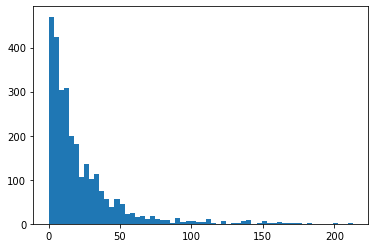

In [86]:
plt.hist(full_prediction_df['abs_error'], bins=60)

In [102]:
full_prediction_df[full_prediction_df['abs_error'] >= 100].sort_values('abs_error', ascending=False)[0:50]

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error
36,8,39.910755,62.0,2022.0,Diospyros,273.575810,516.0,Diospyros virginiana,39.9,273.6,275,213.0
50,2,38.376015,63.0,2022.0,Malus,237.491870,516.0,Malus sieboldii,38.4,237.5,275,212.0
46,8,39.910755,75.0,2022.0,Diospyros,273.575810,516.0,Diospyros virginiana,39.9,273.6,275,200.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516.0,Malus,43.0,281.2,245,182.0
182,1824168,32.078188,357.0,2022.0,Citrus,34.802053,516.0,Citrus,32.1,34.8,183,174.0
193,1824165,32.026304,356.0,2022.0,Citrus,278.925524,516.0,Citrus,32.0,278.9,183,173.0
492,4,34.051340,73.0,2022.0,Olea,241.796875,516.0,Olea europaea,34.1,241.8,245,172.0
98,1823026,33.922294,289.0,2022.0,Eriobotrya,241.593083,516.0,Eriobotrya japonica,33.9,241.6,122,167.0
324869,3096,39.997452,108.0,2022.0,Malus,254.717300,516.0,Malus pumila,40.0,254.7,275,167.0
413,1824101,32.056094,349.0,2022.0,Citrus,34.799296,516.0,Citrus,32.1,34.8,183,166.0


In [103]:
full_prediction_df

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error
19,1812903,42.000443,183.0,2022.0,Rubus,268.349632,516.0,Rubus,42.0,268.3,183,0.0
20,1812992,43.123822,181.0,2022.0,Rubus,282.422069,516.0,Rubus,43.1,282.4,183,2.0
22,1813012,35.219765,190.0,2022.0,Rubus,270.150501,516.0,Rubus,35.2,270.2,183,7.0
23,1813095,43.026309,193.0,2022.0,Rubus,274.317216,516.0,Rubus,43.0,274.3,183,10.0
25,1810562,37.417095,165.0,2022.0,Rubus,280.809241,516.0,Rubus,37.4,280.8,183,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1,1759647,NaN,240.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,35.0
2,1760749,NaN,271.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,4.0
0,1769198,NaN,261.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,14.0
1,1718728,NaN,281.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,6.0


In [104]:
74 / 2849

0.025974025974025976

(array([  34.,   33.,   22.,   44.,   39.,   14.,   33.,   31.,   28.,
          34.,   34.,   23.,   44.,   55.,   33.,   38.,   56.,   31.,
          31.,   48.,   46.,   35.,   21.,   47.,   38.,   46.,   55.,
          56.,   36.,   42.,   42.,   26.,   51.,   55.,   37.,   40.,
          56.,   59.,  106.,   87.,  206.,  295.,  286.,  474.,  612.,
         590.,  892.,  860.,  653.,  814.,  678.,  470.,  698.,  657.,
         616.,  709.,  868.,  590.,  962.,  581.,  771.,  767.,  502.,
         816.,  753.,  518.,  721.,  677.,  512.,  833.,  885.,  763.,
         846., 1062.,  928., 1064.,  974.,  920.,  855.,  529.,  606.,
         387.,  218.,  196.,  149.,   74.,   82.,   68.,   63.,   41.,
          45.,   49.,   48.,   49.,   24.,   50.,   28.,   26.,   24.,
          17.]),
 array([  1.  ,   4.65,   8.3 ,  11.95,  15.6 ,  19.25,  22.9 ,  26.55,
         30.2 ,  33.85,  37.5 ,  41.15,  44.8 ,  48.45,  52.1 ,  55.75,
         59.4 ,  63.05,  66.7 ,  70.35,  74.  ,  77.65,  8

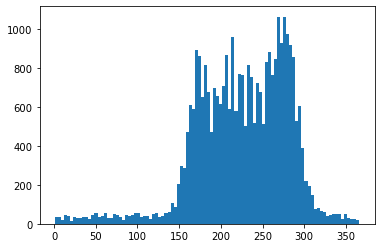

In [106]:
plt.hist(formatted_plants['doy'], bins=100)

Based on this histogram, most of the observations fall between like 150 and 315 days. Very odd. Same is true for the filtered plants. Is it just noise? 

Could probably cut off days with <20 observations (145 - 314). 

(array([ 30.,  17.,  11.,  32.,  34.,  12.,  13.,  10.,  30.,  23.,  26.,
         26.,  19.,  30.,  21.,  20.,  33.,  18.,  23.,  26.,  30.,  33.,
         22.,  27.,  39.,  56.,  66.,  89., 110., 162., 228., 283., 315.,
        527., 588., 642., 646., 626., 642., 597., 527., 499., 525., 454.,
        467., 530., 598., 540., 634., 581., 935., 573., 600., 495., 556.,
        478., 622., 528., 537., 469., 552., 460., 457., 636., 594., 614.,
        901., 704., 730., 896., 774., 686., 901., 648., 648., 494., 474.,
        298., 222., 169., 108., 106.,  70.,  68.,  46.,  57.,  43.,  24.,
         26.,  39.,  36.,  30.,  27.,  20.,  32.,  17.,  21.,  12.,  22.,
         12.]),
 array([ 60.  ,  63.06,  66.12,  69.18,  72.24,  75.3 ,  78.36,  81.42,
         84.48,  87.54,  90.6 ,  93.66,  96.72,  99.78, 102.84, 105.9 ,
        108.96, 112.02, 115.08, 118.14, 121.2 , 124.26, 127.32, 130.38,
        133.44, 136.5 , 139.56, 142.62, 145.68, 148.74, 151.8 , 154.86,
        157.92, 160.98, 164.04

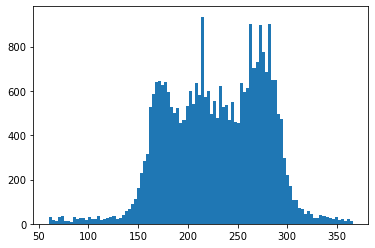

In [107]:
plt.hist(filtered_plants['doy'], bins=100)

In [110]:
dict(filtered_plants.groupby('doy').size())

{60.0: 8,
 61.0: 5,
 62.0: 6,
 63.0: 11,
 64.0: 4,
 65.0: 6,
 66.0: 7,
 67.0: 5,
 68.0: 3,
 69.0: 3,
 70.0: 8,
 71.0: 8,
 72.0: 16,
 73.0: 14,
 74.0: 4,
 75.0: 16,
 76.0: 4,
 77.0: 4,
 78.0: 4,
 79.0: 4,
 80.0: 5,
 81.0: 4,
 82.0: 3,
 83.0: 4,
 84.0: 3,
 85.0: 8,
 86.0: 6,
 87.0: 16,
 88.0: 9,
 89.0: 5,
 90.0: 9,
 91.0: 9,
 92.0: 4,
 93.0: 13,
 94.0: 8,
 95.0: 8,
 96.0: 10,
 97.0: 8,
 98.0: 5,
 99.0: 6,
 100.0: 10,
 101.0: 13,
 102.0: 7,
 103.0: 10,
 104.0: 4,
 105.0: 7,
 106.0: 8,
 107.0: 6,
 108.0: 6,
 109.0: 8,
 110.0: 12,
 111.0: 9,
 112.0: 4,
 113.0: 4,
 114.0: 9,
 115.0: 5,
 116.0: 12,
 117.0: 3,
 118.0: 8,
 119.0: 9,
 120.0: 6,
 121.0: 11,
 122.0: 10,
 123.0: 9,
 124.0: 11,
 125.0: 11,
 126.0: 11,
 127.0: 11,
 128.0: 5,
 129.0: 4,
 130.0: 13,
 131.0: 8,
 132.0: 7,
 133.0: 12,
 134.0: 12,
 135.0: 12,
 136.0: 15,
 137.0: 14,
 138.0: 25,
 139.0: 17,
 140.0: 27,
 141.0: 18,
 142.0: 21,
 143.0: 36,
 144.0: 18,
 145.0: 35,
 146.0: 32,
 147.0: 27,
 148.0: 51,
 149.0: 31,
 150.0: 74,
 1

In [111]:
aggressive_filtered_plants = filtered_plants.query('doy <= 145 and doy >= 314')

In [ ]:
genus_prediction_dict = {}

for s in tqdm(filtered_plants['genus'].unique()):
    print(s)
    species_train_df = filtered_plants.query('genus == "{}" and year < {}'.format(s, high_cutoff_year))
    
    if len(species_train_df) == 0:
        continue
    
    species_test_df = filtered_plants.query('genus == "{}" and year >= {}'.format(s, high_cutoff_year))
    
    if len(species_test_df) == 0:
        # make predictions and compare to the mean ripeness day at each site
        species_test_df = make_test_df(species_train_df)
    
    if len(species_test_df) == 0:
        print("No test data for {}".format(s))
        #print(species_test_df)
        
    predictions = train_ripeness_small(species_train_df, weather_training,
                        species_test_df, weather_test)
    
    genus_prediction_dict[s] = predictions